## Vanilla Vision Transformer From Scratch

In [24]:
import math
import time
import numpy as np
import copy

from utils import dataset
from models import VanillaVisionTransformer

import matplotlib.pyplot as plt
import matplotlib

# Pytorch packages
import torch
import torch.optim as optim
import torch.nn as nn

# torchvision
import torchvision
from torchvision import transforms

# Tqdm progress bar
from tqdm import tqdm_notebook

# obtain reproducible results in PyTorch
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [25]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [26]:
LEARNING_RATE = 0.0000001
MOMENTUM = 0.5
WEIGHT_DECAY_REGULARIZATION_TERM = 0.000000001
NUM_EPOCHS = 10
BATCH_SIZE = 1

PATCH_SIZE = 4
HIDDEN_DIM = 96
EMBED_DIM = 384 # aka mlp_dim
NUM_CHANNELS = 3
NUM_HEADS = 6
NUM_LAYERS = 6
DROPOUT = 0.2

# converts image into patches. patch_size is the size of each patch
def img_to_patches(x, patch_size, flatten_channels=True):
    B, C, H, W = x.shape
    x = x.reshape(B, C, H//patch_size, patch_size, W//patch_size, patch_size)
    x = x.permute(0, 2, 4, 1, 3, 5) # [B, H', W', C, p_H, p_W]
    x = x.flatten(1,2)              # [B, H'*W', C, p_H, p_W]
    if flatten_channels:
        x = x.flatten(2,4)          # [B, H'*W', C*p_H*p_W]
    return x

class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n

        self.avg = self.sum / self.count

def train(epoch, data_loader, model, optimizer, criterion, scaler=None):
    iter_time = AverageMeter()
    losses = AverageMeter()

    for idx, (data, target) in enumerate(data_loader):
        start = time.time()
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()

        with torch.autocast("cuda"): #Automatic Mixed precision
            data = img_to_patches(data, patch_size = PATCH_SIZE, flatten_channels=True)
            out = model(data).to(device)
#             loss = torch.sqrt(criterion(out, target))
            loss = criterion(out, target)
    
#         print("DATA TYPES")
#         print(out.dtype)
#         print(target.dtype)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

        for param in model.parameters():
            param.grad = None
        scaler.scale(loss).backward()
        scaler.step(optimizer)

        scaler.update()
        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 10 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t'
                   'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  .format(epoch, idx, len(data_loader), iter_time=iter_time, loss=losses)))
    
    return losses.avg

def validate(epoch, validation_loader, model, criterion):
    iter_time = AverageMeter()
    losses = AverageMeter()

    for idx, (data, target) in enumerate(validation_loader):
        start = time.time()

        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        target = target.to(torch.float16)

        out = None
        loss = None
        data = img_to_patches(data, patch_size = PATCH_SIZE, flatten_channels=True)

        with torch.no_grad():
            out = model(data).to(device)
#             loss = torch.sqrt(criterion(out, target))
            loss = criterion(out, target)


        losses.update(loss, out.shape[0])

        iter_time.update(time.time() - start)
        if idx % 10 == 0:
            print(('Epoch: [{0}][{1}/{2}]\t'
                   'Time {iter_time.val:.3f} ({iter_time.avg:.3f})\t')
                  .format(epoch, idx, len(validation_loader), iter_time=iter_time, loss=losses))

    print("* Average Loss @1: {loss.avg:.4f}".format(loss=losses))
    return losses.avg

def RMSELoss(yhat, y, eps=1e-6):
    return torch.sqrt(torch.mean((yhat-y)**2) + eps)

def plots(losses, lr=LEARNING_RATE, reg=WEIGHT_DECAY_REGULARIZATION_TERM, batch=BATCH_SIZE): #, momentum=MOMENTUM):
    fig1, ax1 = plt.subplots(figsize=(8, 10))
    ax1.plot(losses[0], label='Training Losses')
    ax1.plot(losses[1], label='Validation Losses')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MSE Loss')
    ax1.set_title(f'ViT Loss Curve; LR={lr}; Reg_Term={reg} Batch={batch}')
    ax1.legend(loc="best")
    plt.grid()
    plt.show()

C:\Users\Steven\anaconda3\envs\cs7643-a4-5\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: [0][0/27046]	Time 0.259 (0.259)	Loss 1.2170 (1.2170)	
Epoch: [0][10/27046]	Time 0.036 (0.059)	Loss 0.2399 (0.3219)	
Epoch: [0][20/27046]	Time 0.036 (0.048)	Loss 0.0216 (0.2730)	
Epoch: [0][30/27046]	Time 0.037 (0.045)	Loss 0.1496 (0.2200)	
Epoch: [0][40/27046]	Time 0.037 (0.043)	Loss 0.3372 (0.1962)	
Epoch: [0][50/27046]	Time 0.038 (0.042)	Loss 0.4471 (0.2488)	
Epoch: [0][60/27046]	Time 0.037 (0.041)	Loss 0.7568 (0.2342)	
Epoch: [0][70/27046]	Time 0.037 (0.040)	Loss 0.2582 (0.2172)	
Epoch: [0][80/27046]	Time 0.037 (0.040)	Loss 0.0532 (0.2081)	
Epoch: [0][90/27046]	Time 0.036 (0.040)	Loss 0.0463 (0.1908)	
Epoch: [0][100/27046]	Time 0.037 (0.039)	Loss 0.1391 (0.1808)	
Epoch: [0][110/27046]	Time 0.037 (0.039)	Loss 0.0190 (0.1678)	
Epoch: [0][120/27046]	Time 0.036 (0.039)	Loss 0.1860 (0.1838)	
Epoch: [0][130/27046]	Time 0.037 (0.039)	Loss 0.1137 (0.1774)	
Epoch: [0][140/27046]	Time 0.037 (0.039)	Loss 0.0325 (0.1802)	
Epoch: [0][150/27046]	Time 0.037 (0.039)	Loss 0.1157 (0.1750)	
Epo

Epoch: [0][1300/27046]	Time 0.039 (0.038)	Loss 0.1853 (0.1488)	
Epoch: [0][1310/27046]	Time 0.038 (0.038)	Loss 0.1465 (0.1494)	
Epoch: [0][1320/27046]	Time 0.039 (0.038)	Loss 0.1492 (0.1487)	
Epoch: [0][1330/27046]	Time 0.039 (0.038)	Loss 0.0147 (0.1487)	
Epoch: [0][1340/27046]	Time 0.038 (0.038)	Loss 0.0225 (0.1483)	
Epoch: [0][1350/27046]	Time 0.039 (0.038)	Loss 0.1695 (0.1528)	
Epoch: [0][1360/27046]	Time 0.040 (0.038)	Loss 0.5245 (0.1526)	
Epoch: [0][1370/27046]	Time 0.040 (0.038)	Loss 0.0063 (0.1521)	
Epoch: [0][1380/27046]	Time 0.040 (0.038)	Loss 0.0045 (0.1524)	
Epoch: [0][1390/27046]	Time 0.037 (0.038)	Loss 0.3082 (0.1518)	
Epoch: [0][1400/27046]	Time 0.037 (0.038)	Loss 0.0288 (0.1517)	
Epoch: [0][1410/27046]	Time 0.040 (0.038)	Loss 0.0473 (0.1513)	
Epoch: [0][1420/27046]	Time 0.040 (0.038)	Loss 0.0067 (0.1505)	
Epoch: [0][1430/27046]	Time 0.037 (0.038)	Loss 0.1311 (0.1508)	
Epoch: [0][1440/27046]	Time 0.038 (0.038)	Loss 0.1630 (0.1504)	
Epoch: [0][1450/27046]	Time 0.038 (0.038

Epoch: [0][2590/27046]	Time 0.037 (0.038)	Loss 0.0583 (0.1431)	
Epoch: [0][2600/27046]	Time 0.037 (0.038)	Loss 0.0331 (0.1427)	
Epoch: [0][2610/27046]	Time 0.038 (0.038)	Loss 0.0808 (0.1424)	
Epoch: [0][2620/27046]	Time 0.036 (0.038)	Loss 0.0709 (0.1422)	
Epoch: [0][2630/27046]	Time 0.037 (0.038)	Loss 0.4252 (0.1437)	
Epoch: [0][2640/27046]	Time 0.037 (0.038)	Loss 0.4218 (0.1441)	
Epoch: [0][2650/27046]	Time 0.037 (0.038)	Loss 0.0050 (0.1437)	
Epoch: [0][2660/27046]	Time 0.037 (0.038)	Loss 0.1066 (0.1437)	
Epoch: [0][2670/27046]	Time 0.038 (0.038)	Loss 0.0019 (0.1436)	
Epoch: [0][2680/27046]	Time 0.037 (0.038)	Loss 0.0194 (0.1435)	
Epoch: [0][2690/27046]	Time 0.037 (0.038)	Loss 0.0011 (0.1433)	
Epoch: [0][2700/27046]	Time 0.037 (0.038)	Loss 0.0537 (0.1432)	
Epoch: [0][2710/27046]	Time 0.037 (0.038)	Loss 0.0011 (0.1429)	
Epoch: [0][2720/27046]	Time 0.037 (0.038)	Loss 0.0010 (0.1432)	
Epoch: [0][2730/27046]	Time 0.037 (0.038)	Loss 0.0076 (0.1436)	
Epoch: [0][2740/27046]	Time 0.037 (0.038

Epoch: [0][3880/27046]	Time 0.036 (0.038)	Loss 0.0209 (0.1425)	
Epoch: [0][3890/27046]	Time 0.037 (0.038)	Loss 0.0010 (0.1430)	
Epoch: [0][3900/27046]	Time 0.038 (0.038)	Loss 0.0477 (0.1427)	
Epoch: [0][3910/27046]	Time 0.038 (0.038)	Loss 0.0115 (0.1426)	
Epoch: [0][3920/27046]	Time 0.037 (0.038)	Loss 0.0045 (0.1424)	
Epoch: [0][3930/27046]	Time 0.037 (0.038)	Loss 0.0226 (0.1421)	
Epoch: [0][3940/27046]	Time 0.038 (0.038)	Loss 0.1357 (0.1419)	
Epoch: [0][3950/27046]	Time 0.038 (0.038)	Loss 0.0111 (0.1418)	
Epoch: [0][3960/27046]	Time 0.037 (0.038)	Loss 0.0104 (0.1416)	
Epoch: [0][3970/27046]	Time 0.038 (0.038)	Loss 0.4450 (0.1417)	
Epoch: [0][3980/27046]	Time 0.037 (0.038)	Loss 0.2063 (0.1415)	
Epoch: [0][3990/27046]	Time 0.038 (0.038)	Loss 0.0164 (0.1415)	
Epoch: [0][4000/27046]	Time 0.038 (0.038)	Loss 0.0493 (0.1414)	
Epoch: [0][4010/27046]	Time 0.037 (0.038)	Loss 0.0388 (0.1412)	
Epoch: [0][4020/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.1412)	
Epoch: [0][4030/27046]	Time 0.038 (0.038

Epoch: [0][5170/27046]	Time 0.036 (0.038)	Loss 0.2402 (0.1370)	
Epoch: [0][5180/27046]	Time 0.037 (0.038)	Loss 0.0690 (0.1369)	
Epoch: [0][5190/27046]	Time 0.037 (0.038)	Loss 0.2677 (0.1368)	
Epoch: [0][5200/27046]	Time 0.036 (0.038)	Loss 0.2114 (0.1367)	
Epoch: [0][5210/27046]	Time 0.037 (0.038)	Loss 0.0483 (0.1366)	
Epoch: [0][5220/27046]	Time 0.038 (0.038)	Loss 0.0022 (0.1364)	
Epoch: [0][5230/27046]	Time 0.039 (0.038)	Loss 0.0006 (0.1362)	
Epoch: [0][5240/27046]	Time 0.037 (0.038)	Loss 0.0025 (0.1362)	
Epoch: [0][5250/27046]	Time 0.040 (0.038)	Loss 0.1015 (0.1362)	
Epoch: [0][5260/27046]	Time 0.039 (0.038)	Loss 0.0010 (0.1362)	
Epoch: [0][5270/27046]	Time 0.039 (0.038)	Loss 0.0010 (0.1363)	
Epoch: [0][5280/27046]	Time 0.039 (0.038)	Loss 0.0447 (0.1361)	
Epoch: [0][5290/27046]	Time 0.037 (0.038)	Loss 0.0069 (0.1364)	
Epoch: [0][5300/27046]	Time 0.037 (0.038)	Loss 0.1925 (0.1363)	
Epoch: [0][5310/27046]	Time 0.038 (0.038)	Loss 0.0103 (0.1362)	
Epoch: [0][5320/27046]	Time 0.038 (0.038

Epoch: [0][6460/27046]	Time 0.039 (0.038)	Loss 0.0493 (0.1322)	
Epoch: [0][6470/27046]	Time 0.038 (0.038)	Loss 0.0151 (0.1322)	
Epoch: [0][6480/27046]	Time 0.038 (0.038)	Loss 0.5010 (0.1324)	
Epoch: [0][6490/27046]	Time 0.039 (0.038)	Loss 0.0000 (0.1323)	
Epoch: [0][6500/27046]	Time 0.039 (0.038)	Loss 0.0003 (0.1322)	
Epoch: [0][6510/27046]	Time 0.038 (0.038)	Loss 0.2650 (0.1320)	
Epoch: [0][6520/27046]	Time 0.038 (0.038)	Loss 0.0425 (0.1320)	
Epoch: [0][6530/27046]	Time 0.039 (0.038)	Loss 0.3710 (0.1318)	
Epoch: [0][6540/27046]	Time 0.038 (0.038)	Loss 0.1045 (0.1318)	
Epoch: [0][6550/27046]	Time 0.038 (0.038)	Loss 0.1136 (0.1321)	
Epoch: [0][6560/27046]	Time 0.040 (0.038)	Loss 0.0984 (0.1321)	
Epoch: [0][6570/27046]	Time 0.040 (0.038)	Loss 0.0026 (0.1319)	
Epoch: [0][6580/27046]	Time 0.038 (0.038)	Loss 0.0346 (0.1318)	
Epoch: [0][6590/27046]	Time 0.039 (0.038)	Loss 0.4541 (0.1318)	
Epoch: [0][6600/27046]	Time 0.038 (0.038)	Loss 0.0719 (0.1318)	
Epoch: [0][6610/27046]	Time 0.038 (0.038

Epoch: [0][7750/27046]	Time 0.037 (0.038)	Loss 2.4025 (0.1298)	
Epoch: [0][7760/27046]	Time 0.038 (0.038)	Loss 0.0259 (0.1297)	
Epoch: [0][7770/27046]	Time 0.036 (0.038)	Loss 0.0259 (0.1296)	
Epoch: [0][7780/27046]	Time 0.036 (0.038)	Loss 0.0037 (0.1295)	
Epoch: [0][7790/27046]	Time 0.036 (0.038)	Loss 0.0122 (0.1294)	
Epoch: [0][7800/27046]	Time 0.036 (0.038)	Loss 0.0132 (0.1293)	
Epoch: [0][7810/27046]	Time 0.036 (0.038)	Loss 0.0980 (0.1292)	
Epoch: [0][7820/27046]	Time 0.035 (0.038)	Loss 0.1507 (0.1291)	
Epoch: [0][7830/27046]	Time 0.036 (0.038)	Loss 1.2625 (0.1292)	
Epoch: [0][7840/27046]	Time 0.035 (0.038)	Loss 0.0074 (0.1293)	
Epoch: [0][7850/27046]	Time 0.037 (0.038)	Loss 0.0279 (0.1291)	
Epoch: [0][7860/27046]	Time 0.036 (0.038)	Loss 0.0111 (0.1291)	
Epoch: [0][7870/27046]	Time 0.035 (0.038)	Loss 0.0001 (0.1290)	
Epoch: [0][7880/27046]	Time 0.035 (0.038)	Loss 0.0239 (0.1294)	
Epoch: [0][7890/27046]	Time 0.036 (0.038)	Loss 0.0045 (0.1294)	
Epoch: [0][7900/27046]	Time 0.036 (0.038

Epoch: [0][9040/27046]	Time 0.035 (0.037)	Loss 0.0530 (0.1263)	
Epoch: [0][9050/27046]	Time 0.036 (0.037)	Loss 1.6292 (0.1263)	
Epoch: [0][9060/27046]	Time 0.036 (0.037)	Loss 0.0168 (0.1262)	
Epoch: [0][9070/27046]	Time 0.036 (0.037)	Loss 0.0099 (0.1263)	
Epoch: [0][9080/27046]	Time 0.036 (0.037)	Loss 0.0168 (0.1262)	
Epoch: [0][9090/27046]	Time 0.036 (0.037)	Loss 0.1710 (0.1262)	
Epoch: [0][9100/27046]	Time 0.036 (0.037)	Loss 0.0872 (0.1262)	
Epoch: [0][9110/27046]	Time 0.036 (0.037)	Loss 0.0537 (0.1261)	
Epoch: [0][9120/27046]	Time 0.035 (0.037)	Loss 0.0243 (0.1260)	
Epoch: [0][9130/27046]	Time 0.036 (0.037)	Loss 0.0466 (0.1261)	
Epoch: [0][9140/27046]	Time 0.036 (0.037)	Loss 0.0515 (0.1260)	
Epoch: [0][9150/27046]	Time 0.036 (0.037)	Loss 0.0158 (0.1260)	
Epoch: [0][9160/27046]	Time 0.035 (0.037)	Loss 0.0090 (0.1259)	
Epoch: [0][9170/27046]	Time 0.036 (0.037)	Loss 0.0622 (0.1258)	
Epoch: [0][9180/27046]	Time 0.036 (0.037)	Loss 0.1231 (0.1259)	
Epoch: [0][9190/27046]	Time 0.037 (0.037

Epoch: [0][10320/27046]	Time 0.038 (0.037)	Loss 0.0082 (0.1237)	
Epoch: [0][10330/27046]	Time 0.037 (0.037)	Loss 0.0034 (0.1238)	
Epoch: [0][10340/27046]	Time 0.037 (0.037)	Loss 0.0065 (0.1238)	
Epoch: [0][10350/27046]	Time 0.038 (0.037)	Loss 0.0138 (0.1237)	
Epoch: [0][10360/27046]	Time 0.038 (0.037)	Loss 0.0001 (0.1237)	
Epoch: [0][10370/27046]	Time 0.037 (0.037)	Loss 0.0919 (0.1236)	
Epoch: [0][10380/27046]	Time 0.038 (0.037)	Loss 0.0003 (0.1237)	
Epoch: [0][10390/27046]	Time 0.037 (0.037)	Loss 0.2140 (0.1238)	
Epoch: [0][10400/27046]	Time 0.037 (0.037)	Loss 0.0819 (0.1237)	
Epoch: [0][10410/27046]	Time 0.038 (0.037)	Loss 0.0034 (0.1236)	
Epoch: [0][10420/27046]	Time 0.037 (0.037)	Loss 0.0459 (0.1235)	
Epoch: [0][10430/27046]	Time 0.038 (0.037)	Loss 0.0018 (0.1234)	
Epoch: [0][10440/27046]	Time 0.037 (0.037)	Loss 0.0438 (0.1234)	
Epoch: [0][10450/27046]	Time 0.039 (0.037)	Loss 0.0522 (0.1234)	
Epoch: [0][10460/27046]	Time 0.038 (0.037)	Loss 0.0330 (0.1234)	
Epoch: [0][10470/27046]	T

Epoch: [0][11590/27046]	Time 0.037 (0.037)	Loss 0.1692 (0.1216)	
Epoch: [0][11600/27046]	Time 0.037 (0.037)	Loss 0.0321 (0.1216)	
Epoch: [0][11610/27046]	Time 0.037 (0.037)	Loss 0.0560 (0.1215)	
Epoch: [0][11620/27046]	Time 0.038 (0.037)	Loss 0.0487 (0.1214)	
Epoch: [0][11630/27046]	Time 0.038 (0.037)	Loss 0.0039 (0.1214)	
Epoch: [0][11640/27046]	Time 0.038 (0.037)	Loss 0.0131 (0.1214)	
Epoch: [0][11650/27046]	Time 0.037 (0.037)	Loss 0.0517 (0.1218)	
Epoch: [0][11660/27046]	Time 0.037 (0.037)	Loss 0.0029 (0.1217)	
Epoch: [0][11670/27046]	Time 0.037 (0.037)	Loss 0.0051 (0.1217)	
Epoch: [0][11680/27046]	Time 0.037 (0.037)	Loss 0.2424 (0.1217)	
Epoch: [0][11690/27046]	Time 0.037 (0.037)	Loss 0.0001 (0.1217)	
Epoch: [0][11700/27046]	Time 0.037 (0.037)	Loss 0.0306 (0.1218)	
Epoch: [0][11710/27046]	Time 0.038 (0.037)	Loss 0.0171 (0.1217)	
Epoch: [0][11720/27046]	Time 0.037 (0.037)	Loss 0.0026 (0.1216)	
Epoch: [0][11730/27046]	Time 0.038 (0.037)	Loss 0.0044 (0.1219)	
Epoch: [0][11740/27046]	T

Epoch: [0][12860/27046]	Time 0.037 (0.037)	Loss 0.0428 (0.1218)	
Epoch: [0][12870/27046]	Time 0.039 (0.037)	Loss 0.0220 (0.1218)	
Epoch: [0][12880/27046]	Time 0.037 (0.037)	Loss 0.0118 (0.1217)	
Epoch: [0][12890/27046]	Time 0.040 (0.037)	Loss 0.0000 (0.1217)	
Epoch: [0][12900/27046]	Time 0.039 (0.037)	Loss 0.0528 (0.1216)	
Epoch: [0][12910/27046]	Time 0.039 (0.037)	Loss 0.2216 (0.1217)	
Epoch: [0][12920/27046]	Time 0.039 (0.037)	Loss 0.0374 (0.1216)	
Epoch: [0][12930/27046]	Time 0.038 (0.037)	Loss 0.2795 (0.1216)	
Epoch: [0][12940/27046]	Time 0.038 (0.037)	Loss 0.0149 (0.1215)	
Epoch: [0][12950/27046]	Time 0.038 (0.037)	Loss 0.0247 (0.1215)	
Epoch: [0][12960/27046]	Time 0.039 (0.037)	Loss 0.0006 (0.1215)	
Epoch: [0][12970/27046]	Time 0.038 (0.037)	Loss 0.0543 (0.1215)	
Epoch: [0][12980/27046]	Time 0.038 (0.037)	Loss 0.0287 (0.1214)	
Epoch: [0][12990/27046]	Time 0.039 (0.037)	Loss 0.0100 (0.1215)	
Epoch: [0][13000/27046]	Time 0.041 (0.037)	Loss 0.0415 (0.1214)	
Epoch: [0][13010/27046]	T

Epoch: [0][14130/27046]	Time 0.038 (0.038)	Loss 0.0034 (0.1208)	
Epoch: [0][14140/27046]	Time 0.037 (0.038)	Loss 0.0011 (0.1208)	
Epoch: [0][14150/27046]	Time 0.038 (0.038)	Loss 0.4623 (0.1208)	
Epoch: [0][14160/27046]	Time 0.038 (0.038)	Loss 0.0167 (0.1208)	
Epoch: [0][14170/27046]	Time 0.038 (0.038)	Loss 0.0020 (0.1208)	
Epoch: [0][14180/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.1208)	
Epoch: [0][14190/27046]	Time 0.037 (0.038)	Loss 0.0070 (0.1207)	
Epoch: [0][14200/27046]	Time 0.037 (0.038)	Loss 0.0111 (0.1206)	
Epoch: [0][14210/27046]	Time 0.039 (0.038)	Loss 0.0091 (0.1206)	
Epoch: [0][14220/27046]	Time 0.040 (0.038)	Loss 0.0169 (0.1207)	
Epoch: [0][14230/27046]	Time 0.037 (0.038)	Loss 0.0999 (0.1206)	
Epoch: [0][14240/27046]	Time 0.039 (0.038)	Loss 0.0009 (0.1206)	
Epoch: [0][14250/27046]	Time 0.039 (0.038)	Loss 0.0041 (0.1206)	
Epoch: [0][14260/27046]	Time 0.038 (0.038)	Loss 0.4148 (0.1206)	
Epoch: [0][14270/27046]	Time 0.039 (0.038)	Loss 0.0375 (0.1205)	
Epoch: [0][14280/27046]	T

Epoch: [0][15400/27046]	Time 0.039 (0.038)	Loss 0.0304 (0.1197)	
Epoch: [0][15410/27046]	Time 0.038 (0.038)	Loss 0.0016 (0.1197)	
Epoch: [0][15420/27046]	Time 0.036 (0.038)	Loss 0.0027 (0.1196)	
Epoch: [0][15430/27046]	Time 0.037 (0.038)	Loss 0.0001 (0.1196)	
Epoch: [0][15440/27046]	Time 0.038 (0.038)	Loss 0.0424 (0.1196)	
Epoch: [0][15450/27046]	Time 0.038 (0.038)	Loss 0.0011 (0.1195)	
Epoch: [0][15460/27046]	Time 0.037 (0.038)	Loss 0.0728 (0.1195)	
Epoch: [0][15470/27046]	Time 0.037 (0.038)	Loss 0.0020 (0.1195)	
Epoch: [0][15480/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.1194)	
Epoch: [0][15490/27046]	Time 0.038 (0.038)	Loss 0.1192 (0.1194)	
Epoch: [0][15500/27046]	Time 0.038 (0.038)	Loss 0.0768 (0.1193)	
Epoch: [0][15510/27046]	Time 0.038 (0.038)	Loss 0.0042 (0.1193)	
Epoch: [0][15520/27046]	Time 0.037 (0.038)	Loss 0.0182 (0.1193)	
Epoch: [0][15530/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.1193)	
Epoch: [0][15540/27046]	Time 0.038 (0.038)	Loss 0.0166 (0.1193)	
Epoch: [0][15550/27046]	T

Epoch: [0][16670/27046]	Time 0.037 (0.038)	Loss 0.0203 (0.1173)	
Epoch: [0][16680/27046]	Time 0.037 (0.038)	Loss 0.0194 (0.1172)	
Epoch: [0][16690/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.1172)	
Epoch: [0][16700/27046]	Time 0.037 (0.038)	Loss 0.0365 (0.1171)	
Epoch: [0][16710/27046]	Time 0.038 (0.038)	Loss 0.0966 (0.1171)	
Epoch: [0][16720/27046]	Time 0.038 (0.038)	Loss 0.0203 (0.1170)	
Epoch: [0][16730/27046]	Time 0.038 (0.038)	Loss 0.2488 (0.1171)	
Epoch: [0][16740/27046]	Time 0.038 (0.038)	Loss 0.1328 (0.1171)	
Epoch: [0][16750/27046]	Time 0.038 (0.038)	Loss 0.0018 (0.1171)	
Epoch: [0][16760/27046]	Time 0.037 (0.038)	Loss 0.0138 (0.1170)	
Epoch: [0][16770/27046]	Time 0.037 (0.038)	Loss 0.0097 (0.1170)	
Epoch: [0][16780/27046]	Time 0.037 (0.038)	Loss 0.0055 (0.1169)	
Epoch: [0][16790/27046]	Time 0.038 (0.038)	Loss 0.0103 (0.1169)	
Epoch: [0][16800/27046]	Time 0.038 (0.038)	Loss 0.7579 (0.1169)	
Epoch: [0][16810/27046]	Time 0.038 (0.038)	Loss 0.0055 (0.1169)	
Epoch: [0][16820/27046]	T

Epoch: [0][17940/27046]	Time 0.039 (0.038)	Loss 0.0597 (0.1157)	
Epoch: [0][17950/27046]	Time 0.037 (0.038)	Loss 0.0020 (0.1156)	
Epoch: [0][17960/27046]	Time 0.038 (0.038)	Loss 0.0136 (0.1156)	
Epoch: [0][17970/27046]	Time 0.038 (0.038)	Loss 0.0018 (0.1156)	
Epoch: [0][17980/27046]	Time 0.038 (0.038)	Loss 0.0068 (0.1156)	
Epoch: [0][17990/27046]	Time 0.037 (0.038)	Loss 0.0019 (0.1155)	
Epoch: [0][18000/27046]	Time 0.037 (0.038)	Loss 0.0515 (0.1155)	
Epoch: [0][18010/27046]	Time 0.039 (0.038)	Loss 0.0754 (0.1155)	
Epoch: [0][18020/27046]	Time 0.037 (0.038)	Loss 0.0629 (0.1155)	
Epoch: [0][18030/27046]	Time 0.038 (0.038)	Loss 0.0152 (0.1154)	
Epoch: [0][18040/27046]	Time 0.037 (0.038)	Loss 0.0129 (0.1154)	
Epoch: [0][18050/27046]	Time 0.037 (0.038)	Loss 0.1139 (0.1154)	
Epoch: [0][18060/27046]	Time 0.038 (0.038)	Loss 0.0943 (0.1154)	
Epoch: [0][18070/27046]	Time 0.038 (0.038)	Loss 0.0054 (0.1154)	
Epoch: [0][18080/27046]	Time 0.038 (0.038)	Loss 0.0370 (0.1153)	
Epoch: [0][18090/27046]	T

Epoch: [0][19210/27046]	Time 0.038 (0.038)	Loss 0.0477 (0.1142)	
Epoch: [0][19220/27046]	Time 0.038 (0.038)	Loss 0.0429 (0.1141)	
Epoch: [0][19230/27046]	Time 0.037 (0.038)	Loss 0.0390 (0.1141)	
Epoch: [0][19240/27046]	Time 0.037 (0.038)	Loss 0.0032 (0.1140)	
Epoch: [0][19250/27046]	Time 0.037 (0.038)	Loss 0.2522 (0.1140)	
Epoch: [0][19260/27046]	Time 0.037 (0.038)	Loss 0.0014 (0.1140)	
Epoch: [0][19270/27046]	Time 0.037 (0.038)	Loss 0.0008 (0.1140)	
Epoch: [0][19280/27046]	Time 0.038 (0.038)	Loss 0.0445 (0.1140)	
Epoch: [0][19290/27046]	Time 0.037 (0.038)	Loss 0.1331 (0.1139)	
Epoch: [0][19300/27046]	Time 0.038 (0.038)	Loss 0.0134 (0.1141)	
Epoch: [0][19310/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.1140)	
Epoch: [0][19320/27046]	Time 0.037 (0.038)	Loss 0.0015 (0.1140)	
Epoch: [0][19330/27046]	Time 0.038 (0.038)	Loss 0.1138 (0.1139)	
Epoch: [0][19340/27046]	Time 0.037 (0.038)	Loss 0.0065 (0.1139)	
Epoch: [0][19350/27046]	Time 0.038 (0.038)	Loss 0.0022 (0.1139)	
Epoch: [0][19360/27046]	T

Epoch: [0][20480/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.1124)	
Epoch: [0][20490/27046]	Time 0.037 (0.038)	Loss 0.0261 (0.1123)	
Epoch: [0][20500/27046]	Time 0.037 (0.038)	Loss 0.2091 (0.1123)	
Epoch: [0][20510/27046]	Time 0.038 (0.038)	Loss 2.5769 (0.1124)	
Epoch: [0][20520/27046]	Time 0.037 (0.038)	Loss 0.0138 (0.1124)	
Epoch: [0][20530/27046]	Time 0.038 (0.038)	Loss 0.0207 (0.1124)	
Epoch: [0][20540/27046]	Time 0.037 (0.038)	Loss 0.0720 (0.1123)	
Epoch: [0][20550/27046]	Time 0.037 (0.038)	Loss 0.0074 (0.1124)	
Epoch: [0][20560/27046]	Time 0.039 (0.038)	Loss 0.0094 (0.1124)	
Epoch: [0][20570/27046]	Time 0.038 (0.038)	Loss 0.2146 (0.1124)	
Epoch: [0][20580/27046]	Time 0.038 (0.038)	Loss 0.0265 (0.1123)	
Epoch: [0][20590/27046]	Time 0.037 (0.038)	Loss 0.1995 (0.1123)	
Epoch: [0][20600/27046]	Time 0.037 (0.038)	Loss 0.0219 (0.1123)	
Epoch: [0][20610/27046]	Time 0.037 (0.038)	Loss 2.6864 (0.1124)	
Epoch: [0][20620/27046]	Time 0.038 (0.038)	Loss 0.0006 (0.1124)	
Epoch: [0][20630/27046]	T

Epoch: [0][21750/27046]	Time 0.038 (0.038)	Loss 0.1391 (0.1109)	
Epoch: [0][21760/27046]	Time 0.039 (0.038)	Loss 0.2257 (0.1109)	
Epoch: [0][21770/27046]	Time 0.038 (0.038)	Loss 0.0007 (0.1109)	
Epoch: [0][21780/27046]	Time 0.039 (0.038)	Loss 0.0020 (0.1109)	
Epoch: [0][21790/27046]	Time 0.039 (0.038)	Loss 0.4658 (0.1111)	
Epoch: [0][21800/27046]	Time 0.040 (0.038)	Loss 0.0048 (0.1111)	
Epoch: [0][21810/27046]	Time 0.041 (0.038)	Loss 0.0059 (0.1111)	
Epoch: [0][21820/27046]	Time 0.038 (0.038)	Loss 0.0013 (0.1110)	
Epoch: [0][21830/27046]	Time 0.040 (0.038)	Loss 0.0451 (0.1110)	
Epoch: [0][21840/27046]	Time 0.038 (0.038)	Loss 0.2224 (0.1110)	
Epoch: [0][21850/27046]	Time 0.040 (0.038)	Loss 1.9189 (0.1111)	
Epoch: [0][21860/27046]	Time 0.038 (0.038)	Loss 0.0032 (0.1110)	
Epoch: [0][21870/27046]	Time 0.039 (0.038)	Loss 0.0594 (0.1110)	
Epoch: [0][21880/27046]	Time 0.039 (0.038)	Loss 0.0246 (0.1110)	
Epoch: [0][21890/27046]	Time 0.038 (0.038)	Loss 0.5757 (0.1110)	
Epoch: [0][21900/27046]	T

Epoch: [0][23020/27046]	Time 0.038 (0.038)	Loss 0.0423 (0.1096)	
Epoch: [0][23030/27046]	Time 0.038 (0.038)	Loss 0.0081 (0.1096)	
Epoch: [0][23040/27046]	Time 0.038 (0.038)	Loss 0.0727 (0.1096)	
Epoch: [0][23050/27046]	Time 0.037 (0.038)	Loss 0.0827 (0.1096)	
Epoch: [0][23060/27046]	Time 0.039 (0.038)	Loss 0.0040 (0.1096)	
Epoch: [0][23070/27046]	Time 0.038 (0.038)	Loss 0.0320 (0.1096)	
Epoch: [0][23080/27046]	Time 0.037 (0.038)	Loss 0.0076 (0.1095)	
Epoch: [0][23090/27046]	Time 0.038 (0.038)	Loss 0.0019 (0.1095)	
Epoch: [0][23100/27046]	Time 0.038 (0.038)	Loss 0.0018 (0.1095)	
Epoch: [0][23110/27046]	Time 0.038 (0.038)	Loss 0.1451 (0.1095)	
Epoch: [0][23120/27046]	Time 0.039 (0.038)	Loss 0.0116 (0.1094)	
Epoch: [0][23130/27046]	Time 0.037 (0.038)	Loss 0.0169 (0.1094)	
Epoch: [0][23140/27046]	Time 0.038 (0.038)	Loss 0.0140 (0.1094)	
Epoch: [0][23150/27046]	Time 0.037 (0.038)	Loss 0.0101 (0.1095)	
Epoch: [0][23160/27046]	Time 0.038 (0.038)	Loss 0.5653 (0.1095)	
Epoch: [0][23170/27046]	T

Epoch: [0][24290/27046]	Time 0.038 (0.038)	Loss 0.0076 (0.1092)	
Epoch: [0][24300/27046]	Time 0.037 (0.038)	Loss 0.0450 (0.1092)	
Epoch: [0][24310/27046]	Time 0.038 (0.038)	Loss 0.0043 (0.1092)	
Epoch: [0][24320/27046]	Time 0.038 (0.038)	Loss 0.0010 (0.1092)	
Epoch: [0][24330/27046]	Time 0.038 (0.038)	Loss 0.0269 (0.1092)	
Epoch: [0][24340/27046]	Time 0.038 (0.038)	Loss 0.0288 (0.1091)	
Epoch: [0][24350/27046]	Time 0.036 (0.038)	Loss 0.0292 (0.1092)	
Epoch: [0][24360/27046]	Time 0.037 (0.038)	Loss 0.0002 (0.1091)	
Epoch: [0][24370/27046]	Time 0.038 (0.038)	Loss 0.0026 (0.1091)	
Epoch: [0][24380/27046]	Time 0.037 (0.038)	Loss 0.0065 (0.1091)	
Epoch: [0][24390/27046]	Time 0.037 (0.038)	Loss 0.0060 (0.1091)	
Epoch: [0][24400/27046]	Time 0.037 (0.038)	Loss 0.0297 (0.1091)	
Epoch: [0][24410/27046]	Time 0.036 (0.038)	Loss 0.0040 (0.1091)	
Epoch: [0][24420/27046]	Time 0.038 (0.038)	Loss 0.0249 (0.1091)	
Epoch: [0][24430/27046]	Time 0.038 (0.038)	Loss 0.0171 (0.1091)	
Epoch: [0][24440/27046]	T

Epoch: [0][25560/27046]	Time 0.036 (0.038)	Loss 0.0067 (0.1087)	
Epoch: [0][25570/27046]	Time 0.036 (0.038)	Loss 0.0204 (0.1087)	
Epoch: [0][25580/27046]	Time 0.036 (0.038)	Loss 0.0051 (0.1086)	
Epoch: [0][25590/27046]	Time 0.036 (0.038)	Loss 0.0235 (0.1087)	
Epoch: [0][25600/27046]	Time 0.035 (0.038)	Loss 0.0018 (0.1087)	
Epoch: [0][25610/27046]	Time 0.036 (0.038)	Loss 0.0031 (0.1087)	
Epoch: [0][25620/27046]	Time 0.035 (0.038)	Loss 0.1012 (0.1086)	
Epoch: [0][25630/27046]	Time 0.036 (0.038)	Loss 0.0354 (0.1086)	
Epoch: [0][25640/27046]	Time 0.035 (0.038)	Loss 0.0013 (0.1086)	
Epoch: [0][25650/27046]	Time 0.036 (0.038)	Loss 0.0473 (0.1086)	
Epoch: [0][25660/27046]	Time 0.035 (0.038)	Loss 0.0091 (0.1086)	
Epoch: [0][25670/27046]	Time 0.036 (0.038)	Loss 0.0046 (0.1085)	
Epoch: [0][25680/27046]	Time 0.036 (0.038)	Loss 0.0215 (0.1085)	
Epoch: [0][25690/27046]	Time 0.038 (0.038)	Loss 0.0100 (0.1085)	
Epoch: [0][25700/27046]	Time 0.036 (0.038)	Loss 0.0099 (0.1085)	
Epoch: [0][25710/27046]	T

Epoch: [0][26830/27046]	Time 0.038 (0.038)	Loss 0.0201 (0.1080)	
Epoch: [0][26840/27046]	Time 0.038 (0.038)	Loss 0.0305 (0.1079)	
Epoch: [0][26850/27046]	Time 0.038 (0.038)	Loss 0.0331 (0.1079)	
Epoch: [0][26860/27046]	Time 0.036 (0.038)	Loss 0.0311 (0.1079)	
Epoch: [0][26870/27046]	Time 0.038 (0.038)	Loss 0.0994 (0.1079)	
Epoch: [0][26880/27046]	Time 0.036 (0.038)	Loss 0.0006 (0.1080)	
Epoch: [0][26890/27046]	Time 0.037 (0.038)	Loss 0.0004 (0.1080)	
Epoch: [0][26900/27046]	Time 0.038 (0.038)	Loss 0.0063 (0.1079)	
Epoch: [0][26910/27046]	Time 0.038 (0.038)	Loss 0.0828 (0.1079)	
Epoch: [0][26920/27046]	Time 0.037 (0.038)	Loss 0.0089 (0.1079)	
Epoch: [0][26930/27046]	Time 0.038 (0.038)	Loss 0.0444 (0.1079)	
Epoch: [0][26940/27046]	Time 0.037 (0.038)	Loss 0.0617 (0.1079)	
Epoch: [0][26950/27046]	Time 0.038 (0.038)	Loss 0.0108 (0.1079)	
Epoch: [0][26960/27046]	Time 0.039 (0.038)	Loss 0.0037 (0.1079)	
Epoch: [0][26970/27046]	Time 0.038 (0.038)	Loss 0.0013 (0.1079)	
Epoch: [0][26980/27046]	T

Epoch: [0][1640/6762]	Time 0.012 (0.013)	
Epoch: [0][1650/6762]	Time 0.012 (0.013)	
Epoch: [0][1660/6762]	Time 0.012 (0.013)	
Epoch: [0][1670/6762]	Time 0.013 (0.013)	
Epoch: [0][1680/6762]	Time 0.013 (0.013)	
Epoch: [0][1690/6762]	Time 0.014 (0.013)	
Epoch: [0][1700/6762]	Time 0.013 (0.013)	
Epoch: [0][1710/6762]	Time 0.015 (0.013)	
Epoch: [0][1720/6762]	Time 0.014 (0.013)	
Epoch: [0][1730/6762]	Time 0.014 (0.013)	
Epoch: [0][1740/6762]	Time 0.012 (0.013)	
Epoch: [0][1750/6762]	Time 0.012 (0.013)	
Epoch: [0][1760/6762]	Time 0.012 (0.013)	
Epoch: [0][1770/6762]	Time 0.013 (0.013)	
Epoch: [0][1780/6762]	Time 0.013 (0.013)	
Epoch: [0][1790/6762]	Time 0.013 (0.013)	
Epoch: [0][1800/6762]	Time 0.014 (0.013)	
Epoch: [0][1810/6762]	Time 0.014 (0.013)	
Epoch: [0][1820/6762]	Time 0.014 (0.013)	
Epoch: [0][1830/6762]	Time 0.013 (0.013)	
Epoch: [0][1840/6762]	Time 0.013 (0.013)	
Epoch: [0][1850/6762]	Time 0.013 (0.013)	
Epoch: [0][1860/6762]	Time 0.014 (0.013)	
Epoch: [0][1870/6762]	Time 0.013 (

Epoch: [0][3600/6762]	Time 0.013 (0.013)	
Epoch: [0][3610/6762]	Time 0.014 (0.013)	
Epoch: [0][3620/6762]	Time 0.014 (0.013)	
Epoch: [0][3630/6762]	Time 0.016 (0.013)	
Epoch: [0][3640/6762]	Time 0.013 (0.013)	
Epoch: [0][3650/6762]	Time 0.013 (0.013)	
Epoch: [0][3660/6762]	Time 0.013 (0.013)	
Epoch: [0][3670/6762]	Time 0.013 (0.013)	
Epoch: [0][3680/6762]	Time 0.013 (0.013)	
Epoch: [0][3690/6762]	Time 0.013 (0.013)	
Epoch: [0][3700/6762]	Time 0.014 (0.013)	
Epoch: [0][3710/6762]	Time 0.014 (0.013)	
Epoch: [0][3720/6762]	Time 0.013 (0.013)	
Epoch: [0][3730/6762]	Time 0.013 (0.013)	
Epoch: [0][3740/6762]	Time 0.012 (0.013)	
Epoch: [0][3750/6762]	Time 0.013 (0.013)	
Epoch: [0][3760/6762]	Time 0.013 (0.013)	
Epoch: [0][3770/6762]	Time 0.013 (0.013)	
Epoch: [0][3780/6762]	Time 0.013 (0.013)	
Epoch: [0][3790/6762]	Time 0.013 (0.013)	
Epoch: [0][3800/6762]	Time 0.013 (0.013)	
Epoch: [0][3810/6762]	Time 0.013 (0.013)	
Epoch: [0][3820/6762]	Time 0.012 (0.013)	
Epoch: [0][3830/6762]	Time 0.012 (

Epoch: [0][5560/6762]	Time 0.013 (0.013)	
Epoch: [0][5570/6762]	Time 0.014 (0.013)	
Epoch: [0][5580/6762]	Time 0.013 (0.013)	
Epoch: [0][5590/6762]	Time 0.013 (0.013)	
Epoch: [0][5600/6762]	Time 0.014 (0.013)	
Epoch: [0][5610/6762]	Time 0.012 (0.013)	
Epoch: [0][5620/6762]	Time 0.013 (0.013)	
Epoch: [0][5630/6762]	Time 0.012 (0.013)	
Epoch: [0][5640/6762]	Time 0.012 (0.013)	
Epoch: [0][5650/6762]	Time 0.013 (0.013)	
Epoch: [0][5660/6762]	Time 0.013 (0.013)	
Epoch: [0][5670/6762]	Time 0.014 (0.013)	
Epoch: [0][5680/6762]	Time 0.013 (0.013)	
Epoch: [0][5690/6762]	Time 0.013 (0.013)	
Epoch: [0][5700/6762]	Time 0.014 (0.013)	
Epoch: [0][5710/6762]	Time 0.013 (0.013)	
Epoch: [0][5720/6762]	Time 0.013 (0.013)	
Epoch: [0][5730/6762]	Time 0.012 (0.013)	
Epoch: [0][5740/6762]	Time 0.013 (0.013)	
Epoch: [0][5750/6762]	Time 0.012 (0.013)	
Epoch: [0][5760/6762]	Time 0.013 (0.013)	
Epoch: [0][5770/6762]	Time 0.013 (0.013)	
Epoch: [0][5780/6762]	Time 0.014 (0.013)	
Epoch: [0][5790/6762]	Time 0.013 (

Epoch: [1][500/27046]	Time 0.039 (0.039)	Loss 3.1240 (0.0777)	
Epoch: [1][510/27046]	Time 0.040 (0.039)	Loss 0.0535 (0.0767)	
Epoch: [1][520/27046]	Time 0.038 (0.039)	Loss 0.0029 (0.0777)	
Epoch: [1][530/27046]	Time 0.039 (0.039)	Loss 0.0235 (0.0769)	
Epoch: [1][540/27046]	Time 0.040 (0.039)	Loss 0.0206 (0.0760)	
Epoch: [1][550/27046]	Time 0.037 (0.039)	Loss 0.0045 (0.0756)	
Epoch: [1][560/27046]	Time 0.038 (0.039)	Loss 0.0041 (0.0778)	
Epoch: [1][570/27046]	Time 0.037 (0.039)	Loss 0.0000 (0.0776)	
Epoch: [1][580/27046]	Time 0.038 (0.039)	Loss 0.0716 (0.0775)	
Epoch: [1][590/27046]	Time 0.038 (0.039)	Loss 0.0421 (0.0771)	
Epoch: [1][600/27046]	Time 0.038 (0.039)	Loss 0.0046 (0.0770)	
Epoch: [1][610/27046]	Time 0.037 (0.039)	Loss 0.0276 (0.0784)	
Epoch: [1][620/27046]	Time 0.038 (0.039)	Loss 0.0305 (0.0774)	
Epoch: [1][630/27046]	Time 0.038 (0.039)	Loss 0.0334 (0.0775)	
Epoch: [1][640/27046]	Time 0.038 (0.039)	Loss 0.5288 (0.0778)	
Epoch: [1][650/27046]	Time 0.038 (0.039)	Loss 0.0066 (0

Epoch: [1][1790/27046]	Time 0.035 (0.038)	Loss 0.0651 (0.0845)	
Epoch: [1][1800/27046]	Time 0.036 (0.038)	Loss 0.0366 (0.0842)	
Epoch: [1][1810/27046]	Time 0.036 (0.038)	Loss 0.0003 (0.0838)	
Epoch: [1][1820/27046]	Time 0.036 (0.038)	Loss 0.0192 (0.0837)	
Epoch: [1][1830/27046]	Time 0.036 (0.038)	Loss 0.0044 (0.0835)	
Epoch: [1][1840/27046]	Time 0.036 (0.038)	Loss 0.0517 (0.0831)	
Epoch: [1][1850/27046]	Time 0.035 (0.038)	Loss 0.0017 (0.0830)	
Epoch: [1][1860/27046]	Time 0.035 (0.038)	Loss 0.0219 (0.0829)	
Epoch: [1][1870/27046]	Time 0.036 (0.038)	Loss 0.0088 (0.0852)	
Epoch: [1][1880/27046]	Time 0.036 (0.038)	Loss 0.0035 (0.0857)	
Epoch: [1][1890/27046]	Time 0.036 (0.038)	Loss 0.0003 (0.0855)	
Epoch: [1][1900/27046]	Time 0.037 (0.038)	Loss 0.0055 (0.0851)	
Epoch: [1][1910/27046]	Time 0.036 (0.038)	Loss 0.0723 (0.0853)	
Epoch: [1][1920/27046]	Time 0.036 (0.038)	Loss 0.1736 (0.0853)	
Epoch: [1][1930/27046]	Time 0.038 (0.038)	Loss 0.0411 (0.0850)	
Epoch: [1][1940/27046]	Time 0.036 (0.038

Epoch: [1][3080/27046]	Time 0.036 (0.037)	Loss 0.2515 (0.0864)	
Epoch: [1][3090/27046]	Time 0.035 (0.037)	Loss 0.0209 (0.0865)	
Epoch: [1][3100/27046]	Time 0.036 (0.037)	Loss 0.0232 (0.0864)	
Epoch: [1][3110/27046]	Time 0.036 (0.037)	Loss 0.0228 (0.0863)	
Epoch: [1][3120/27046]	Time 0.036 (0.037)	Loss 0.0065 (0.0871)	
Epoch: [1][3130/27046]	Time 0.035 (0.037)	Loss 0.0937 (0.0871)	
Epoch: [1][3140/27046]	Time 0.036 (0.037)	Loss 0.0192 (0.0870)	
Epoch: [1][3150/27046]	Time 0.035 (0.037)	Loss 0.1613 (0.0868)	
Epoch: [1][3160/27046]	Time 0.036 (0.037)	Loss 0.0504 (0.0868)	
Epoch: [1][3170/27046]	Time 0.036 (0.037)	Loss 0.0111 (0.0866)	
Epoch: [1][3180/27046]	Time 0.036 (0.037)	Loss 0.2492 (0.0867)	
Epoch: [1][3190/27046]	Time 0.036 (0.037)	Loss 0.0116 (0.0869)	
Epoch: [1][3200/27046]	Time 0.036 (0.037)	Loss 0.0100 (0.0867)	
Epoch: [1][3210/27046]	Time 0.035 (0.037)	Loss 0.0070 (0.0869)	
Epoch: [1][3220/27046]	Time 0.035 (0.037)	Loss 0.0002 (0.0867)	
Epoch: [1][3230/27046]	Time 0.036 (0.037

Epoch: [1][4370/27046]	Time 0.036 (0.037)	Loss 0.0320 (0.0878)	
Epoch: [1][4380/27046]	Time 0.036 (0.037)	Loss 0.0008 (0.0878)	
Epoch: [1][4390/27046]	Time 0.036 (0.037)	Loss 0.1740 (0.0879)	
Epoch: [1][4400/27046]	Time 0.036 (0.037)	Loss 0.0139 (0.0879)	
Epoch: [1][4410/27046]	Time 0.036 (0.037)	Loss 0.0236 (0.0877)	
Epoch: [1][4420/27046]	Time 0.036 (0.037)	Loss 0.0164 (0.0876)	
Epoch: [1][4430/27046]	Time 0.036 (0.037)	Loss 0.0180 (0.0876)	
Epoch: [1][4440/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0878)	
Epoch: [1][4450/27046]	Time 0.036 (0.037)	Loss 0.0091 (0.0877)	
Epoch: [1][4460/27046]	Time 0.036 (0.037)	Loss 0.0366 (0.0881)	
Epoch: [1][4470/27046]	Time 0.035 (0.037)	Loss 0.0699 (0.0880)	
Epoch: [1][4480/27046]	Time 0.036 (0.037)	Loss 0.1189 (0.0880)	
Epoch: [1][4490/27046]	Time 0.036 (0.037)	Loss 0.0291 (0.0880)	
Epoch: [1][4500/27046]	Time 0.036 (0.037)	Loss 0.0012 (0.0879)	
Epoch: [1][4510/27046]	Time 0.036 (0.037)	Loss 0.0808 (0.0879)	
Epoch: [1][4520/27046]	Time 0.036 (0.037

Epoch: [1][5660/27046]	Time 0.037 (0.037)	Loss 0.0249 (0.0873)	
Epoch: [1][5670/27046]	Time 0.036 (0.037)	Loss 0.1542 (0.0873)	
Epoch: [1][5680/27046]	Time 0.036 (0.037)	Loss 0.0001 (0.0874)	
Epoch: [1][5690/27046]	Time 0.036 (0.037)	Loss 0.0764 (0.0874)	
Epoch: [1][5700/27046]	Time 0.036 (0.037)	Loss 0.1539 (0.0874)	
Epoch: [1][5710/27046]	Time 0.036 (0.037)	Loss 0.2102 (0.0875)	
Epoch: [1][5720/27046]	Time 0.036 (0.037)	Loss 0.0436 (0.0875)	
Epoch: [1][5730/27046]	Time 0.036 (0.037)	Loss 0.0016 (0.0874)	
Epoch: [1][5740/27046]	Time 0.036 (0.037)	Loss 0.0068 (0.0873)	
Epoch: [1][5750/27046]	Time 0.036 (0.037)	Loss 1.4083 (0.0876)	
Epoch: [1][5760/27046]	Time 0.036 (0.037)	Loss 0.0896 (0.0876)	
Epoch: [1][5770/27046]	Time 0.036 (0.037)	Loss 0.0018 (0.0875)	
Epoch: [1][5780/27046]	Time 0.036 (0.037)	Loss 0.0059 (0.0874)	
Epoch: [1][5790/27046]	Time 0.036 (0.037)	Loss 0.0817 (0.0873)	
Epoch: [1][5800/27046]	Time 0.036 (0.037)	Loss 0.2559 (0.0872)	
Epoch: [1][5810/27046]	Time 0.036 (0.037

Epoch: [1][6950/27046]	Time 0.036 (0.037)	Loss 0.0103 (0.0862)	
Epoch: [1][6960/27046]	Time 0.036 (0.037)	Loss 0.0003 (0.0862)	
Epoch: [1][6970/27046]	Time 0.036 (0.037)	Loss 0.1847 (0.0861)	
Epoch: [1][6980/27046]	Time 0.037 (0.037)	Loss 0.0000 (0.0861)	
Epoch: [1][6990/27046]	Time 0.036 (0.037)	Loss 0.0018 (0.0860)	
Epoch: [1][7000/27046]	Time 0.036 (0.037)	Loss 0.0003 (0.0861)	
Epoch: [1][7010/27046]	Time 0.037 (0.037)	Loss 0.0004 (0.0860)	
Epoch: [1][7020/27046]	Time 0.036 (0.037)	Loss 0.0477 (0.0860)	
Epoch: [1][7030/27046]	Time 0.036 (0.037)	Loss 0.0286 (0.0859)	
Epoch: [1][7040/27046]	Time 0.035 (0.037)	Loss 0.0895 (0.0858)	
Epoch: [1][7050/27046]	Time 0.036 (0.037)	Loss 0.0203 (0.0858)	
Epoch: [1][7060/27046]	Time 0.036 (0.037)	Loss 0.0021 (0.0860)	
Epoch: [1][7070/27046]	Time 0.036 (0.037)	Loss 1.6102 (0.0863)	
Epoch: [1][7080/27046]	Time 0.037 (0.037)	Loss 0.1100 (0.0863)	
Epoch: [1][7090/27046]	Time 0.037 (0.037)	Loss 0.0225 (0.0863)	
Epoch: [1][7100/27046]	Time 0.036 (0.037

Epoch: [1][8240/27046]	Time 0.036 (0.037)	Loss 0.0315 (0.0870)	
Epoch: [1][8250/27046]	Time 0.036 (0.037)	Loss 0.0590 (0.0870)	
Epoch: [1][8260/27046]	Time 0.035 (0.037)	Loss 0.0030 (0.0871)	
Epoch: [1][8270/27046]	Time 0.037 (0.037)	Loss 1.1929 (0.0872)	
Epoch: [1][8280/27046]	Time 0.036 (0.037)	Loss 0.0923 (0.0871)	
Epoch: [1][8290/27046]	Time 0.036 (0.037)	Loss 0.0069 (0.0871)	
Epoch: [1][8300/27046]	Time 0.037 (0.037)	Loss 0.0077 (0.0871)	
Epoch: [1][8310/27046]	Time 0.037 (0.037)	Loss 0.1904 (0.0871)	
Epoch: [1][8320/27046]	Time 0.036 (0.037)	Loss 0.0050 (0.0876)	
Epoch: [1][8330/27046]	Time 0.036 (0.037)	Loss 0.0002 (0.0876)	
Epoch: [1][8340/27046]	Time 0.037 (0.037)	Loss 0.0180 (0.0879)	
Epoch: [1][8350/27046]	Time 0.036 (0.037)	Loss 0.2167 (0.0879)	
Epoch: [1][8360/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0880)	
Epoch: [1][8370/27046]	Time 0.036 (0.037)	Loss 0.0054 (0.0879)	
Epoch: [1][8380/27046]	Time 0.037 (0.037)	Loss 0.4547 (0.0879)	
Epoch: [1][8390/27046]	Time 0.037 (0.037

Epoch: [1][9530/27046]	Time 0.036 (0.037)	Loss 0.0017 (0.0881)	
Epoch: [1][9540/27046]	Time 0.036 (0.037)	Loss 0.0078 (0.0881)	
Epoch: [1][9550/27046]	Time 0.035 (0.037)	Loss 0.0021 (0.0881)	
Epoch: [1][9560/27046]	Time 0.037 (0.037)	Loss 0.0031 (0.0880)	
Epoch: [1][9570/27046]	Time 0.036 (0.037)	Loss 0.5545 (0.0881)	
Epoch: [1][9580/27046]	Time 0.036 (0.037)	Loss 0.0382 (0.0882)	
Epoch: [1][9590/27046]	Time 0.036 (0.037)	Loss 0.0976 (0.0883)	
Epoch: [1][9600/27046]	Time 0.036 (0.037)	Loss 0.0085 (0.0882)	
Epoch: [1][9610/27046]	Time 0.036 (0.037)	Loss 0.2988 (0.0882)	
Epoch: [1][9620/27046]	Time 0.036 (0.037)	Loss 0.0555 (0.0881)	
Epoch: [1][9630/27046]	Time 0.037 (0.037)	Loss 0.0037 (0.0881)	
Epoch: [1][9640/27046]	Time 0.037 (0.037)	Loss 0.0140 (0.0881)	
Epoch: [1][9650/27046]	Time 0.040 (0.037)	Loss 0.0000 (0.0880)	
Epoch: [1][9660/27046]	Time 0.036 (0.037)	Loss 0.0171 (0.0881)	
Epoch: [1][9670/27046]	Time 0.037 (0.037)	Loss 0.0021 (0.0880)	
Epoch: [1][9680/27046]	Time 0.036 (0.037

Epoch: [1][10800/27046]	Time 0.035 (0.037)	Loss 0.0712 (0.0878)	
Epoch: [1][10810/27046]	Time 0.037 (0.037)	Loss 0.1866 (0.0878)	
Epoch: [1][10820/27046]	Time 0.035 (0.037)	Loss 0.0484 (0.0877)	
Epoch: [1][10830/27046]	Time 0.036 (0.037)	Loss 0.0077 (0.0877)	
Epoch: [1][10840/27046]	Time 0.037 (0.037)	Loss 0.0930 (0.0876)	
Epoch: [1][10850/27046]	Time 0.037 (0.037)	Loss 0.1778 (0.0877)	
Epoch: [1][10860/27046]	Time 0.035 (0.037)	Loss 0.3076 (0.0878)	
Epoch: [1][10870/27046]	Time 0.036 (0.037)	Loss 0.1795 (0.0878)	
Epoch: [1][10880/27046]	Time 0.036 (0.037)	Loss 0.0333 (0.0877)	
Epoch: [1][10890/27046]	Time 0.036 (0.037)	Loss 0.0199 (0.0877)	
Epoch: [1][10900/27046]	Time 0.035 (0.037)	Loss 0.0081 (0.0877)	
Epoch: [1][10910/27046]	Time 0.036 (0.037)	Loss 0.0044 (0.0878)	
Epoch: [1][10920/27046]	Time 0.037 (0.037)	Loss 0.0035 (0.0878)	
Epoch: [1][10930/27046]	Time 0.035 (0.037)	Loss 0.0190 (0.0879)	
Epoch: [1][10940/27046]	Time 0.036 (0.037)	Loss 0.0178 (0.0879)	
Epoch: [1][10950/27046]	T

Epoch: [1][12070/27046]	Time 0.036 (0.037)	Loss 0.0162 (0.0879)	
Epoch: [1][12080/27046]	Time 0.036 (0.037)	Loss 0.0287 (0.0878)	
Epoch: [1][12090/27046]	Time 0.036 (0.037)	Loss 0.0644 (0.0879)	
Epoch: [1][12100/27046]	Time 0.037 (0.037)	Loss 0.0308 (0.0882)	
Epoch: [1][12110/27046]	Time 0.036 (0.037)	Loss 0.3580 (0.0882)	
Epoch: [1][12120/27046]	Time 0.036 (0.037)	Loss 0.0038 (0.0884)	
Epoch: [1][12130/27046]	Time 0.036 (0.037)	Loss 0.0064 (0.0884)	
Epoch: [1][12140/27046]	Time 0.037 (0.037)	Loss 0.0138 (0.0884)	
Epoch: [1][12150/27046]	Time 0.036 (0.037)	Loss 0.0076 (0.0883)	
Epoch: [1][12160/27046]	Time 0.035 (0.037)	Loss 0.0201 (0.0883)	
Epoch: [1][12170/27046]	Time 0.037 (0.037)	Loss 0.0087 (0.0882)	
Epoch: [1][12180/27046]	Time 0.037 (0.037)	Loss 0.0150 (0.0882)	
Epoch: [1][12190/27046]	Time 0.036 (0.037)	Loss 0.0048 (0.0882)	
Epoch: [1][12200/27046]	Time 0.035 (0.037)	Loss 0.0989 (0.0881)	
Epoch: [1][12210/27046]	Time 0.038 (0.037)	Loss 0.0901 (0.0881)	
Epoch: [1][12220/27046]	T

Epoch: [1][13340/27046]	Time 0.036 (0.037)	Loss 0.0118 (0.0876)	
Epoch: [1][13350/27046]	Time 0.037 (0.037)	Loss 0.0010 (0.0876)	
Epoch: [1][13360/27046]	Time 0.036 (0.037)	Loss 0.1258 (0.0875)	
Epoch: [1][13370/27046]	Time 0.036 (0.037)	Loss 0.1223 (0.0875)	
Epoch: [1][13380/27046]	Time 0.036 (0.037)	Loss 0.2206 (0.0875)	
Epoch: [1][13390/27046]	Time 0.037 (0.037)	Loss 0.0764 (0.0874)	
Epoch: [1][13400/27046]	Time 0.036 (0.037)	Loss 0.0084 (0.0874)	
Epoch: [1][13410/27046]	Time 0.036 (0.037)	Loss 0.1123 (0.0873)	
Epoch: [1][13420/27046]	Time 0.036 (0.037)	Loss 0.0009 (0.0873)	
Epoch: [1][13430/27046]	Time 0.037 (0.037)	Loss 0.0000 (0.0873)	
Epoch: [1][13440/27046]	Time 0.036 (0.037)	Loss 0.6297 (0.0873)	
Epoch: [1][13450/27046]	Time 0.036 (0.037)	Loss 0.0004 (0.0877)	
Epoch: [1][13460/27046]	Time 0.037 (0.037)	Loss 0.0707 (0.0877)	
Epoch: [1][13470/27046]	Time 0.038 (0.037)	Loss 0.2174 (0.0877)	
Epoch: [1][13480/27046]	Time 0.036 (0.037)	Loss 0.6444 (0.0877)	
Epoch: [1][13490/27046]	T

Epoch: [1][14610/27046]	Time 0.036 (0.037)	Loss 0.0361 (0.0878)	
Epoch: [1][14620/27046]	Time 0.037 (0.037)	Loss 0.0298 (0.0878)	
Epoch: [1][14630/27046]	Time 0.036 (0.037)	Loss 0.0156 (0.0877)	
Epoch: [1][14640/27046]	Time 0.036 (0.037)	Loss 0.0257 (0.0877)	
Epoch: [1][14650/27046]	Time 0.037 (0.037)	Loss 0.0074 (0.0877)	
Epoch: [1][14660/27046]	Time 0.036 (0.037)	Loss 0.0145 (0.0877)	
Epoch: [1][14670/27046]	Time 0.036 (0.037)	Loss 0.3082 (0.0877)	
Epoch: [1][14680/27046]	Time 0.036 (0.037)	Loss 0.1327 (0.0879)	
Epoch: [1][14690/27046]	Time 0.037 (0.037)	Loss 0.0142 (0.0880)	
Epoch: [1][14700/27046]	Time 0.036 (0.037)	Loss 0.0005 (0.0879)	
Epoch: [1][14710/27046]	Time 0.036 (0.037)	Loss 0.0158 (0.0879)	
Epoch: [1][14720/27046]	Time 0.037 (0.037)	Loss 0.0032 (0.0880)	
Epoch: [1][14730/27046]	Time 0.039 (0.037)	Loss 0.3019 (0.0879)	
Epoch: [1][14740/27046]	Time 0.036 (0.037)	Loss 0.0183 (0.0879)	
Epoch: [1][14750/27046]	Time 0.036 (0.037)	Loss 0.0796 (0.0879)	
Epoch: [1][14760/27046]	T

Epoch: [1][15880/27046]	Time 0.036 (0.036)	Loss 0.0316 (0.0878)	
Epoch: [1][15890/27046]	Time 0.035 (0.036)	Loss 0.0033 (0.0879)	
Epoch: [1][15900/27046]	Time 0.036 (0.036)	Loss 0.0061 (0.0878)	
Epoch: [1][15910/27046]	Time 0.037 (0.036)	Loss 0.0042 (0.0879)	
Epoch: [1][15920/27046]	Time 0.036 (0.036)	Loss 0.0022 (0.0879)	
Epoch: [1][15930/27046]	Time 0.036 (0.036)	Loss 0.0085 (0.0878)	
Epoch: [1][15940/27046]	Time 0.037 (0.036)	Loss 0.0453 (0.0878)	
Epoch: [1][15950/27046]	Time 0.036 (0.036)	Loss 0.0199 (0.0878)	
Epoch: [1][15960/27046]	Time 0.036 (0.036)	Loss 0.2027 (0.0878)	
Epoch: [1][15970/27046]	Time 0.036 (0.036)	Loss 0.0517 (0.0878)	
Epoch: [1][15980/27046]	Time 0.038 (0.036)	Loss 0.0399 (0.0878)	
Epoch: [1][15990/27046]	Time 0.036 (0.036)	Loss 0.2643 (0.0878)	
Epoch: [1][16000/27046]	Time 0.036 (0.036)	Loss 0.0094 (0.0878)	
Epoch: [1][16010/27046]	Time 0.036 (0.036)	Loss 0.4005 (0.0878)	
Epoch: [1][16020/27046]	Time 0.038 (0.036)	Loss 0.0000 (0.0877)	
Epoch: [1][16030/27046]	T

Epoch: [1][17150/27046]	Time 0.036 (0.036)	Loss 0.0004 (0.0879)	
Epoch: [1][17160/27046]	Time 0.036 (0.036)	Loss 0.0077 (0.0879)	
Epoch: [1][17170/27046]	Time 0.035 (0.036)	Loss 0.0044 (0.0879)	
Epoch: [1][17180/27046]	Time 0.036 (0.036)	Loss 0.0052 (0.0878)	
Epoch: [1][17190/27046]	Time 0.036 (0.036)	Loss 0.0472 (0.0878)	
Epoch: [1][17200/27046]	Time 0.037 (0.036)	Loss 0.0195 (0.0878)	
Epoch: [1][17210/27046]	Time 0.035 (0.036)	Loss 0.0165 (0.0877)	
Epoch: [1][17220/27046]	Time 0.035 (0.036)	Loss 0.0070 (0.0878)	
Epoch: [1][17230/27046]	Time 0.037 (0.036)	Loss 0.0009 (0.0877)	
Epoch: [1][17240/27046]	Time 0.035 (0.036)	Loss 0.2182 (0.0877)	
Epoch: [1][17250/27046]	Time 0.036 (0.036)	Loss 0.0310 (0.0877)	
Epoch: [1][17260/27046]	Time 0.036 (0.036)	Loss 0.0012 (0.0877)	
Epoch: [1][17270/27046]	Time 0.037 (0.036)	Loss 0.0042 (0.0877)	
Epoch: [1][17280/27046]	Time 0.035 (0.036)	Loss 0.3152 (0.0877)	
Epoch: [1][17290/27046]	Time 0.036 (0.036)	Loss 0.0013 (0.0877)	
Epoch: [1][17300/27046]	T

Epoch: [1][18420/27046]	Time 0.036 (0.036)	Loss 0.0302 (0.0872)	
Epoch: [1][18430/27046]	Time 0.035 (0.036)	Loss 0.0042 (0.0872)	
Epoch: [1][18440/27046]	Time 0.036 (0.036)	Loss 0.0058 (0.0871)	
Epoch: [1][18450/27046]	Time 0.037 (0.036)	Loss 0.3070 (0.0872)	
Epoch: [1][18460/27046]	Time 0.036 (0.036)	Loss 0.1836 (0.0872)	
Epoch: [1][18470/27046]	Time 0.035 (0.036)	Loss 0.0096 (0.0871)	
Epoch: [1][18480/27046]	Time 0.036 (0.036)	Loss 0.0025 (0.0871)	
Epoch: [1][18490/27046]	Time 0.037 (0.036)	Loss 0.0362 (0.0871)	
Epoch: [1][18500/27046]	Time 0.035 (0.036)	Loss 0.0016 (0.0870)	
Epoch: [1][18510/27046]	Time 0.036 (0.036)	Loss 0.0029 (0.0870)	
Epoch: [1][18520/27046]	Time 0.037 (0.036)	Loss 0.1048 (0.0870)	
Epoch: [1][18530/27046]	Time 0.035 (0.036)	Loss 0.0094 (0.0870)	
Epoch: [1][18540/27046]	Time 0.035 (0.036)	Loss 0.0000 (0.0870)	
Epoch: [1][18550/27046]	Time 0.035 (0.036)	Loss 0.0176 (0.0869)	
Epoch: [1][18560/27046]	Time 0.037 (0.036)	Loss 0.0046 (0.0869)	
Epoch: [1][18570/27046]	T

Epoch: [1][19690/27046]	Time 0.036 (0.036)	Loss 0.0123 (0.0859)	
Epoch: [1][19700/27046]	Time 0.037 (0.036)	Loss 0.0004 (0.0859)	
Epoch: [1][19710/27046]	Time 0.036 (0.036)	Loss 0.0132 (0.0859)	
Epoch: [1][19720/27046]	Time 0.036 (0.036)	Loss 0.0684 (0.0859)	
Epoch: [1][19730/27046]	Time 0.036 (0.036)	Loss 0.0183 (0.0859)	
Epoch: [1][19740/27046]	Time 0.037 (0.036)	Loss 0.0121 (0.0859)	
Epoch: [1][19750/27046]	Time 0.036 (0.036)	Loss 0.0936 (0.0859)	
Epoch: [1][19760/27046]	Time 0.035 (0.036)	Loss 0.0089 (0.0859)	
Epoch: [1][19770/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0860)	
Epoch: [1][19780/27046]	Time 0.037 (0.036)	Loss 0.0079 (0.0860)	
Epoch: [1][19790/27046]	Time 0.036 (0.036)	Loss 0.0012 (0.0860)	
Epoch: [1][19800/27046]	Time 0.036 (0.036)	Loss 0.0012 (0.0859)	
Epoch: [1][19810/27046]	Time 0.037 (0.036)	Loss 0.0758 (0.0859)	
Epoch: [1][19820/27046]	Time 0.036 (0.036)	Loss 0.0029 (0.0859)	
Epoch: [1][19830/27046]	Time 0.036 (0.036)	Loss 0.0032 (0.0859)	
Epoch: [1][19840/27046]	T

Epoch: [1][20960/27046]	Time 0.036 (0.036)	Loss 0.0277 (0.0850)	
Epoch: [1][20970/27046]	Time 0.035 (0.036)	Loss 0.0000 (0.0850)	
Epoch: [1][20980/27046]	Time 0.036 (0.036)	Loss 0.0955 (0.0852)	
Epoch: [1][20990/27046]	Time 0.038 (0.036)	Loss 0.0657 (0.0852)	
Epoch: [1][21000/27046]	Time 0.036 (0.036)	Loss 0.0193 (0.0852)	
Epoch: [1][21010/27046]	Time 0.036 (0.036)	Loss 0.0073 (0.0852)	
Epoch: [1][21020/27046]	Time 0.036 (0.036)	Loss 0.0039 (0.0851)	
Epoch: [1][21030/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0851)	
Epoch: [1][21040/27046]	Time 0.036 (0.036)	Loss 0.0130 (0.0851)	
Epoch: [1][21050/27046]	Time 0.035 (0.036)	Loss 0.0002 (0.0851)	
Epoch: [1][21060/27046]	Time 0.037 (0.036)	Loss 2.4611 (0.0852)	
Epoch: [1][21070/27046]	Time 0.036 (0.036)	Loss 0.0138 (0.0851)	
Epoch: [1][21080/27046]	Time 0.036 (0.036)	Loss 0.0061 (0.0851)	
Epoch: [1][21090/27046]	Time 0.035 (0.036)	Loss 0.0912 (0.0851)	
Epoch: [1][21100/27046]	Time 0.037 (0.036)	Loss 0.3370 (0.0852)	
Epoch: [1][21110/27046]	T

Epoch: [1][22230/27046]	Time 0.037 (0.036)	Loss 0.0056 (0.0845)	
Epoch: [1][22240/27046]	Time 0.036 (0.036)	Loss 0.0133 (0.0845)	
Epoch: [1][22250/27046]	Time 0.037 (0.036)	Loss 0.0504 (0.0845)	
Epoch: [1][22260/27046]	Time 0.035 (0.036)	Loss 0.0758 (0.0845)	
Epoch: [1][22270/27046]	Time 0.036 (0.036)	Loss 0.0004 (0.0846)	
Epoch: [1][22280/27046]	Time 0.037 (0.036)	Loss 0.0301 (0.0846)	
Epoch: [1][22290/27046]	Time 0.036 (0.036)	Loss 0.0008 (0.0846)	
Epoch: [1][22300/27046]	Time 0.036 (0.036)	Loss 0.0467 (0.0846)	
Epoch: [1][22310/27046]	Time 0.036 (0.036)	Loss 0.0008 (0.0845)	
Epoch: [1][22320/27046]	Time 0.037 (0.036)	Loss 0.0018 (0.0845)	
Epoch: [1][22330/27046]	Time 0.036 (0.036)	Loss 0.3453 (0.0845)	
Epoch: [1][22340/27046]	Time 0.036 (0.036)	Loss 0.0011 (0.0845)	
Epoch: [1][22350/27046]	Time 0.036 (0.036)	Loss 0.3686 (0.0845)	
Epoch: [1][22360/27046]	Time 0.037 (0.036)	Loss 0.0452 (0.0845)	
Epoch: [1][22370/27046]	Time 0.036 (0.036)	Loss 0.0048 (0.0845)	
Epoch: [1][22380/27046]	T

Epoch: [1][23500/27046]	Time 0.036 (0.036)	Loss 0.0041 (0.0849)	
Epoch: [1][23510/27046]	Time 0.035 (0.036)	Loss 0.0007 (0.0849)	
Epoch: [1][23520/27046]	Time 0.036 (0.036)	Loss 0.0126 (0.0850)	
Epoch: [1][23530/27046]	Time 0.036 (0.036)	Loss 0.0051 (0.0850)	
Epoch: [1][23540/27046]	Time 0.036 (0.036)	Loss 0.0257 (0.0849)	
Epoch: [1][23550/27046]	Time 0.036 (0.036)	Loss 0.0015 (0.0849)	
Epoch: [1][23560/27046]	Time 0.036 (0.036)	Loss 0.0135 (0.0849)	
Epoch: [1][23570/27046]	Time 0.035 (0.036)	Loss 0.0678 (0.0849)	
Epoch: [1][23580/27046]	Time 0.036 (0.036)	Loss 0.0047 (0.0849)	
Epoch: [1][23590/27046]	Time 0.036 (0.036)	Loss 0.0909 (0.0849)	
Epoch: [1][23600/27046]	Time 0.036 (0.036)	Loss 0.3762 (0.0849)	
Epoch: [1][23610/27046]	Time 0.035 (0.036)	Loss 0.0306 (0.0849)	
Epoch: [1][23620/27046]	Time 0.035 (0.036)	Loss 0.0169 (0.0849)	
Epoch: [1][23630/27046]	Time 0.036 (0.036)	Loss 0.0122 (0.0848)	
Epoch: [1][23640/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0848)	
Epoch: [1][23650/27046]	T

Epoch: [1][24770/27046]	Time 0.036 (0.036)	Loss 0.1085 (0.0847)	
Epoch: [1][24780/27046]	Time 0.036 (0.036)	Loss 0.0003 (0.0846)	
Epoch: [1][24790/27046]	Time 0.035 (0.036)	Loss 0.0176 (0.0846)	
Epoch: [1][24800/27046]	Time 0.036 (0.036)	Loss 0.0003 (0.0847)	
Epoch: [1][24810/27046]	Time 0.036 (0.036)	Loss 0.0065 (0.0847)	
Epoch: [1][24820/27046]	Time 0.036 (0.036)	Loss 0.0359 (0.0847)	
Epoch: [1][24830/27046]	Time 0.035 (0.036)	Loss 0.0077 (0.0847)	
Epoch: [1][24840/27046]	Time 0.036 (0.036)	Loss 0.0399 (0.0847)	
Epoch: [1][24850/27046]	Time 0.035 (0.036)	Loss 0.0358 (0.0847)	
Epoch: [1][24860/27046]	Time 0.036 (0.036)	Loss 0.0012 (0.0847)	
Epoch: [1][24870/27046]	Time 0.036 (0.036)	Loss 0.0093 (0.0847)	
Epoch: [1][24880/27046]	Time 0.036 (0.036)	Loss 0.0006 (0.0847)	
Epoch: [1][24890/27046]	Time 0.035 (0.036)	Loss 0.0115 (0.0847)	
Epoch: [1][24900/27046]	Time 0.035 (0.036)	Loss 0.0848 (0.0847)	
Epoch: [1][24910/27046]	Time 0.036 (0.036)	Loss 0.0435 (0.0846)	
Epoch: [1][24920/27046]	T

Epoch: [1][26040/27046]	Time 0.036 (0.036)	Loss 0.0034 (0.0848)	
Epoch: [1][26050/27046]	Time 0.036 (0.036)	Loss 0.0133 (0.0848)	
Epoch: [1][26060/27046]	Time 0.035 (0.036)	Loss 0.0111 (0.0848)	
Epoch: [1][26070/27046]	Time 0.035 (0.036)	Loss 0.8136 (0.0848)	
Epoch: [1][26080/27046]	Time 0.035 (0.036)	Loss 0.0000 (0.0848)	
Epoch: [1][26090/27046]	Time 0.035 (0.036)	Loss 0.0038 (0.0847)	
Epoch: [1][26100/27046]	Time 0.036 (0.036)	Loss 0.7397 (0.0848)	
Epoch: [1][26110/27046]	Time 0.035 (0.036)	Loss 0.3003 (0.0849)	
Epoch: [1][26120/27046]	Time 0.036 (0.036)	Loss 0.0014 (0.0849)	
Epoch: [1][26130/27046]	Time 0.036 (0.036)	Loss 0.0181 (0.0848)	
Epoch: [1][26140/27046]	Time 0.036 (0.036)	Loss 0.0031 (0.0848)	
Epoch: [1][26150/27046]	Time 0.036 (0.036)	Loss 0.0008 (0.0849)	
Epoch: [1][26160/27046]	Time 0.036 (0.036)	Loss 0.0076 (0.0848)	
Epoch: [1][26170/27046]	Time 0.036 (0.036)	Loss 0.0182 (0.0848)	
Epoch: [1][26180/27046]	Time 0.036 (0.036)	Loss 0.0055 (0.0848)	
Epoch: [1][26190/27046]	T

Epoch: [1][400/6762]	Time 0.012 (0.013)	
Epoch: [1][410/6762]	Time 0.013 (0.013)	
Epoch: [1][420/6762]	Time 0.012 (0.013)	
Epoch: [1][430/6762]	Time 0.013 (0.013)	
Epoch: [1][440/6762]	Time 0.012 (0.013)	
Epoch: [1][450/6762]	Time 0.013 (0.013)	
Epoch: [1][460/6762]	Time 0.013 (0.013)	
Epoch: [1][470/6762]	Time 0.014 (0.013)	
Epoch: [1][480/6762]	Time 0.012 (0.013)	
Epoch: [1][490/6762]	Time 0.013 (0.013)	
Epoch: [1][500/6762]	Time 0.012 (0.013)	
Epoch: [1][510/6762]	Time 0.013 (0.013)	
Epoch: [1][520/6762]	Time 0.013 (0.013)	
Epoch: [1][530/6762]	Time 0.014 (0.013)	
Epoch: [1][540/6762]	Time 0.014 (0.013)	
Epoch: [1][550/6762]	Time 0.014 (0.013)	
Epoch: [1][560/6762]	Time 0.013 (0.013)	
Epoch: [1][570/6762]	Time 0.012 (0.013)	
Epoch: [1][580/6762]	Time 0.013 (0.013)	
Epoch: [1][590/6762]	Time 0.012 (0.013)	
Epoch: [1][600/6762]	Time 0.012 (0.013)	
Epoch: [1][610/6762]	Time 0.012 (0.013)	
Epoch: [1][620/6762]	Time 0.012 (0.013)	
Epoch: [1][630/6762]	Time 0.013 (0.013)	
Epoch: [1][640/6

Epoch: [1][2380/6762]	Time 0.013 (0.012)	
Epoch: [1][2390/6762]	Time 0.012 (0.012)	
Epoch: [1][2400/6762]	Time 0.013 (0.012)	
Epoch: [1][2410/6762]	Time 0.012 (0.012)	
Epoch: [1][2420/6762]	Time 0.012 (0.012)	
Epoch: [1][2430/6762]	Time 0.013 (0.012)	
Epoch: [1][2440/6762]	Time 0.012 (0.012)	
Epoch: [1][2450/6762]	Time 0.012 (0.012)	
Epoch: [1][2460/6762]	Time 0.012 (0.012)	
Epoch: [1][2470/6762]	Time 0.012 (0.012)	
Epoch: [1][2480/6762]	Time 0.012 (0.012)	
Epoch: [1][2490/6762]	Time 0.012 (0.012)	
Epoch: [1][2500/6762]	Time 0.012 (0.012)	
Epoch: [1][2510/6762]	Time 0.012 (0.012)	
Epoch: [1][2520/6762]	Time 0.012 (0.012)	
Epoch: [1][2530/6762]	Time 0.012 (0.012)	
Epoch: [1][2540/6762]	Time 0.012 (0.012)	
Epoch: [1][2550/6762]	Time 0.012 (0.012)	
Epoch: [1][2560/6762]	Time 0.012 (0.012)	
Epoch: [1][2570/6762]	Time 0.012 (0.012)	
Epoch: [1][2580/6762]	Time 0.012 (0.012)	
Epoch: [1][2590/6762]	Time 0.012 (0.012)	
Epoch: [1][2600/6762]	Time 0.012 (0.012)	
Epoch: [1][2610/6762]	Time 0.013 (

Epoch: [1][4340/6762]	Time 0.012 (0.012)	
Epoch: [1][4350/6762]	Time 0.012 (0.012)	
Epoch: [1][4360/6762]	Time 0.013 (0.012)	
Epoch: [1][4370/6762]	Time 0.014 (0.012)	
Epoch: [1][4380/6762]	Time 0.012 (0.012)	
Epoch: [1][4390/6762]	Time 0.013 (0.012)	
Epoch: [1][4400/6762]	Time 0.012 (0.012)	
Epoch: [1][4410/6762]	Time 0.012 (0.012)	
Epoch: [1][4420/6762]	Time 0.012 (0.012)	
Epoch: [1][4430/6762]	Time 0.013 (0.012)	
Epoch: [1][4440/6762]	Time 0.012 (0.012)	
Epoch: [1][4450/6762]	Time 0.012 (0.012)	
Epoch: [1][4460/6762]	Time 0.013 (0.012)	
Epoch: [1][4470/6762]	Time 0.013 (0.012)	
Epoch: [1][4480/6762]	Time 0.012 (0.012)	
Epoch: [1][4490/6762]	Time 0.013 (0.012)	
Epoch: [1][4500/6762]	Time 0.013 (0.012)	
Epoch: [1][4510/6762]	Time 0.013 (0.012)	
Epoch: [1][4520/6762]	Time 0.012 (0.012)	
Epoch: [1][4530/6762]	Time 0.013 (0.012)	
Epoch: [1][4540/6762]	Time 0.012 (0.012)	
Epoch: [1][4550/6762]	Time 0.012 (0.012)	
Epoch: [1][4560/6762]	Time 0.012 (0.012)	
Epoch: [1][4570/6762]	Time 0.013 (

Epoch: [1][6300/6762]	Time 0.013 (0.012)	
Epoch: [1][6310/6762]	Time 0.013 (0.012)	
Epoch: [1][6320/6762]	Time 0.012 (0.012)	
Epoch: [1][6330/6762]	Time 0.013 (0.012)	
Epoch: [1][6340/6762]	Time 0.012 (0.012)	
Epoch: [1][6350/6762]	Time 0.012 (0.012)	
Epoch: [1][6360/6762]	Time 0.012 (0.012)	
Epoch: [1][6370/6762]	Time 0.012 (0.012)	
Epoch: [1][6380/6762]	Time 0.012 (0.012)	
Epoch: [1][6390/6762]	Time 0.012 (0.012)	
Epoch: [1][6400/6762]	Time 0.012 (0.012)	
Epoch: [1][6410/6762]	Time 0.012 (0.012)	
Epoch: [1][6420/6762]	Time 0.013 (0.012)	
Epoch: [1][6430/6762]	Time 0.013 (0.012)	
Epoch: [1][6440/6762]	Time 0.012 (0.012)	
Epoch: [1][6450/6762]	Time 0.012 (0.012)	
Epoch: [1][6460/6762]	Time 0.013 (0.012)	
Epoch: [1][6470/6762]	Time 0.012 (0.012)	
Epoch: [1][6480/6762]	Time 0.012 (0.012)	
Epoch: [1][6490/6762]	Time 0.012 (0.012)	
Epoch: [1][6500/6762]	Time 0.012 (0.012)	
Epoch: [1][6510/6762]	Time 0.012 (0.012)	
Epoch: [1][6520/6762]	Time 0.012 (0.012)	
Epoch: [1][6530/6762]	Time 0.012 (

Epoch: [2][990/27046]	Time 0.036 (0.036)	Loss 0.1687 (0.0788)	
Epoch: [2][1000/27046]	Time 0.036 (0.036)	Loss 0.0252 (0.0803)	
Epoch: [2][1010/27046]	Time 0.037 (0.036)	Loss 0.0086 (0.0796)	
Epoch: [2][1020/27046]	Time 0.037 (0.036)	Loss 0.0059 (0.0794)	
Epoch: [2][1030/27046]	Time 0.036 (0.036)	Loss 0.0025 (0.0788)	
Epoch: [2][1040/27046]	Time 0.036 (0.036)	Loss 0.0288 (0.0783)	
Epoch: [2][1050/27046]	Time 0.037 (0.036)	Loss 0.0230 (0.0796)	
Epoch: [2][1060/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0810)	
Epoch: [2][1070/27046]	Time 0.037 (0.036)	Loss 0.0015 (0.0809)	
Epoch: [2][1080/27046]	Time 0.036 (0.036)	Loss 0.0006 (0.0805)	
Epoch: [2][1090/27046]	Time 0.037 (0.036)	Loss 0.0339 (0.0801)	
Epoch: [2][1100/27046]	Time 0.036 (0.036)	Loss 0.0153 (0.0805)	
Epoch: [2][1110/27046]	Time 0.036 (0.036)	Loss 0.0262 (0.0808)	
Epoch: [2][1120/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0804)	
Epoch: [2][1130/27046]	Time 0.037 (0.036)	Loss 0.0008 (0.0798)	
Epoch: [2][1140/27046]	Time 0.036 (0.036)

Epoch: [2][2280/27046]	Time 0.036 (0.036)	Loss 0.0073 (0.0856)	
Epoch: [2][2290/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0854)	
Epoch: [2][2300/27046]	Time 0.036 (0.036)	Loss 0.0079 (0.0853)	
Epoch: [2][2310/27046]	Time 0.038 (0.036)	Loss 0.0035 (0.0852)	
Epoch: [2][2320/27046]	Time 0.035 (0.036)	Loss 0.2202 (0.0853)	
Epoch: [2][2330/27046]	Time 0.036 (0.036)	Loss 0.0337 (0.0852)	
Epoch: [2][2340/27046]	Time 0.037 (0.036)	Loss 0.1266 (0.0853)	
Epoch: [2][2350/27046]	Time 0.036 (0.036)	Loss 0.0133 (0.0858)	
Epoch: [2][2360/27046]	Time 0.036 (0.036)	Loss 0.0012 (0.0855)	
Epoch: [2][2370/27046]	Time 0.037 (0.036)	Loss 0.0759 (0.0853)	
Epoch: [2][2380/27046]	Time 0.037 (0.036)	Loss 0.0625 (0.0853)	
Epoch: [2][2390/27046]	Time 0.036 (0.036)	Loss 0.0028 (0.0851)	
Epoch: [2][2400/27046]	Time 0.036 (0.036)	Loss 0.0551 (0.0851)	
Epoch: [2][2410/27046]	Time 0.036 (0.036)	Loss 0.0000 (0.0855)	
Epoch: [2][2420/27046]	Time 0.037 (0.036)	Loss 0.0821 (0.0853)	
Epoch: [2][2430/27046]	Time 0.036 (0.036

Epoch: [2][3570/27046]	Time 0.035 (0.036)	Loss 0.0044 (0.0816)	
Epoch: [2][3580/27046]	Time 0.035 (0.036)	Loss 0.0033 (0.0814)	
Epoch: [2][3590/27046]	Time 0.036 (0.036)	Loss 0.0360 (0.0813)	
Epoch: [2][3600/27046]	Time 0.036 (0.036)	Loss 0.0992 (0.0812)	
Epoch: [2][3610/27046]	Time 0.036 (0.036)	Loss 0.0130 (0.0811)	
Epoch: [2][3620/27046]	Time 0.036 (0.036)	Loss 0.0179 (0.0810)	
Epoch: [2][3630/27046]	Time 0.036 (0.036)	Loss 0.0509 (0.0810)	
Epoch: [2][3640/27046]	Time 0.037 (0.036)	Loss 0.0007 (0.0808)	
Epoch: [2][3650/27046]	Time 0.036 (0.036)	Loss 0.1535 (0.0811)	
Epoch: [2][3660/27046]	Time 0.038 (0.036)	Loss 0.0014 (0.0810)	
Epoch: [2][3670/27046]	Time 0.038 (0.036)	Loss 0.0018 (0.0814)	
Epoch: [2][3680/27046]	Time 0.036 (0.036)	Loss 0.0015 (0.0812)	
Epoch: [2][3690/27046]	Time 0.036 (0.036)	Loss 0.0002 (0.0810)	
Epoch: [2][3700/27046]	Time 0.036 (0.036)	Loss 1.0174 (0.0813)	
Epoch: [2][3710/27046]	Time 0.038 (0.036)	Loss 0.0175 (0.0811)	
Epoch: [2][3720/27046]	Time 0.036 (0.036

Epoch: [2][4860/27046]	Time 0.037 (0.036)	Loss 0.2508 (0.0822)	
Epoch: [2][4870/27046]	Time 0.035 (0.036)	Loss 0.1038 (0.0822)	
Epoch: [2][4880/27046]	Time 0.036 (0.036)	Loss 0.0050 (0.0821)	
Epoch: [2][4890/27046]	Time 0.036 (0.036)	Loss 0.0001 (0.0821)	
Epoch: [2][4900/27046]	Time 0.036 (0.036)	Loss 0.0009 (0.0828)	
Epoch: [2][4910/27046]	Time 0.036 (0.036)	Loss 0.0122 (0.0830)	
Epoch: [2][4920/27046]	Time 0.036 (0.036)	Loss 0.0140 (0.0828)	
Epoch: [2][4930/27046]	Time 0.037 (0.036)	Loss 0.0326 (0.0828)	
Epoch: [2][4940/27046]	Time 0.036 (0.036)	Loss 0.0041 (0.0829)	
Epoch: [2][4950/27046]	Time 0.036 (0.036)	Loss 0.0039 (0.0828)	
Epoch: [2][4960/27046]	Time 0.036 (0.036)	Loss 0.0280 (0.0827)	
Epoch: [2][4970/27046]	Time 0.037 (0.036)	Loss 0.0027 (0.0826)	
Epoch: [2][4980/27046]	Time 0.036 (0.036)	Loss 0.0074 (0.0826)	
Epoch: [2][4990/27046]	Time 0.031 (0.036)	Loss 4.0894 (0.0832)	
Epoch: [2][5000/27046]	Time 0.036 (0.036)	Loss 0.0044 (0.0831)	
Epoch: [2][5010/27046]	Time 0.037 (0.036

Epoch: [2][6150/27046]	Time 0.037 (0.036)	Loss 0.0000 (0.0827)	
Epoch: [2][6160/27046]	Time 0.037 (0.036)	Loss 0.0087 (0.0826)	
Epoch: [2][6170/27046]	Time 0.037 (0.036)	Loss 0.0062 (0.0825)	
Epoch: [2][6180/27046]	Time 0.037 (0.036)	Loss 0.0718 (0.0826)	
Epoch: [2][6190/27046]	Time 0.037 (0.036)	Loss 0.1655 (0.0826)	
Epoch: [2][6200/27046]	Time 0.038 (0.036)	Loss 0.0799 (0.0826)	
Epoch: [2][6210/27046]	Time 0.037 (0.036)	Loss 0.0022 (0.0826)	
Epoch: [2][6220/27046]	Time 0.037 (0.036)	Loss 0.0062 (0.0825)	
Epoch: [2][6230/27046]	Time 0.037 (0.036)	Loss 0.0110 (0.0825)	
Epoch: [2][6240/27046]	Time 0.038 (0.036)	Loss 0.0024 (0.0829)	
Epoch: [2][6250/27046]	Time 0.038 (0.036)	Loss 0.0001 (0.0829)	
Epoch: [2][6260/27046]	Time 0.038 (0.036)	Loss 0.0027 (0.0829)	
Epoch: [2][6270/27046]	Time 0.037 (0.036)	Loss 0.0002 (0.0828)	
Epoch: [2][6280/27046]	Time 0.038 (0.036)	Loss 0.0375 (0.0828)	
Epoch: [2][6290/27046]	Time 0.038 (0.036)	Loss 0.0040 (0.0827)	
Epoch: [2][6300/27046]	Time 0.038 (0.036

Epoch: [2][7440/27046]	Time 0.039 (0.037)	Loss 0.0201 (0.0796)	
Epoch: [2][7450/27046]	Time 0.037 (0.037)	Loss 0.0026 (0.0796)	
Epoch: [2][7460/27046]	Time 0.038 (0.037)	Loss 0.0423 (0.0795)	
Epoch: [2][7470/27046]	Time 0.036 (0.037)	Loss 0.0131 (0.0795)	
Epoch: [2][7480/27046]	Time 0.038 (0.037)	Loss 0.0037 (0.0794)	
Epoch: [2][7490/27046]	Time 0.039 (0.037)	Loss 0.3639 (0.0795)	
Epoch: [2][7500/27046]	Time 0.038 (0.037)	Loss 0.0200 (0.0795)	
Epoch: [2][7510/27046]	Time 0.039 (0.037)	Loss 0.0051 (0.0795)	
Epoch: [2][7520/27046]	Time 0.037 (0.037)	Loss 0.0017 (0.0794)	
Epoch: [2][7530/27046]	Time 0.039 (0.037)	Loss 0.0010 (0.0796)	
Epoch: [2][7540/27046]	Time 0.039 (0.037)	Loss 0.0414 (0.0797)	
Epoch: [2][7550/27046]	Time 0.038 (0.037)	Loss 0.0007 (0.0798)	
Epoch: [2][7560/27046]	Time 0.038 (0.037)	Loss 0.0102 (0.0797)	
Epoch: [2][7570/27046]	Time 0.037 (0.037)	Loss 0.3342 (0.0798)	
Epoch: [2][7580/27046]	Time 0.038 (0.037)	Loss 0.0460 (0.0797)	
Epoch: [2][7590/27046]	Time 0.039 (0.037

Epoch: [2][8730/27046]	Time 0.039 (0.037)	Loss 0.0104 (0.0821)	
Epoch: [2][8740/27046]	Time 0.039 (0.037)	Loss 0.0121 (0.0820)	
Epoch: [2][8750/27046]	Time 0.038 (0.037)	Loss 0.0137 (0.0819)	
Epoch: [2][8760/27046]	Time 0.038 (0.037)	Loss 0.0086 (0.0819)	
Epoch: [2][8770/27046]	Time 0.037 (0.037)	Loss 0.0176 (0.0819)	
Epoch: [2][8780/27046]	Time 0.037 (0.037)	Loss 0.0013 (0.0820)	
Epoch: [2][8790/27046]	Time 0.038 (0.037)	Loss 0.0233 (0.0819)	
Epoch: [2][8800/27046]	Time 0.038 (0.037)	Loss 0.0229 (0.0820)	
Epoch: [2][8810/27046]	Time 0.038 (0.037)	Loss 0.1048 (0.0819)	
Epoch: [2][8820/27046]	Time 0.038 (0.037)	Loss 0.0713 (0.0819)	
Epoch: [2][8830/27046]	Time 0.037 (0.037)	Loss 0.0004 (0.0822)	
Epoch: [2][8840/27046]	Time 0.038 (0.037)	Loss 0.0001 (0.0822)	
Epoch: [2][8850/27046]	Time 0.038 (0.037)	Loss 0.0147 (0.0822)	
Epoch: [2][8860/27046]	Time 0.038 (0.037)	Loss 0.0042 (0.0821)	
Epoch: [2][8870/27046]	Time 0.039 (0.037)	Loss 0.0343 (0.0821)	
Epoch: [2][8880/27046]	Time 0.038 (0.037

Epoch: [2][10010/27046]	Time 0.038 (0.037)	Loss 0.0214 (0.0802)	
Epoch: [2][10020/27046]	Time 0.038 (0.037)	Loss 0.0001 (0.0808)	
Epoch: [2][10030/27046]	Time 0.039 (0.037)	Loss 0.0000 (0.0808)	
Epoch: [2][10040/27046]	Time 0.039 (0.037)	Loss 0.0265 (0.0807)	
Epoch: [2][10050/27046]	Time 0.039 (0.037)	Loss 0.0161 (0.0807)	
Epoch: [2][10060/27046]	Time 0.038 (0.037)	Loss 0.0401 (0.0806)	
Epoch: [2][10070/27046]	Time 0.039 (0.037)	Loss 0.1761 (0.0807)	
Epoch: [2][10080/27046]	Time 0.039 (0.037)	Loss 0.0074 (0.0806)	
Epoch: [2][10090/27046]	Time 0.039 (0.037)	Loss 0.0239 (0.0808)	
Epoch: [2][10100/27046]	Time 0.038 (0.037)	Loss 0.0360 (0.0808)	
Epoch: [2][10110/27046]	Time 0.039 (0.037)	Loss 0.0012 (0.0808)	
Epoch: [2][10120/27046]	Time 0.038 (0.037)	Loss 0.0190 (0.0808)	
Epoch: [2][10130/27046]	Time 0.039 (0.037)	Loss 0.0000 (0.0808)	
Epoch: [2][10140/27046]	Time 0.038 (0.037)	Loss 0.1602 (0.0807)	
Epoch: [2][10150/27046]	Time 0.038 (0.037)	Loss 0.0204 (0.0808)	
Epoch: [2][10160/27046]	T

Epoch: [2][11280/27046]	Time 0.036 (0.037)	Loss 0.0103 (0.0813)	
Epoch: [2][11290/27046]	Time 0.036 (0.037)	Loss 0.0072 (0.0812)	
Epoch: [2][11300/27046]	Time 0.036 (0.037)	Loss 0.0234 (0.0813)	
Epoch: [2][11310/27046]	Time 0.040 (0.037)	Loss 0.4134 (0.0813)	
Epoch: [2][11320/27046]	Time 0.036 (0.037)	Loss 0.0449 (0.0813)	
Epoch: [2][11330/27046]	Time 0.036 (0.037)	Loss 0.0189 (0.0812)	
Epoch: [2][11340/27046]	Time 0.038 (0.037)	Loss 0.0018 (0.0812)	
Epoch: [2][11350/27046]	Time 0.037 (0.037)	Loss 0.1148 (0.0811)	
Epoch: [2][11360/27046]	Time 0.037 (0.037)	Loss 0.0179 (0.0814)	
Epoch: [2][11370/27046]	Time 0.035 (0.037)	Loss 0.0353 (0.0813)	
Epoch: [2][11380/27046]	Time 0.038 (0.037)	Loss 0.0606 (0.0813)	
Epoch: [2][11390/27046]	Time 0.035 (0.037)	Loss 0.0011 (0.0813)	
Epoch: [2][11400/27046]	Time 0.036 (0.037)	Loss 0.0495 (0.0815)	
Epoch: [2][11410/27046]	Time 0.036 (0.037)	Loss 0.1153 (0.0814)	
Epoch: [2][11420/27046]	Time 0.037 (0.037)	Loss 0.0018 (0.0814)	
Epoch: [2][11430/27046]	T

Epoch: [2][12550/27046]	Time 0.038 (0.037)	Loss 0.0167 (0.0813)	
Epoch: [2][12560/27046]	Time 0.038 (0.037)	Loss 0.0006 (0.0813)	
Epoch: [2][12570/27046]	Time 0.038 (0.037)	Loss 0.0253 (0.0814)	
Epoch: [2][12580/27046]	Time 0.038 (0.037)	Loss 0.0617 (0.0814)	
Epoch: [2][12590/27046]	Time 0.038 (0.037)	Loss 0.0002 (0.0813)	
Epoch: [2][12600/27046]	Time 0.037 (0.037)	Loss 0.0697 (0.0813)	
Epoch: [2][12610/27046]	Time 0.038 (0.037)	Loss 0.0011 (0.0813)	
Epoch: [2][12620/27046]	Time 0.038 (0.037)	Loss 0.0158 (0.0812)	
Epoch: [2][12630/27046]	Time 0.039 (0.037)	Loss 0.3713 (0.0812)	
Epoch: [2][12640/27046]	Time 0.038 (0.037)	Loss 0.0070 (0.0812)	
Epoch: [2][12650/27046]	Time 0.038 (0.037)	Loss 0.0001 (0.0812)	
Epoch: [2][12660/27046]	Time 0.039 (0.037)	Loss 0.0013 (0.0811)	
Epoch: [2][12670/27046]	Time 0.038 (0.037)	Loss 0.0140 (0.0811)	
Epoch: [2][12680/27046]	Time 0.038 (0.037)	Loss 0.0039 (0.0811)	
Epoch: [2][12690/27046]	Time 0.038 (0.037)	Loss 0.0053 (0.0811)	
Epoch: [2][12700/27046]	T

Epoch: [2][13820/27046]	Time 0.038 (0.037)	Loss 0.0061 (0.0810)	
Epoch: [2][13830/27046]	Time 0.038 (0.037)	Loss 0.0148 (0.0810)	
Epoch: [2][13840/27046]	Time 0.037 (0.037)	Loss 0.0003 (0.0810)	
Epoch: [2][13850/27046]	Time 0.037 (0.037)	Loss 0.0011 (0.0809)	
Epoch: [2][13860/27046]	Time 0.037 (0.037)	Loss 0.0006 (0.0809)	
Epoch: [2][13870/27046]	Time 0.039 (0.037)	Loss 0.0004 (0.0809)	
Epoch: [2][13880/27046]	Time 0.038 (0.037)	Loss 0.0125 (0.0809)	
Epoch: [2][13890/27046]	Time 0.038 (0.037)	Loss 0.0378 (0.0811)	
Epoch: [2][13900/27046]	Time 0.037 (0.037)	Loss 0.0849 (0.0811)	
Epoch: [2][13910/27046]	Time 0.038 (0.037)	Loss 0.0054 (0.0810)	
Epoch: [2][13920/27046]	Time 0.038 (0.037)	Loss 0.0000 (0.0810)	
Epoch: [2][13930/27046]	Time 0.038 (0.037)	Loss 0.1776 (0.0810)	
Epoch: [2][13940/27046]	Time 0.039 (0.037)	Loss 0.1052 (0.0809)	
Epoch: [2][13950/27046]	Time 0.040 (0.037)	Loss 0.0005 (0.0809)	
Epoch: [2][13960/27046]	Time 0.037 (0.037)	Loss 0.0039 (0.0810)	
Epoch: [2][13970/27046]	T

Epoch: [2][15090/27046]	Time 0.038 (0.037)	Loss 0.0022 (0.0802)	
Epoch: [2][15100/27046]	Time 0.039 (0.037)	Loss 0.0337 (0.0801)	
Epoch: [2][15110/27046]	Time 0.038 (0.037)	Loss 0.0130 (0.0801)	
Epoch: [2][15120/27046]	Time 0.038 (0.037)	Loss 0.0221 (0.0801)	
Epoch: [2][15130/27046]	Time 0.038 (0.037)	Loss 0.0009 (0.0800)	
Epoch: [2][15140/27046]	Time 0.038 (0.037)	Loss 0.0175 (0.0800)	
Epoch: [2][15150/27046]	Time 0.037 (0.037)	Loss 0.0034 (0.0801)	
Epoch: [2][15160/27046]	Time 0.038 (0.037)	Loss 0.0276 (0.0801)	
Epoch: [2][15170/27046]	Time 0.039 (0.037)	Loss 0.0780 (0.0801)	
Epoch: [2][15180/27046]	Time 0.038 (0.037)	Loss 0.0021 (0.0801)	
Epoch: [2][15190/27046]	Time 0.038 (0.037)	Loss 0.0486 (0.0802)	
Epoch: [2][15200/27046]	Time 0.038 (0.037)	Loss 0.0024 (0.0801)	
Epoch: [2][15210/27046]	Time 0.039 (0.037)	Loss 0.0444 (0.0802)	
Epoch: [2][15220/27046]	Time 0.039 (0.037)	Loss 0.0014 (0.0802)	
Epoch: [2][15230/27046]	Time 0.038 (0.037)	Loss 0.0199 (0.0802)	
Epoch: [2][15240/27046]	T

Epoch: [2][16360/27046]	Time 0.036 (0.037)	Loss 0.0006 (0.0796)	
Epoch: [2][16370/27046]	Time 0.037 (0.037)	Loss 0.0054 (0.0795)	
Epoch: [2][16380/27046]	Time 0.037 (0.037)	Loss 0.2354 (0.0795)	
Epoch: [2][16390/27046]	Time 0.038 (0.037)	Loss 0.0008 (0.0795)	
Epoch: [2][16400/27046]	Time 0.038 (0.037)	Loss 0.0039 (0.0795)	
Epoch: [2][16410/27046]	Time 0.036 (0.037)	Loss 0.0234 (0.0794)	
Epoch: [2][16420/27046]	Time 0.036 (0.037)	Loss 0.0353 (0.0794)	
Epoch: [2][16430/27046]	Time 0.038 (0.037)	Loss 0.0007 (0.0795)	
Epoch: [2][16440/27046]	Time 0.037 (0.037)	Loss 0.0001 (0.0794)	
Epoch: [2][16450/27046]	Time 0.042 (0.037)	Loss 0.0810 (0.0794)	
Epoch: [2][16460/27046]	Time 0.039 (0.037)	Loss 0.0373 (0.0794)	
Epoch: [2][16470/27046]	Time 0.037 (0.037)	Loss 0.0613 (0.0794)	
Epoch: [2][16480/27046]	Time 0.036 (0.037)	Loss 0.0034 (0.0794)	
Epoch: [2][16490/27046]	Time 0.038 (0.037)	Loss 0.0167 (0.0793)	
Epoch: [2][16500/27046]	Time 0.038 (0.037)	Loss 0.0019 (0.0793)	
Epoch: [2][16510/27046]	T

Epoch: [2][17630/27046]	Time 0.039 (0.037)	Loss 0.0126 (0.0790)	
Epoch: [2][17640/27046]	Time 0.036 (0.037)	Loss 0.0161 (0.0790)	
Epoch: [2][17650/27046]	Time 0.036 (0.037)	Loss 0.0015 (0.0789)	
Epoch: [2][17660/27046]	Time 0.036 (0.037)	Loss 0.0379 (0.0790)	
Epoch: [2][17670/27046]	Time 0.036 (0.037)	Loss 0.0038 (0.0790)	
Epoch: [2][17680/27046]	Time 0.036 (0.037)	Loss 0.0357 (0.0790)	
Epoch: [2][17690/27046]	Time 0.035 (0.037)	Loss 0.1511 (0.0790)	
Epoch: [2][17700/27046]	Time 0.037 (0.037)	Loss 0.0530 (0.0790)	
Epoch: [2][17710/27046]	Time 0.036 (0.037)	Loss 0.8195 (0.0791)	
Epoch: [2][17720/27046]	Time 0.038 (0.037)	Loss 0.0000 (0.0790)	
Epoch: [2][17730/27046]	Time 0.039 (0.037)	Loss 0.0242 (0.0790)	
Epoch: [2][17740/27046]	Time 0.036 (0.037)	Loss 0.0094 (0.0790)	
Epoch: [2][17750/27046]	Time 0.040 (0.037)	Loss 0.0264 (0.0789)	
Epoch: [2][17760/27046]	Time 0.035 (0.037)	Loss 0.9634 (0.0790)	
Epoch: [2][17770/27046]	Time 0.036 (0.037)	Loss 0.2841 (0.0790)	
Epoch: [2][17780/27046]	T

Epoch: [2][18900/27046]	Time 0.036 (0.037)	Loss 0.0465 (0.0787)	
Epoch: [2][18910/27046]	Time 0.035 (0.037)	Loss 0.0013 (0.0787)	
Epoch: [2][18920/27046]	Time 0.036 (0.037)	Loss 0.3343 (0.0789)	
Epoch: [2][18930/27046]	Time 0.035 (0.037)	Loss 0.0610 (0.0789)	
Epoch: [2][18940/27046]	Time 0.036 (0.037)	Loss 0.0164 (0.0789)	
Epoch: [2][18950/27046]	Time 0.035 (0.037)	Loss 0.0107 (0.0789)	
Epoch: [2][18960/27046]	Time 0.036 (0.037)	Loss 0.0015 (0.0789)	
Epoch: [2][18970/27046]	Time 0.035 (0.037)	Loss 0.1328 (0.0789)	
Epoch: [2][18980/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0790)	
Epoch: [2][18990/27046]	Time 0.036 (0.037)	Loss 0.2932 (0.0790)	
Epoch: [2][19000/27046]	Time 0.036 (0.037)	Loss 0.0010 (0.0790)	
Epoch: [2][19010/27046]	Time 0.036 (0.037)	Loss 0.2658 (0.0790)	
Epoch: [2][19020/27046]	Time 0.036 (0.037)	Loss 0.3705 (0.0790)	
Epoch: [2][19030/27046]	Time 0.036 (0.037)	Loss 0.0040 (0.0790)	
Epoch: [2][19040/27046]	Time 0.036 (0.037)	Loss 0.0267 (0.0790)	
Epoch: [2][19050/27046]	T

Epoch: [2][20170/27046]	Time 0.039 (0.037)	Loss 0.0012 (0.0786)	
Epoch: [2][20180/27046]	Time 0.038 (0.037)	Loss 0.0061 (0.0786)	
Epoch: [2][20190/27046]	Time 0.038 (0.037)	Loss 0.0022 (0.0786)	
Epoch: [2][20200/27046]	Time 0.038 (0.037)	Loss 0.0000 (0.0785)	
Epoch: [2][20210/27046]	Time 0.038 (0.037)	Loss 0.0006 (0.0785)	
Epoch: [2][20220/27046]	Time 0.038 (0.037)	Loss 0.0133 (0.0785)	
Epoch: [2][20230/27046]	Time 0.036 (0.037)	Loss 0.0007 (0.0784)	
Epoch: [2][20240/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0784)	
Epoch: [2][20250/27046]	Time 0.037 (0.037)	Loss 0.0610 (0.0784)	
Epoch: [2][20260/27046]	Time 0.039 (0.037)	Loss 0.0194 (0.0784)	
Epoch: [2][20270/27046]	Time 0.038 (0.037)	Loss 0.0071 (0.0784)	
Epoch: [2][20280/27046]	Time 0.037 (0.037)	Loss 0.0166 (0.0784)	
Epoch: [2][20290/27046]	Time 0.036 (0.037)	Loss 0.0126 (0.0784)	
Epoch: [2][20300/27046]	Time 0.038 (0.037)	Loss 0.0004 (0.0784)	
Epoch: [2][20310/27046]	Time 0.038 (0.037)	Loss 0.0193 (0.0784)	
Epoch: [2][20320/27046]	T

Epoch: [2][21440/27046]	Time 0.038 (0.037)	Loss 0.0418 (0.0787)	
Epoch: [2][21450/27046]	Time 0.038 (0.037)	Loss 0.0396 (0.0787)	
Epoch: [2][21460/27046]	Time 0.036 (0.037)	Loss 0.0405 (0.0787)	
Epoch: [2][21470/27046]	Time 0.038 (0.037)	Loss 0.0013 (0.0787)	
Epoch: [2][21480/27046]	Time 0.035 (0.037)	Loss 0.0753 (0.0787)	
Epoch: [2][21490/27046]	Time 0.037 (0.037)	Loss 0.0002 (0.0787)	
Epoch: [2][21500/27046]	Time 0.036 (0.037)	Loss 0.0129 (0.0787)	
Epoch: [2][21510/27046]	Time 0.035 (0.037)	Loss 0.0001 (0.0786)	
Epoch: [2][21520/27046]	Time 0.036 (0.037)	Loss 0.0475 (0.0786)	
Epoch: [2][21530/27046]	Time 0.038 (0.037)	Loss 0.0228 (0.0786)	
Epoch: [2][21540/27046]	Time 0.038 (0.037)	Loss 0.0200 (0.0786)	
Epoch: [2][21550/27046]	Time 0.037 (0.037)	Loss 0.0331 (0.0785)	
Epoch: [2][21560/27046]	Time 0.036 (0.037)	Loss 0.0056 (0.0785)	
Epoch: [2][21570/27046]	Time 0.036 (0.037)	Loss 0.0005 (0.0785)	
Epoch: [2][21580/27046]	Time 0.036 (0.037)	Loss 0.0009 (0.0785)	
Epoch: [2][21590/27046]	T

Epoch: [2][22710/27046]	Time 0.038 (0.037)	Loss 0.0129 (0.0782)	
Epoch: [2][22720/27046]	Time 0.037 (0.037)	Loss 0.0119 (0.0782)	
Epoch: [2][22730/27046]	Time 0.038 (0.037)	Loss 0.0010 (0.0782)	
Epoch: [2][22740/27046]	Time 0.038 (0.037)	Loss 0.0257 (0.0782)	
Epoch: [2][22750/27046]	Time 0.038 (0.037)	Loss 0.0126 (0.0782)	
Epoch: [2][22760/27046]	Time 0.038 (0.037)	Loss 0.0001 (0.0782)	
Epoch: [2][22770/27046]	Time 0.038 (0.037)	Loss 0.0000 (0.0781)	
Epoch: [2][22780/27046]	Time 0.038 (0.037)	Loss 0.0026 (0.0781)	
Epoch: [2][22790/27046]	Time 0.039 (0.037)	Loss 0.0250 (0.0782)	
Epoch: [2][22800/27046]	Time 0.038 (0.037)	Loss 0.0019 (0.0783)	
Epoch: [2][22810/27046]	Time 0.038 (0.037)	Loss 0.0005 (0.0783)	
Epoch: [2][22820/27046]	Time 0.037 (0.037)	Loss 0.0004 (0.0783)	
Epoch: [2][22830/27046]	Time 0.037 (0.037)	Loss 0.0004 (0.0783)	
Epoch: [2][22840/27046]	Time 0.038 (0.037)	Loss 0.0002 (0.0783)	
Epoch: [2][22850/27046]	Time 0.038 (0.037)	Loss 0.0082 (0.0782)	
Epoch: [2][22860/27046]	T

Epoch: [2][23980/27046]	Time 0.038 (0.037)	Loss 0.0001 (0.0783)	
Epoch: [2][23990/27046]	Time 0.037 (0.037)	Loss 0.0286 (0.0783)	
Epoch: [2][24000/27046]	Time 0.036 (0.037)	Loss 0.1027 (0.0784)	
Epoch: [2][24010/27046]	Time 0.038 (0.037)	Loss 0.0068 (0.0783)	
Epoch: [2][24020/27046]	Time 0.038 (0.037)	Loss 3.2061 (0.0785)	
Epoch: [2][24030/27046]	Time 0.037 (0.037)	Loss 0.0009 (0.0784)	
Epoch: [2][24040/27046]	Time 0.038 (0.037)	Loss 0.0207 (0.0784)	
Epoch: [2][24050/27046]	Time 0.038 (0.037)	Loss 0.0000 (0.0784)	
Epoch: [2][24060/27046]	Time 0.037 (0.037)	Loss 0.6759 (0.0784)	
Epoch: [2][24070/27046]	Time 0.038 (0.037)	Loss 0.0006 (0.0784)	
Epoch: [2][24080/27046]	Time 0.037 (0.037)	Loss 0.0015 (0.0784)	
Epoch: [2][24090/27046]	Time 0.037 (0.037)	Loss 0.0002 (0.0785)	
Epoch: [2][24100/27046]	Time 0.036 (0.037)	Loss 0.0711 (0.0784)	
Epoch: [2][24110/27046]	Time 0.038 (0.037)	Loss 0.0078 (0.0784)	
Epoch: [2][24120/27046]	Time 0.038 (0.037)	Loss 0.0012 (0.0784)	
Epoch: [2][24130/27046]	T

Epoch: [2][25250/27046]	Time 0.038 (0.037)	Loss 0.0651 (0.0788)	
Epoch: [2][25260/27046]	Time 0.037 (0.037)	Loss 1.4059 (0.0789)	
Epoch: [2][25270/27046]	Time 0.038 (0.037)	Loss 0.0030 (0.0789)	
Epoch: [2][25280/27046]	Time 0.038 (0.037)	Loss 0.0397 (0.0788)	
Epoch: [2][25290/27046]	Time 0.038 (0.037)	Loss 0.0088 (0.0788)	
Epoch: [2][25300/27046]	Time 0.038 (0.037)	Loss 0.0003 (0.0788)	
Epoch: [2][25310/27046]	Time 0.038 (0.037)	Loss 0.0374 (0.0788)	
Epoch: [2][25320/27046]	Time 0.038 (0.037)	Loss 0.0040 (0.0789)	
Epoch: [2][25330/27046]	Time 0.038 (0.037)	Loss 0.0001 (0.0789)	
Epoch: [2][25340/27046]	Time 0.037 (0.037)	Loss 0.0003 (0.0789)	
Epoch: [2][25350/27046]	Time 0.038 (0.037)	Loss 0.0003 (0.0789)	
Epoch: [2][25360/27046]	Time 0.038 (0.037)	Loss 0.0000 (0.0789)	
Epoch: [2][25370/27046]	Time 0.038 (0.037)	Loss 0.0678 (0.0788)	
Epoch: [2][25380/27046]	Time 0.038 (0.037)	Loss 0.0052 (0.0788)	
Epoch: [2][25390/27046]	Time 0.038 (0.037)	Loss 0.1357 (0.0788)	
Epoch: [2][25400/27046]	T

Epoch: [2][26520/27046]	Time 0.038 (0.037)	Loss 0.0515 (0.0787)	
Epoch: [2][26530/27046]	Time 0.038 (0.037)	Loss 0.0126 (0.0787)	
Epoch: [2][26540/27046]	Time 0.038 (0.037)	Loss 0.0005 (0.0787)	
Epoch: [2][26550/27046]	Time 0.039 (0.037)	Loss 0.0000 (0.0787)	
Epoch: [2][26560/27046]	Time 0.038 (0.037)	Loss 0.0004 (0.0787)	
Epoch: [2][26570/27046]	Time 0.037 (0.037)	Loss 0.0392 (0.0787)	
Epoch: [2][26580/27046]	Time 0.038 (0.037)	Loss 0.0072 (0.0787)	
Epoch: [2][26590/27046]	Time 0.038 (0.037)	Loss 0.0004 (0.0786)	
Epoch: [2][26600/27046]	Time 0.039 (0.037)	Loss 0.0114 (0.0787)	
Epoch: [2][26610/27046]	Time 0.040 (0.037)	Loss 0.0166 (0.0787)	
Epoch: [2][26620/27046]	Time 0.038 (0.037)	Loss 0.0197 (0.0787)	
Epoch: [2][26630/27046]	Time 0.037 (0.037)	Loss 0.3368 (0.0787)	
Epoch: [2][26640/27046]	Time 0.038 (0.037)	Loss 0.0056 (0.0787)	
Epoch: [2][26650/27046]	Time 0.038 (0.037)	Loss 0.0046 (0.0787)	
Epoch: [2][26660/27046]	Time 0.038 (0.037)	Loss 2.6950 (0.0788)	
Epoch: [2][26670/27046]	T

Epoch: [2][1150/6762]	Time 0.013 (0.013)	
Epoch: [2][1160/6762]	Time 0.013 (0.013)	
Epoch: [2][1170/6762]	Time 0.013 (0.013)	
Epoch: [2][1180/6762]	Time 0.013 (0.013)	
Epoch: [2][1190/6762]	Time 0.013 (0.013)	
Epoch: [2][1200/6762]	Time 0.012 (0.013)	
Epoch: [2][1210/6762]	Time 0.013 (0.013)	
Epoch: [2][1220/6762]	Time 0.014 (0.013)	
Epoch: [2][1230/6762]	Time 0.015 (0.013)	
Epoch: [2][1240/6762]	Time 0.013 (0.013)	
Epoch: [2][1250/6762]	Time 0.013 (0.013)	
Epoch: [2][1260/6762]	Time 0.013 (0.013)	
Epoch: [2][1270/6762]	Time 0.013 (0.013)	
Epoch: [2][1280/6762]	Time 0.012 (0.013)	
Epoch: [2][1290/6762]	Time 0.013 (0.013)	
Epoch: [2][1300/6762]	Time 0.012 (0.013)	
Epoch: [2][1310/6762]	Time 0.013 (0.013)	
Epoch: [2][1320/6762]	Time 0.013 (0.013)	
Epoch: [2][1330/6762]	Time 0.014 (0.013)	
Epoch: [2][1340/6762]	Time 0.013 (0.013)	
Epoch: [2][1350/6762]	Time 0.014 (0.013)	
Epoch: [2][1360/6762]	Time 0.013 (0.013)	
Epoch: [2][1370/6762]	Time 0.013 (0.013)	
Epoch: [2][1380/6762]	Time 0.013 (

Epoch: [2][3110/6762]	Time 0.013 (0.013)	
Epoch: [2][3120/6762]	Time 0.013 (0.013)	
Epoch: [2][3130/6762]	Time 0.013 (0.013)	
Epoch: [2][3140/6762]	Time 0.013 (0.013)	
Epoch: [2][3150/6762]	Time 0.016 (0.013)	
Epoch: [2][3160/6762]	Time 0.014 (0.013)	
Epoch: [2][3170/6762]	Time 0.013 (0.013)	
Epoch: [2][3180/6762]	Time 0.013 (0.013)	
Epoch: [2][3190/6762]	Time 0.012 (0.013)	
Epoch: [2][3200/6762]	Time 0.012 (0.013)	
Epoch: [2][3210/6762]	Time 0.013 (0.013)	
Epoch: [2][3220/6762]	Time 0.013 (0.013)	
Epoch: [2][3230/6762]	Time 0.013 (0.013)	
Epoch: [2][3240/6762]	Time 0.013 (0.013)	
Epoch: [2][3250/6762]	Time 0.013 (0.013)	
Epoch: [2][3260/6762]	Time 0.013 (0.013)	
Epoch: [2][3270/6762]	Time 0.012 (0.013)	
Epoch: [2][3280/6762]	Time 0.012 (0.013)	
Epoch: [2][3290/6762]	Time 0.012 (0.013)	
Epoch: [2][3300/6762]	Time 0.013 (0.013)	
Epoch: [2][3310/6762]	Time 0.013 (0.013)	
Epoch: [2][3320/6762]	Time 0.013 (0.013)	
Epoch: [2][3330/6762]	Time 0.013 (0.013)	
Epoch: [2][3340/6762]	Time 0.013 (

Epoch: [2][5070/6762]	Time 0.017 (0.013)	
Epoch: [2][5080/6762]	Time 0.014 (0.013)	
Epoch: [2][5090/6762]	Time 0.013 (0.013)	
Epoch: [2][5100/6762]	Time 0.012 (0.013)	
Epoch: [2][5110/6762]	Time 0.013 (0.013)	
Epoch: [2][5120/6762]	Time 0.012 (0.013)	
Epoch: [2][5130/6762]	Time 0.014 (0.013)	
Epoch: [2][5140/6762]	Time 0.013 (0.013)	
Epoch: [2][5150/6762]	Time 0.013 (0.013)	
Epoch: [2][5160/6762]	Time 0.013 (0.013)	
Epoch: [2][5170/6762]	Time 0.013 (0.013)	
Epoch: [2][5180/6762]	Time 0.013 (0.013)	
Epoch: [2][5190/6762]	Time 0.013 (0.013)	
Epoch: [2][5200/6762]	Time 0.012 (0.013)	
Epoch: [2][5210/6762]	Time 0.013 (0.013)	
Epoch: [2][5220/6762]	Time 0.013 (0.013)	
Epoch: [2][5230/6762]	Time 0.013 (0.013)	
Epoch: [2][5240/6762]	Time 0.013 (0.013)	
Epoch: [2][5250/6762]	Time 0.013 (0.013)	
Epoch: [2][5260/6762]	Time 0.013 (0.013)	
Epoch: [2][5270/6762]	Time 0.013 (0.013)	
Epoch: [2][5280/6762]	Time 0.012 (0.013)	
Epoch: [2][5290/6762]	Time 0.013 (0.013)	
Epoch: [2][5300/6762]	Time 0.014 (

Epoch: [3][170/27046]	Time 0.037 (0.038)	Loss 0.2150 (0.0682)	
Epoch: [3][180/27046]	Time 0.041 (0.038)	Loss 0.0002 (0.0652)	
Epoch: [3][190/27046]	Time 0.038 (0.038)	Loss 0.0012 (0.0629)	
Epoch: [3][200/27046]	Time 0.038 (0.038)	Loss 0.4761 (0.0625)	
Epoch: [3][210/27046]	Time 0.037 (0.038)	Loss 0.0043 (0.0617)	
Epoch: [3][220/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0596)	
Epoch: [3][230/27046]	Time 0.038 (0.038)	Loss 1.0885 (0.0631)	
Epoch: [3][240/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0663)	
Epoch: [3][250/27046]	Time 0.037 (0.038)	Loss 0.0013 (0.0642)	
Epoch: [3][260/27046]	Time 0.038 (0.038)	Loss 0.0051 (0.0735)	
Epoch: [3][270/27046]	Time 0.037 (0.038)	Loss 0.0075 (0.0726)	
Epoch: [3][280/27046]	Time 0.036 (0.038)	Loss 0.0006 (0.0724)	
Epoch: [3][290/27046]	Time 0.038 (0.038)	Loss 0.0002 (0.0787)	
Epoch: [3][300/27046]	Time 0.037 (0.038)	Loss 0.1272 (0.0776)	
Epoch: [3][310/27046]	Time 0.037 (0.038)	Loss 0.0109 (0.0760)	
Epoch: [3][320/27046]	Time 0.038 (0.038)	Loss 0.0026 (0

Epoch: [3][1470/27046]	Time 0.038 (0.038)	Loss 0.0204 (0.0708)	
Epoch: [3][1480/27046]	Time 0.038 (0.038)	Loss 0.0003 (0.0705)	
Epoch: [3][1490/27046]	Time 0.038 (0.038)	Loss 0.0059 (0.0710)	
Epoch: [3][1500/27046]	Time 0.037 (0.038)	Loss 0.0006 (0.0710)	
Epoch: [3][1510/27046]	Time 0.037 (0.038)	Loss 0.0174 (0.0707)	
Epoch: [3][1520/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0704)	
Epoch: [3][1530/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0702)	
Epoch: [3][1540/27046]	Time 0.038 (0.038)	Loss 0.0006 (0.0704)	
Epoch: [3][1550/27046]	Time 0.037 (0.038)	Loss 0.0019 (0.0703)	
Epoch: [3][1560/27046]	Time 0.038 (0.038)	Loss 0.0013 (0.0711)	
Epoch: [3][1570/27046]	Time 0.038 (0.038)	Loss 0.0333 (0.0712)	
Epoch: [3][1580/27046]	Time 0.038 (0.038)	Loss 0.1380 (0.0711)	
Epoch: [3][1590/27046]	Time 0.037 (0.038)	Loss 0.0141 (0.0708)	
Epoch: [3][1600/27046]	Time 0.037 (0.038)	Loss 0.0400 (0.0711)	
Epoch: [3][1610/27046]	Time 0.038 (0.038)	Loss 0.0459 (0.0709)	
Epoch: [3][1620/27046]	Time 0.039 (0.038

Epoch: [3][2760/27046]	Time 0.038 (0.038)	Loss 0.0009 (0.0698)	
Epoch: [3][2770/27046]	Time 0.038 (0.038)	Loss 0.0625 (0.0698)	
Epoch: [3][2780/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0698)	
Epoch: [3][2790/27046]	Time 0.038 (0.038)	Loss 0.0024 (0.0696)	
Epoch: [3][2800/27046]	Time 0.038 (0.038)	Loss 0.0043 (0.0700)	
Epoch: [3][2810/27046]	Time 0.038 (0.038)	Loss 0.0038 (0.0699)	
Epoch: [3][2820/27046]	Time 0.037 (0.038)	Loss 0.0045 (0.0706)	
Epoch: [3][2830/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0704)	
Epoch: [3][2840/27046]	Time 0.038 (0.038)	Loss 0.0054 (0.0704)	
Epoch: [3][2850/27046]	Time 0.037 (0.038)	Loss 0.3572 (0.0703)	
Epoch: [3][2860/27046]	Time 0.038 (0.038)	Loss 0.0367 (0.0710)	
Epoch: [3][2870/27046]	Time 0.038 (0.038)	Loss 0.0274 (0.0709)	
Epoch: [3][2880/27046]	Time 0.038 (0.038)	Loss 0.0360 (0.0713)	
Epoch: [3][2890/27046]	Time 0.038 (0.038)	Loss 0.0005 (0.0715)	
Epoch: [3][2900/27046]	Time 0.037 (0.038)	Loss 0.4012 (0.0715)	
Epoch: [3][2910/27046]	Time 0.038 (0.038

Epoch: [3][4050/27046]	Time 0.037 (0.038)	Loss 0.3009 (0.0718)	
Epoch: [3][4060/27046]	Time 0.037 (0.038)	Loss 0.0012 (0.0717)	
Epoch: [3][4070/27046]	Time 0.037 (0.038)	Loss 0.0040 (0.0715)	
Epoch: [3][4080/27046]	Time 0.038 (0.038)	Loss 0.0013 (0.0714)	
Epoch: [3][4090/27046]	Time 0.037 (0.038)	Loss 0.0443 (0.0720)	
Epoch: [3][4100/27046]	Time 0.037 (0.038)	Loss 0.0122 (0.0719)	
Epoch: [3][4110/27046]	Time 0.037 (0.038)	Loss 0.0975 (0.0718)	
Epoch: [3][4120/27046]	Time 0.038 (0.038)	Loss 0.3336 (0.0719)	
Epoch: [3][4130/27046]	Time 0.037 (0.038)	Loss 0.0014 (0.0721)	
Epoch: [3][4140/27046]	Time 0.037 (0.038)	Loss 0.0001 (0.0719)	
Epoch: [3][4150/27046]	Time 0.038 (0.038)	Loss 0.0432 (0.0718)	
Epoch: [3][4160/27046]	Time 0.036 (0.038)	Loss 0.0041 (0.0721)	
Epoch: [3][4170/27046]	Time 0.039 (0.038)	Loss 0.0009 (0.0721)	
Epoch: [3][4180/27046]	Time 0.037 (0.038)	Loss 0.0068 (0.0722)	
Epoch: [3][4190/27046]	Time 0.038 (0.038)	Loss 0.0796 (0.0723)	
Epoch: [3][4200/27046]	Time 0.037 (0.038

Epoch: [3][5340/27046]	Time 0.038 (0.038)	Loss 0.1053 (0.0755)	
Epoch: [3][5350/27046]	Time 0.038 (0.038)	Loss 0.1097 (0.0757)	
Epoch: [3][5360/27046]	Time 0.038 (0.038)	Loss 0.0367 (0.0759)	
Epoch: [3][5370/27046]	Time 0.038 (0.038)	Loss 0.0109 (0.0762)	
Epoch: [3][5380/27046]	Time 0.038 (0.038)	Loss 0.0041 (0.0763)	
Epoch: [3][5390/27046]	Time 0.038 (0.038)	Loss 0.0217 (0.0763)	
Epoch: [3][5400/27046]	Time 0.037 (0.038)	Loss 0.0001 (0.0763)	
Epoch: [3][5410/27046]	Time 0.037 (0.038)	Loss 0.1029 (0.0763)	
Epoch: [3][5420/27046]	Time 0.038 (0.038)	Loss 0.0046 (0.0762)	
Epoch: [3][5430/27046]	Time 0.037 (0.038)	Loss 0.0034 (0.0761)	
Epoch: [3][5440/27046]	Time 0.038 (0.038)	Loss 0.0230 (0.0761)	
Epoch: [3][5450/27046]	Time 0.038 (0.038)	Loss 2.5616 (0.0764)	
Epoch: [3][5460/27046]	Time 0.038 (0.038)	Loss 0.0006 (0.0764)	
Epoch: [3][5470/27046]	Time 0.038 (0.038)	Loss 0.0198 (0.0763)	
Epoch: [3][5480/27046]	Time 0.038 (0.038)	Loss 0.2064 (0.0763)	
Epoch: [3][5490/27046]	Time 0.038 (0.038

Epoch: [3][6630/27046]	Time 0.038 (0.038)	Loss 0.0231 (0.0769)	
Epoch: [3][6640/27046]	Time 0.037 (0.038)	Loss 0.0531 (0.0769)	
Epoch: [3][6650/27046]	Time 0.037 (0.038)	Loss 0.1030 (0.0768)	
Epoch: [3][6660/27046]	Time 0.038 (0.038)	Loss 0.0440 (0.0767)	
Epoch: [3][6670/27046]	Time 0.038 (0.038)	Loss 0.0225 (0.0766)	
Epoch: [3][6680/27046]	Time 0.038 (0.038)	Loss 0.0007 (0.0767)	
Epoch: [3][6690/27046]	Time 0.038 (0.038)	Loss 0.0011 (0.0767)	
Epoch: [3][6700/27046]	Time 0.038 (0.038)	Loss 0.3869 (0.0768)	
Epoch: [3][6710/27046]	Time 0.038 (0.038)	Loss 0.0133 (0.0772)	
Epoch: [3][6720/27046]	Time 0.038 (0.038)	Loss 0.1023 (0.0773)	
Epoch: [3][6730/27046]	Time 0.038 (0.038)	Loss 0.0030 (0.0772)	
Epoch: [3][6740/27046]	Time 0.037 (0.038)	Loss 0.0008 (0.0772)	
Epoch: [3][6750/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.0771)	
Epoch: [3][6760/27046]	Time 0.037 (0.038)	Loss 0.0203 (0.0771)	
Epoch: [3][6770/27046]	Time 0.038 (0.038)	Loss 0.1609 (0.0770)	
Epoch: [3][6780/27046]	Time 0.038 (0.038

Epoch: [3][7920/27046]	Time 0.038 (0.038)	Loss 0.0119 (0.0794)	
Epoch: [3][7930/27046]	Time 0.038 (0.038)	Loss 0.0160 (0.0793)	
Epoch: [3][7940/27046]	Time 0.038 (0.038)	Loss 0.0080 (0.0794)	
Epoch: [3][7950/27046]	Time 0.037 (0.038)	Loss 0.0002 (0.0793)	
Epoch: [3][7960/27046]	Time 0.037 (0.038)	Loss 0.0091 (0.0793)	
Epoch: [3][7970/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0793)	
Epoch: [3][7980/27046]	Time 0.038 (0.038)	Loss 0.0034 (0.0792)	
Epoch: [3][7990/27046]	Time 0.038 (0.038)	Loss 0.0003 (0.0791)	
Epoch: [3][8000/27046]	Time 0.038 (0.038)	Loss 0.0004 (0.0791)	
Epoch: [3][8010/27046]	Time 0.038 (0.038)	Loss 0.0216 (0.0790)	
Epoch: [3][8020/27046]	Time 0.038 (0.038)	Loss 0.3337 (0.0790)	
Epoch: [3][8030/27046]	Time 0.038 (0.038)	Loss 2.7306 (0.0794)	
Epoch: [3][8040/27046]	Time 0.038 (0.038)	Loss 0.0030 (0.0794)	
Epoch: [3][8050/27046]	Time 0.036 (0.038)	Loss 0.1001 (0.0795)	
Epoch: [3][8060/27046]	Time 0.037 (0.038)	Loss 0.0249 (0.0794)	
Epoch: [3][8070/27046]	Time 0.038 (0.038

Epoch: [3][9210/27046]	Time 0.038 (0.038)	Loss 0.0148 (0.0793)	
Epoch: [3][9220/27046]	Time 0.038 (0.038)	Loss 0.0539 (0.0793)	
Epoch: [3][9230/27046]	Time 0.037 (0.038)	Loss 0.1868 (0.0793)	
Epoch: [3][9240/27046]	Time 0.037 (0.038)	Loss 0.0010 (0.0792)	
Epoch: [3][9250/27046]	Time 0.037 (0.038)	Loss 0.0100 (0.0792)	
Epoch: [3][9260/27046]	Time 0.038 (0.038)	Loss 0.0084 (0.0792)	
Epoch: [3][9270/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0791)	
Epoch: [3][9280/27046]	Time 0.038 (0.038)	Loss 0.0027 (0.0791)	
Epoch: [3][9290/27046]	Time 0.038 (0.038)	Loss 0.0143 (0.0790)	
Epoch: [3][9300/27046]	Time 0.038 (0.038)	Loss 0.0758 (0.0790)	
Epoch: [3][9310/27046]	Time 0.038 (0.038)	Loss 0.0019 (0.0789)	
Epoch: [3][9320/27046]	Time 0.038 (0.038)	Loss 0.1597 (0.0789)	
Epoch: [3][9330/27046]	Time 0.038 (0.038)	Loss 0.0038 (0.0788)	
Epoch: [3][9340/27046]	Time 0.037 (0.038)	Loss 0.0240 (0.0788)	
Epoch: [3][9350/27046]	Time 0.038 (0.038)	Loss 0.0005 (0.0788)	
Epoch: [3][9360/27046]	Time 0.037 (0.038

Epoch: [3][10490/27046]	Time 0.037 (0.038)	Loss 0.0129 (0.0799)	
Epoch: [3][10500/27046]	Time 0.038 (0.038)	Loss 0.0151 (0.0799)	
Epoch: [3][10510/27046]	Time 0.038 (0.038)	Loss 0.0992 (0.0802)	
Epoch: [3][10520/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0801)	
Epoch: [3][10530/27046]	Time 0.038 (0.038)	Loss 0.0003 (0.0801)	
Epoch: [3][10540/27046]	Time 0.039 (0.038)	Loss 0.0072 (0.0801)	
Epoch: [3][10550/27046]	Time 0.038 (0.038)	Loss 0.0061 (0.0800)	
Epoch: [3][10560/27046]	Time 0.038 (0.038)	Loss 0.2487 (0.0800)	
Epoch: [3][10570/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.0800)	
Epoch: [3][10580/27046]	Time 0.038 (0.038)	Loss 0.0009 (0.0800)	
Epoch: [3][10590/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0801)	
Epoch: [3][10600/27046]	Time 0.038 (0.038)	Loss 0.2088 (0.0801)	
Epoch: [3][10610/27046]	Time 0.038 (0.038)	Loss 0.0229 (0.0800)	
Epoch: [3][10620/27046]	Time 0.038 (0.038)	Loss 0.0016 (0.0801)	
Epoch: [3][10630/27046]	Time 0.037 (0.038)	Loss 0.0096 (0.0800)	
Epoch: [3][10640/27046]	T

Epoch: [3][11760/27046]	Time 0.037 (0.038)	Loss 0.0074 (0.0788)	
Epoch: [3][11770/27046]	Time 0.038 (0.038)	Loss 0.1253 (0.0788)	
Epoch: [3][11780/27046]	Time 0.038 (0.038)	Loss 0.0052 (0.0789)	
Epoch: [3][11790/27046]	Time 0.038 (0.038)	Loss 0.0053 (0.0788)	
Epoch: [3][11800/27046]	Time 0.038 (0.038)	Loss 0.0068 (0.0788)	
Epoch: [3][11810/27046]	Time 0.038 (0.038)	Loss 0.0295 (0.0787)	
Epoch: [3][11820/27046]	Time 0.039 (0.038)	Loss 0.0000 (0.0787)	
Epoch: [3][11830/27046]	Time 0.038 (0.038)	Loss 0.0066 (0.0788)	
Epoch: [3][11840/27046]	Time 0.038 (0.038)	Loss 0.1635 (0.0788)	
Epoch: [3][11850/27046]	Time 0.038 (0.038)	Loss 0.0227 (0.0787)	
Epoch: [3][11860/27046]	Time 0.038 (0.038)	Loss 0.0015 (0.0787)	
Epoch: [3][11870/27046]	Time 0.038 (0.038)	Loss 0.0012 (0.0787)	
Epoch: [3][11880/27046]	Time 0.037 (0.038)	Loss 0.0234 (0.0787)	
Epoch: [3][11890/27046]	Time 0.037 (0.038)	Loss 0.0024 (0.0787)	
Epoch: [3][11900/27046]	Time 0.038 (0.038)	Loss 0.0009 (0.0787)	
Epoch: [3][11910/27046]	T

Epoch: [3][13030/27046]	Time 0.038 (0.038)	Loss 0.0912 (0.0776)	
Epoch: [3][13040/27046]	Time 0.037 (0.038)	Loss 0.0053 (0.0776)	
Epoch: [3][13050/27046]	Time 0.038 (0.038)	Loss 0.0020 (0.0776)	
Epoch: [3][13060/27046]	Time 0.037 (0.038)	Loss 0.0854 (0.0775)	
Epoch: [3][13070/27046]	Time 0.038 (0.038)	Loss 0.0597 (0.0775)	
Epoch: [3][13080/27046]	Time 0.038 (0.038)	Loss 0.0002 (0.0775)	
Epoch: [3][13090/27046]	Time 0.038 (0.038)	Loss 0.0039 (0.0775)	
Epoch: [3][13100/27046]	Time 0.038 (0.038)	Loss 0.0065 (0.0777)	
Epoch: [3][13110/27046]	Time 0.038 (0.038)	Loss 0.1029 (0.0777)	
Epoch: [3][13120/27046]	Time 0.037 (0.038)	Loss 0.0349 (0.0777)	
Epoch: [3][13130/27046]	Time 0.038 (0.038)	Loss 0.0033 (0.0776)	
Epoch: [3][13140/27046]	Time 0.038 (0.038)	Loss 0.0791 (0.0778)	
Epoch: [3][13150/27046]	Time 0.038 (0.038)	Loss 0.0005 (0.0778)	
Epoch: [3][13160/27046]	Time 0.038 (0.038)	Loss 0.0210 (0.0779)	
Epoch: [3][13170/27046]	Time 0.038 (0.038)	Loss 0.0055 (0.0779)	
Epoch: [3][13180/27046]	T

Epoch: [3][14300/27046]	Time 0.038 (0.038)	Loss 0.0479 (0.0776)	
Epoch: [3][14310/27046]	Time 0.038 (0.038)	Loss 0.0109 (0.0776)	
Epoch: [3][14320/27046]	Time 0.038 (0.038)	Loss 0.1786 (0.0776)	
Epoch: [3][14330/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0775)	
Epoch: [3][14340/27046]	Time 0.038 (0.038)	Loss 0.1142 (0.0775)	
Epoch: [3][14350/27046]	Time 0.039 (0.038)	Loss 0.0388 (0.0774)	
Epoch: [3][14360/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.0775)	
Epoch: [3][14370/27046]	Time 0.038 (0.038)	Loss 0.0101 (0.0775)	
Epoch: [3][14380/27046]	Time 0.038 (0.038)	Loss 0.0254 (0.0776)	
Epoch: [3][14390/27046]	Time 0.039 (0.038)	Loss 0.0002 (0.0776)	
Epoch: [3][14400/27046]	Time 0.039 (0.038)	Loss 0.0152 (0.0776)	
Epoch: [3][14410/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0776)	
Epoch: [3][14420/27046]	Time 0.038 (0.038)	Loss 0.0657 (0.0776)	
Epoch: [3][14430/27046]	Time 0.039 (0.038)	Loss 0.2593 (0.0775)	
Epoch: [3][14440/27046]	Time 0.039 (0.038)	Loss 0.1863 (0.0775)	
Epoch: [3][14450/27046]	T

Epoch: [3][15570/27046]	Time 0.035 (0.038)	Loss 0.0092 (0.0773)	
Epoch: [3][15580/27046]	Time 0.036 (0.038)	Loss 0.0208 (0.0773)	
Epoch: [3][15590/27046]	Time 0.035 (0.038)	Loss 0.0070 (0.0773)	
Epoch: [3][15600/27046]	Time 0.035 (0.038)	Loss 0.0020 (0.0773)	
Epoch: [3][15610/27046]	Time 0.036 (0.038)	Loss 0.0047 (0.0773)	
Epoch: [3][15620/27046]	Time 0.035 (0.038)	Loss 0.0000 (0.0772)	
Epoch: [3][15630/27046]	Time 0.035 (0.038)	Loss 0.0371 (0.0772)	
Epoch: [3][15640/27046]	Time 0.035 (0.038)	Loss 0.0040 (0.0772)	
Epoch: [3][15650/27046]	Time 0.036 (0.038)	Loss 0.0047 (0.0772)	
Epoch: [3][15660/27046]	Time 0.036 (0.038)	Loss 0.0031 (0.0772)	
Epoch: [3][15670/27046]	Time 0.036 (0.038)	Loss 0.0129 (0.0771)	
Epoch: [3][15680/27046]	Time 0.036 (0.038)	Loss 0.0211 (0.0771)	
Epoch: [3][15690/27046]	Time 0.036 (0.038)	Loss 0.0000 (0.0773)	
Epoch: [3][15700/27046]	Time 0.036 (0.038)	Loss 0.0028 (0.0772)	
Epoch: [3][15710/27046]	Time 0.036 (0.038)	Loss 0.0011 (0.0772)	
Epoch: [3][15720/27046]	T

Epoch: [3][16840/27046]	Time 0.035 (0.038)	Loss 0.0012 (0.0768)	
Epoch: [3][16850/27046]	Time 0.036 (0.038)	Loss 0.0168 (0.0769)	
Epoch: [3][16860/27046]	Time 0.036 (0.038)	Loss 0.0352 (0.0769)	
Epoch: [3][16870/27046]	Time 0.036 (0.038)	Loss 0.0028 (0.0769)	
Epoch: [3][16880/27046]	Time 0.036 (0.038)	Loss 0.1908 (0.0769)	
Epoch: [3][16890/27046]	Time 0.036 (0.038)	Loss 0.0023 (0.0769)	
Epoch: [3][16900/27046]	Time 0.035 (0.038)	Loss 0.0057 (0.0769)	
Epoch: [3][16910/27046]	Time 0.037 (0.038)	Loss 0.0009 (0.0769)	
Epoch: [3][16920/27046]	Time 0.035 (0.038)	Loss 0.0437 (0.0769)	
Epoch: [3][16930/27046]	Time 0.035 (0.038)	Loss 0.0284 (0.0769)	
Epoch: [3][16940/27046]	Time 0.036 (0.038)	Loss 0.0257 (0.0770)	
Epoch: [3][16950/27046]	Time 0.036 (0.038)	Loss 0.0005 (0.0770)	
Epoch: [3][16960/27046]	Time 0.036 (0.038)	Loss 0.0000 (0.0769)	
Epoch: [3][16970/27046]	Time 0.036 (0.038)	Loss 0.2370 (0.0769)	
Epoch: [3][16980/27046]	Time 0.036 (0.038)	Loss 0.1190 (0.0769)	
Epoch: [3][16990/27046]	T

Epoch: [3][18110/27046]	Time 0.039 (0.038)	Loss 0.0081 (0.0761)	
Epoch: [3][18120/27046]	Time 0.038 (0.038)	Loss 0.0051 (0.0761)	
Epoch: [3][18130/27046]	Time 0.039 (0.038)	Loss 0.0124 (0.0760)	
Epoch: [3][18140/27046]	Time 0.038 (0.038)	Loss 0.0029 (0.0760)	
Epoch: [3][18150/27046]	Time 0.038 (0.038)	Loss 0.0073 (0.0760)	
Epoch: [3][18160/27046]	Time 0.039 (0.038)	Loss 0.0056 (0.0760)	
Epoch: [3][18170/27046]	Time 0.040 (0.038)	Loss 0.0111 (0.0759)	
Epoch: [3][18180/27046]	Time 0.038 (0.038)	Loss 0.0741 (0.0761)	
Epoch: [3][18190/27046]	Time 0.038 (0.038)	Loss 0.0005 (0.0761)	
Epoch: [3][18200/27046]	Time 0.038 (0.038)	Loss 0.1387 (0.0761)	
Epoch: [3][18210/27046]	Time 0.038 (0.038)	Loss 0.0698 (0.0761)	
Epoch: [3][18220/27046]	Time 0.038 (0.038)	Loss 0.0507 (0.0761)	
Epoch: [3][18230/27046]	Time 0.038 (0.038)	Loss 0.3836 (0.0761)	
Epoch: [3][18240/27046]	Time 0.039 (0.038)	Loss 0.0148 (0.0760)	
Epoch: [3][18250/27046]	Time 0.039 (0.038)	Loss 0.1236 (0.0760)	
Epoch: [3][18260/27046]	T

Epoch: [3][19380/27046]	Time 0.037 (0.038)	Loss 0.0204 (0.0760)	
Epoch: [3][19390/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.0760)	
Epoch: [3][19400/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0759)	
Epoch: [3][19410/27046]	Time 0.039 (0.038)	Loss 0.0226 (0.0760)	
Epoch: [3][19420/27046]	Time 0.038 (0.038)	Loss 0.0107 (0.0760)	
Epoch: [3][19430/27046]	Time 0.039 (0.038)	Loss 0.0679 (0.0760)	
Epoch: [3][19440/27046]	Time 0.038 (0.038)	Loss 0.0003 (0.0759)	
Epoch: [3][19450/27046]	Time 0.038 (0.038)	Loss 0.0858 (0.0759)	
Epoch: [3][19460/27046]	Time 0.039 (0.038)	Loss 0.0138 (0.0759)	
Epoch: [3][19470/27046]	Time 0.038 (0.038)	Loss 0.0053 (0.0759)	
Epoch: [3][19480/27046]	Time 0.039 (0.038)	Loss 0.0019 (0.0759)	
Epoch: [3][19490/27046]	Time 0.038 (0.038)	Loss 0.0002 (0.0759)	
Epoch: [3][19500/27046]	Time 0.039 (0.038)	Loss 0.0092 (0.0759)	
Epoch: [3][19510/27046]	Time 0.039 (0.038)	Loss 0.0628 (0.0761)	
Epoch: [3][19520/27046]	Time 0.039 (0.038)	Loss 0.0371 (0.0761)	
Epoch: [3][19530/27046]	T

Epoch: [3][20650/27046]	Time 0.039 (0.038)	Loss 0.0833 (0.0757)	
Epoch: [3][20660/27046]	Time 0.038 (0.038)	Loss 2.5366 (0.0758)	
Epoch: [3][20670/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0758)	
Epoch: [3][20680/27046]	Time 0.038 (0.038)	Loss 0.0395 (0.0758)	
Epoch: [3][20690/27046]	Time 0.037 (0.038)	Loss 0.0159 (0.0757)	
Epoch: [3][20700/27046]	Time 0.037 (0.038)	Loss 0.0531 (0.0757)	
Epoch: [3][20710/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.0757)	
Epoch: [3][20720/27046]	Time 0.038 (0.038)	Loss 0.0013 (0.0757)	
Epoch: [3][20730/27046]	Time 0.038 (0.038)	Loss 0.0061 (0.0756)	
Epoch: [3][20740/27046]	Time 0.037 (0.038)	Loss 0.0093 (0.0756)	
Epoch: [3][20750/27046]	Time 0.038 (0.038)	Loss 0.0007 (0.0756)	
Epoch: [3][20760/27046]	Time 0.037 (0.038)	Loss 0.0941 (0.0756)	
Epoch: [3][20770/27046]	Time 0.038 (0.038)	Loss 0.0003 (0.0756)	
Epoch: [3][20780/27046]	Time 0.038 (0.038)	Loss 0.0370 (0.0756)	
Epoch: [3][20790/27046]	Time 0.038 (0.038)	Loss 0.0420 (0.0756)	
Epoch: [3][20800/27046]	T

Epoch: [3][21920/27046]	Time 0.038 (0.038)	Loss 0.0002 (0.0759)	
Epoch: [3][21930/27046]	Time 0.039 (0.038)	Loss 0.0327 (0.0759)	
Epoch: [3][21940/27046]	Time 0.038 (0.038)	Loss 0.0315 (0.0760)	
Epoch: [3][21950/27046]	Time 0.037 (0.038)	Loss 0.0178 (0.0760)	
Epoch: [3][21960/27046]	Time 0.038 (0.038)	Loss 0.0050 (0.0760)	
Epoch: [3][21970/27046]	Time 0.038 (0.038)	Loss 0.0023 (0.0760)	
Epoch: [3][21980/27046]	Time 0.038 (0.038)	Loss 0.0396 (0.0760)	
Epoch: [3][21990/27046]	Time 0.038 (0.038)	Loss 0.0128 (0.0761)	
Epoch: [3][22000/27046]	Time 0.038 (0.038)	Loss 0.0622 (0.0760)	
Epoch: [3][22010/27046]	Time 0.039 (0.038)	Loss 0.0021 (0.0761)	
Epoch: [3][22020/27046]	Time 0.038 (0.038)	Loss 0.0045 (0.0761)	
Epoch: [3][22030/27046]	Time 0.039 (0.038)	Loss 0.0048 (0.0760)	
Epoch: [3][22040/27046]	Time 0.038 (0.038)	Loss 0.0018 (0.0760)	
Epoch: [3][22050/27046]	Time 0.039 (0.038)	Loss 0.0001 (0.0760)	
Epoch: [3][22060/27046]	Time 0.039 (0.038)	Loss 0.1189 (0.0760)	
Epoch: [3][22070/27046]	T

Epoch: [3][23190/27046]	Time 0.039 (0.038)	Loss 0.0176 (0.0757)	
Epoch: [3][23200/27046]	Time 0.038 (0.038)	Loss 0.0141 (0.0757)	
Epoch: [3][23210/27046]	Time 0.037 (0.038)	Loss 0.1005 (0.0756)	
Epoch: [3][23220/27046]	Time 0.038 (0.038)	Loss 0.0004 (0.0756)	
Epoch: [3][23230/27046]	Time 0.039 (0.038)	Loss 0.0058 (0.0756)	
Epoch: [3][23240/27046]	Time 0.038 (0.038)	Loss 0.1669 (0.0756)	
Epoch: [3][23250/27046]	Time 0.039 (0.038)	Loss 0.0103 (0.0756)	
Epoch: [3][23260/27046]	Time 0.038 (0.038)	Loss 0.0237 (0.0756)	
Epoch: [3][23270/27046]	Time 0.039 (0.038)	Loss 0.0916 (0.0756)	
Epoch: [3][23280/27046]	Time 0.038 (0.038)	Loss 0.0141 (0.0755)	
Epoch: [3][23290/27046]	Time 0.039 (0.038)	Loss 0.0163 (0.0755)	
Epoch: [3][23300/27046]	Time 0.038 (0.038)	Loss 0.0007 (0.0757)	
Epoch: [3][23310/27046]	Time 0.038 (0.038)	Loss 0.0014 (0.0757)	
Epoch: [3][23320/27046]	Time 0.038 (0.038)	Loss 0.0023 (0.0756)	
Epoch: [3][23330/27046]	Time 0.038 (0.038)	Loss 0.0397 (0.0757)	
Epoch: [3][23340/27046]	T

Epoch: [3][24460/27046]	Time 0.036 (0.038)	Loss 0.0103 (0.0759)	
Epoch: [3][24470/27046]	Time 0.036 (0.038)	Loss 0.0343 (0.0760)	
Epoch: [3][24480/27046]	Time 0.036 (0.038)	Loss 0.0149 (0.0760)	
Epoch: [3][24490/27046]	Time 0.036 (0.038)	Loss 0.0333 (0.0760)	
Epoch: [3][24500/27046]	Time 0.037 (0.038)	Loss 0.0529 (0.0760)	
Epoch: [3][24510/27046]	Time 0.036 (0.038)	Loss 0.0201 (0.0759)	
Epoch: [3][24520/27046]	Time 0.036 (0.038)	Loss 0.0102 (0.0759)	
Epoch: [3][24530/27046]	Time 0.037 (0.038)	Loss 0.0025 (0.0759)	
Epoch: [3][24540/27046]	Time 0.039 (0.038)	Loss 0.0005 (0.0759)	
Epoch: [3][24550/27046]	Time 0.036 (0.038)	Loss 0.0018 (0.0760)	
Epoch: [3][24560/27046]	Time 0.036 (0.038)	Loss 0.0626 (0.0760)	
Epoch: [3][24570/27046]	Time 0.036 (0.038)	Loss 0.0121 (0.0760)	
Epoch: [3][24580/27046]	Time 0.036 (0.038)	Loss 0.2368 (0.0760)	
Epoch: [3][24590/27046]	Time 0.036 (0.038)	Loss 0.0070 (0.0760)	
Epoch: [3][24600/27046]	Time 0.038 (0.038)	Loss 0.0006 (0.0760)	
Epoch: [3][24610/27046]	T

Epoch: [3][25730/27046]	Time 0.040 (0.038)	Loss 0.8061 (0.0762)	
Epoch: [3][25740/27046]	Time 0.038 (0.038)	Loss 0.0148 (0.0763)	
Epoch: [3][25750/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0763)	
Epoch: [3][25760/27046]	Time 0.037 (0.038)	Loss 0.0469 (0.0763)	
Epoch: [3][25770/27046]	Time 0.039 (0.038)	Loss 0.0032 (0.0763)	
Epoch: [3][25780/27046]	Time 0.039 (0.038)	Loss 0.0081 (0.0763)	
Epoch: [3][25790/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0763)	
Epoch: [3][25800/27046]	Time 0.038 (0.038)	Loss 0.0137 (0.0763)	
Epoch: [3][25810/27046]	Time 0.038 (0.038)	Loss 0.0370 (0.0763)	
Epoch: [3][25820/27046]	Time 0.038 (0.038)	Loss 0.0050 (0.0763)	
Epoch: [3][25830/27046]	Time 0.037 (0.038)	Loss 0.0835 (0.0763)	
Epoch: [3][25840/27046]	Time 0.037 (0.038)	Loss 0.0041 (0.0763)	
Epoch: [3][25850/27046]	Time 0.037 (0.038)	Loss 0.0015 (0.0763)	
Epoch: [3][25860/27046]	Time 0.037 (0.038)	Loss 0.0150 (0.0762)	
Epoch: [3][25870/27046]	Time 0.038 (0.038)	Loss 0.0017 (0.0763)	
Epoch: [3][25880/27046]	T

Epoch: [3][27000/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0758)	
Epoch: [3][27010/27046]	Time 0.037 (0.038)	Loss 0.0016 (0.0758)	
Epoch: [3][27020/27046]	Time 0.038 (0.038)	Loss 0.0006 (0.0758)	
Epoch: [3][27030/27046]	Time 0.037 (0.038)	Loss 0.0158 (0.0758)	
Epoch: [3][27040/27046]	Time 0.038 (0.038)	Loss 0.0099 (0.0758)	
Average training loss this epoch: 0.0758
Epoch: [3][0/6762]	Time 0.004 (0.004)	
Epoch: [3][10/6762]	Time 0.014 (0.023)	
Epoch: [3][20/6762]	Time 0.014 (0.019)	
Epoch: [3][30/6762]	Time 0.013 (0.017)	
Epoch: [3][40/6762]	Time 0.013 (0.016)	
Epoch: [3][50/6762]	Time 0.013 (0.015)	
Epoch: [3][60/6762]	Time 0.013 (0.015)	
Epoch: [3][70/6762]	Time 0.014 (0.015)	
Epoch: [3][80/6762]	Time 0.012 (0.015)	
Epoch: [3][90/6762]	Time 0.012 (0.014)	
Epoch: [3][100/6762]	Time 0.013 (0.014)	
Epoch: [3][110/6762]	Time 0.013 (0.014)	
Epoch: [3][120/6762]	Time 0.014 (0.014)	
Epoch: [3][130/6762]	Time 0.012 (0.014)	
Epoch: [3][140/6762]	Time 0.013 (0.014)	
Epoch: [3][150/6762]	Time 0.01

Epoch: [3][1890/6762]	Time 0.013 (0.013)	
Epoch: [3][1900/6762]	Time 0.013 (0.013)	
Epoch: [3][1910/6762]	Time 0.013 (0.013)	
Epoch: [3][1920/6762]	Time 0.012 (0.013)	
Epoch: [3][1930/6762]	Time 0.013 (0.013)	
Epoch: [3][1940/6762]	Time 0.013 (0.013)	
Epoch: [3][1950/6762]	Time 0.013 (0.013)	
Epoch: [3][1960/6762]	Time 0.012 (0.013)	
Epoch: [3][1970/6762]	Time 0.013 (0.013)	
Epoch: [3][1980/6762]	Time 0.013 (0.013)	
Epoch: [3][1990/6762]	Time 0.014 (0.013)	
Epoch: [3][2000/6762]	Time 0.014 (0.013)	
Epoch: [3][2010/6762]	Time 0.014 (0.013)	
Epoch: [3][2020/6762]	Time 0.012 (0.013)	
Epoch: [3][2030/6762]	Time 0.013 (0.013)	
Epoch: [3][2040/6762]	Time 0.013 (0.013)	
Epoch: [3][2050/6762]	Time 0.014 (0.013)	
Epoch: [3][2060/6762]	Time 0.013 (0.013)	
Epoch: [3][2070/6762]	Time 0.013 (0.013)	
Epoch: [3][2080/6762]	Time 0.012 (0.013)	
Epoch: [3][2090/6762]	Time 0.013 (0.013)	
Epoch: [3][2100/6762]	Time 0.013 (0.013)	
Epoch: [3][2110/6762]	Time 0.017 (0.013)	
Epoch: [3][2120/6762]	Time 0.013 (

Epoch: [3][3850/6762]	Time 0.013 (0.013)	
Epoch: [3][3860/6762]	Time 0.013 (0.013)	
Epoch: [3][3870/6762]	Time 0.013 (0.013)	
Epoch: [3][3880/6762]	Time 0.013 (0.013)	
Epoch: [3][3890/6762]	Time 0.013 (0.013)	
Epoch: [3][3900/6762]	Time 0.013 (0.013)	
Epoch: [3][3910/6762]	Time 0.014 (0.013)	
Epoch: [3][3920/6762]	Time 0.013 (0.013)	
Epoch: [3][3930/6762]	Time 0.014 (0.013)	
Epoch: [3][3940/6762]	Time 0.013 (0.013)	
Epoch: [3][3950/6762]	Time 0.013 (0.013)	
Epoch: [3][3960/6762]	Time 0.012 (0.013)	
Epoch: [3][3970/6762]	Time 0.013 (0.013)	
Epoch: [3][3980/6762]	Time 0.012 (0.013)	
Epoch: [3][3990/6762]	Time 0.013 (0.013)	
Epoch: [3][4000/6762]	Time 0.013 (0.013)	
Epoch: [3][4010/6762]	Time 0.013 (0.013)	
Epoch: [3][4020/6762]	Time 0.013 (0.013)	
Epoch: [3][4030/6762]	Time 0.017 (0.013)	
Epoch: [3][4040/6762]	Time 0.014 (0.013)	
Epoch: [3][4050/6762]	Time 0.013 (0.013)	
Epoch: [3][4060/6762]	Time 0.013 (0.013)	
Epoch: [3][4070/6762]	Time 0.012 (0.013)	
Epoch: [3][4080/6762]	Time 0.013 (

Epoch: [3][5810/6762]	Time 0.013 (0.013)	
Epoch: [3][5820/6762]	Time 0.012 (0.013)	
Epoch: [3][5830/6762]	Time 0.013 (0.013)	
Epoch: [3][5840/6762]	Time 0.013 (0.013)	
Epoch: [3][5850/6762]	Time 0.014 (0.013)	
Epoch: [3][5860/6762]	Time 0.013 (0.013)	
Epoch: [3][5870/6762]	Time 0.012 (0.013)	
Epoch: [3][5880/6762]	Time 0.013 (0.013)	
Epoch: [3][5890/6762]	Time 0.012 (0.013)	
Epoch: [3][5900/6762]	Time 0.012 (0.013)	
Epoch: [3][5910/6762]	Time 0.013 (0.013)	
Epoch: [3][5920/6762]	Time 0.013 (0.013)	
Epoch: [3][5930/6762]	Time 0.013 (0.013)	
Epoch: [3][5940/6762]	Time 0.013 (0.013)	
Epoch: [3][5950/6762]	Time 0.017 (0.013)	
Epoch: [3][5960/6762]	Time 0.012 (0.013)	
Epoch: [3][5970/6762]	Time 0.013 (0.013)	
Epoch: [3][5980/6762]	Time 0.013 (0.013)	
Epoch: [3][5990/6762]	Time 0.013 (0.013)	
Epoch: [3][6000/6762]	Time 0.013 (0.013)	
Epoch: [3][6010/6762]	Time 0.012 (0.013)	
Epoch: [3][6020/6762]	Time 0.012 (0.013)	
Epoch: [3][6030/6762]	Time 0.012 (0.013)	
Epoch: [3][6040/6762]	Time 0.013 (

Epoch: [4][660/27046]	Time 0.038 (0.038)	Loss 0.0237 (0.0798)	
Epoch: [4][670/27046]	Time 0.036 (0.038)	Loss 0.0011 (0.0787)	
Epoch: [4][680/27046]	Time 0.038 (0.038)	Loss 0.0196 (0.0781)	
Epoch: [4][690/27046]	Time 0.038 (0.038)	Loss 0.0852 (0.0773)	
Epoch: [4][700/27046]	Time 0.038 (0.038)	Loss 0.0004 (0.0768)	
Epoch: [4][710/27046]	Time 0.038 (0.038)	Loss 0.0172 (0.0759)	
Epoch: [4][720/27046]	Time 0.037 (0.038)	Loss 0.0006 (0.0751)	
Epoch: [4][730/27046]	Time 0.038 (0.038)	Loss 0.0167 (0.0757)	
Epoch: [4][740/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.0748)	
Epoch: [4][750/27046]	Time 0.038 (0.038)	Loss 0.0195 (0.0762)	
Epoch: [4][760/27046]	Time 0.038 (0.038)	Loss 0.0085 (0.0758)	
Epoch: [4][770/27046]	Time 0.038 (0.038)	Loss 0.0118 (0.0751)	
Epoch: [4][780/27046]	Time 0.039 (0.038)	Loss 0.0436 (0.0767)	
Epoch: [4][790/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0761)	
Epoch: [4][800/27046]	Time 0.037 (0.038)	Loss 0.0260 (0.0756)	
Epoch: [4][810/27046]	Time 0.037 (0.038)	Loss 0.0160 (0

Epoch: [4][1950/27046]	Time 0.037 (0.038)	Loss 0.0482 (0.0797)	
Epoch: [4][1960/27046]	Time 0.038 (0.038)	Loss 0.0234 (0.0796)	
Epoch: [4][1970/27046]	Time 0.037 (0.038)	Loss 0.0072 (0.0792)	
Epoch: [4][1980/27046]	Time 0.037 (0.038)	Loss 0.0067 (0.0789)	
Epoch: [4][1990/27046]	Time 0.037 (0.038)	Loss 0.0181 (0.0786)	
Epoch: [4][2000/27046]	Time 0.037 (0.038)	Loss 0.0009 (0.0783)	
Epoch: [4][2010/27046]	Time 0.038 (0.038)	Loss 0.0005 (0.0782)	
Epoch: [4][2020/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0779)	
Epoch: [4][2030/27046]	Time 0.037 (0.038)	Loss 0.0209 (0.0776)	
Epoch: [4][2040/27046]	Time 0.037 (0.038)	Loss 0.0062 (0.0780)	
Epoch: [4][2050/27046]	Time 0.037 (0.038)	Loss 0.0004 (0.0777)	
Epoch: [4][2060/27046]	Time 0.038 (0.038)	Loss 0.0056 (0.0777)	
Epoch: [4][2070/27046]	Time 0.039 (0.038)	Loss 0.0006 (0.0774)	
Epoch: [4][2080/27046]	Time 0.038 (0.038)	Loss 0.0053 (0.0777)	
Epoch: [4][2090/27046]	Time 0.038 (0.038)	Loss 0.0380 (0.0775)	
Epoch: [4][2100/27046]	Time 0.038 (0.038

Epoch: [4][3240/27046]	Time 0.037 (0.038)	Loss 0.0002 (0.0751)	
Epoch: [4][3250/27046]	Time 0.037 (0.038)	Loss 0.0124 (0.0749)	
Epoch: [4][3260/27046]	Time 0.037 (0.038)	Loss 0.0320 (0.0749)	
Epoch: [4][3270/27046]	Time 0.037 (0.038)	Loss 0.0009 (0.0749)	
Epoch: [4][3280/27046]	Time 0.038 (0.038)	Loss 0.0057 (0.0748)	
Epoch: [4][3290/27046]	Time 0.038 (0.038)	Loss 0.1381 (0.0747)	
Epoch: [4][3300/27046]	Time 0.037 (0.038)	Loss 0.0016 (0.0746)	
Epoch: [4][3310/27046]	Time 0.038 (0.038)	Loss 0.0026 (0.0744)	
Epoch: [4][3320/27046]	Time 0.038 (0.038)	Loss 0.0008 (0.0746)	
Epoch: [4][3330/27046]	Time 0.037 (0.038)	Loss 0.0002 (0.0745)	
Epoch: [4][3340/27046]	Time 0.037 (0.038)	Loss 0.2943 (0.0745)	
Epoch: [4][3350/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0744)	
Epoch: [4][3360/27046]	Time 0.038 (0.038)	Loss 0.0117 (0.0742)	
Epoch: [4][3370/27046]	Time 0.037 (0.038)	Loss 0.0027 (0.0741)	
Epoch: [4][3380/27046]	Time 0.039 (0.038)	Loss 0.0081 (0.0745)	
Epoch: [4][3390/27046]	Time 0.037 (0.038

Epoch: [4][4530/27046]	Time 0.038 (0.038)	Loss 0.0108 (0.0746)	
Epoch: [4][4540/27046]	Time 0.038 (0.038)	Loss 0.0172 (0.0745)	
Epoch: [4][4550/27046]	Time 0.037 (0.038)	Loss 0.0603 (0.0744)	
Epoch: [4][4560/27046]	Time 0.037 (0.038)	Loss 0.0696 (0.0744)	
Epoch: [4][4570/27046]	Time 0.038 (0.038)	Loss 0.0011 (0.0742)	
Epoch: [4][4580/27046]	Time 0.038 (0.038)	Loss 0.0219 (0.0742)	
Epoch: [4][4590/27046]	Time 0.037 (0.038)	Loss 0.0120 (0.0746)	
Epoch: [4][4600/27046]	Time 0.038 (0.038)	Loss 0.0001 (0.0745)	
Epoch: [4][4610/27046]	Time 0.037 (0.038)	Loss 0.0002 (0.0744)	
Epoch: [4][4620/27046]	Time 0.039 (0.038)	Loss 0.2027 (0.0744)	
Epoch: [4][4630/27046]	Time 0.038 (0.038)	Loss 0.0225 (0.0743)	
Epoch: [4][4640/27046]	Time 0.038 (0.038)	Loss 0.0000 (0.0741)	
Epoch: [4][4650/27046]	Time 0.038 (0.038)	Loss 0.0008 (0.0741)	
Epoch: [4][4660/27046]	Time 0.038 (0.038)	Loss 0.0131 (0.0739)	
Epoch: [4][4670/27046]	Time 0.037 (0.038)	Loss 0.0000 (0.0739)	
Epoch: [4][4680/27046]	Time 0.039 (0.038

Epoch: [4][5820/27046]	Time 0.036 (0.037)	Loss 0.0446 (0.0738)	
Epoch: [4][5830/27046]	Time 0.036 (0.037)	Loss 2.6068 (0.0747)	
Epoch: [4][5840/27046]	Time 0.036 (0.037)	Loss 0.0143 (0.0746)	
Epoch: [4][5850/27046]	Time 0.036 (0.037)	Loss 0.0063 (0.0745)	
Epoch: [4][5860/27046]	Time 0.036 (0.037)	Loss 0.0001 (0.0744)	
Epoch: [4][5870/27046]	Time 0.036 (0.037)	Loss 0.0113 (0.0743)	
Epoch: [4][5880/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0742)	
Epoch: [4][5890/27046]	Time 0.035 (0.037)	Loss 0.0163 (0.0742)	
Epoch: [4][5900/27046]	Time 0.037 (0.037)	Loss 0.2211 (0.0744)	
Epoch: [4][5910/27046]	Time 0.036 (0.037)	Loss 0.0629 (0.0744)	
Epoch: [4][5920/27046]	Time 0.037 (0.037)	Loss 0.0245 (0.0743)	
Epoch: [4][5930/27046]	Time 0.036 (0.037)	Loss 0.1741 (0.0746)	
Epoch: [4][5940/27046]	Time 0.036 (0.037)	Loss 0.0038 (0.0745)	
Epoch: [4][5950/27046]	Time 0.036 (0.037)	Loss 0.0299 (0.0746)	
Epoch: [4][5960/27046]	Time 0.036 (0.037)	Loss 0.0891 (0.0747)	
Epoch: [4][5970/27046]	Time 0.035 (0.037

Epoch: [4][7110/27046]	Time 0.036 (0.037)	Loss 0.1777 (0.0734)	
Epoch: [4][7120/27046]	Time 0.035 (0.037)	Loss 0.0020 (0.0733)	
Epoch: [4][7130/27046]	Time 0.036 (0.037)	Loss 0.0224 (0.0732)	
Epoch: [4][7140/27046]	Time 0.036 (0.037)	Loss 0.0084 (0.0732)	
Epoch: [4][7150/27046]	Time 0.036 (0.037)	Loss 0.0376 (0.0731)	
Epoch: [4][7160/27046]	Time 0.036 (0.037)	Loss 0.0028 (0.0731)	
Epoch: [4][7170/27046]	Time 0.036 (0.037)	Loss 0.3392 (0.0733)	
Epoch: [4][7180/27046]	Time 0.036 (0.037)	Loss 0.0005 (0.0732)	
Epoch: [4][7190/27046]	Time 0.036 (0.037)	Loss 0.1835 (0.0732)	
Epoch: [4][7200/27046]	Time 0.036 (0.037)	Loss 0.0038 (0.0732)	
Epoch: [4][7210/27046]	Time 0.037 (0.037)	Loss 0.1354 (0.0731)	
Epoch: [4][7220/27046]	Time 0.036 (0.037)	Loss 0.0013 (0.0732)	
Epoch: [4][7230/27046]	Time 0.035 (0.037)	Loss 0.0001 (0.0736)	
Epoch: [4][7240/27046]	Time 0.036 (0.037)	Loss 0.0510 (0.0735)	
Epoch: [4][7250/27046]	Time 0.037 (0.037)	Loss 0.0048 (0.0735)	
Epoch: [4][7260/27046]	Time 0.036 (0.037

Epoch: [4][8400/27046]	Time 0.036 (0.037)	Loss 0.0002 (0.0715)	
Epoch: [4][8410/27046]	Time 0.036 (0.037)	Loss 0.0007 (0.0715)	
Epoch: [4][8420/27046]	Time 0.036 (0.037)	Loss 0.0246 (0.0716)	
Epoch: [4][8430/27046]	Time 0.036 (0.037)	Loss 0.0050 (0.0717)	
Epoch: [4][8440/27046]	Time 0.036 (0.037)	Loss 0.0079 (0.0717)	
Epoch: [4][8450/27046]	Time 0.036 (0.037)	Loss 0.0458 (0.0718)	
Epoch: [4][8460/27046]	Time 0.036 (0.037)	Loss 0.0027 (0.0718)	
Epoch: [4][8470/27046]	Time 0.036 (0.037)	Loss 0.0057 (0.0717)	
Epoch: [4][8480/27046]	Time 0.036 (0.037)	Loss 0.0277 (0.0717)	
Epoch: [4][8490/27046]	Time 0.035 (0.037)	Loss 0.0025 (0.0716)	
Epoch: [4][8500/27046]	Time 0.036 (0.037)	Loss 0.0015 (0.0715)	
Epoch: [4][8510/27046]	Time 0.036 (0.037)	Loss 0.0023 (0.0715)	
Epoch: [4][8520/27046]	Time 0.036 (0.037)	Loss 0.1897 (0.0714)	
Epoch: [4][8530/27046]	Time 0.036 (0.037)	Loss 0.1978 (0.0715)	
Epoch: [4][8540/27046]	Time 0.036 (0.037)	Loss 0.0172 (0.0718)	
Epoch: [4][8550/27046]	Time 0.036 (0.037

Epoch: [4][9690/27046]	Time 0.036 (0.037)	Loss 0.0282 (0.0721)	
Epoch: [4][9700/27046]	Time 0.036 (0.037)	Loss 0.0340 (0.0721)	
Epoch: [4][9710/27046]	Time 0.036 (0.037)	Loss 0.0090 (0.0721)	
Epoch: [4][9720/27046]	Time 0.036 (0.037)	Loss 0.0052 (0.0722)	
Epoch: [4][9730/27046]	Time 0.037 (0.037)	Loss 0.0027 (0.0721)	
Epoch: [4][9740/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0721)	
Epoch: [4][9750/27046]	Time 0.036 (0.037)	Loss 0.0140 (0.0720)	
Epoch: [4][9760/27046]	Time 0.036 (0.037)	Loss 0.0011 (0.0720)	
Epoch: [4][9770/27046]	Time 0.036 (0.037)	Loss 0.0840 (0.0720)	
Epoch: [4][9780/27046]	Time 0.036 (0.037)	Loss 0.6638 (0.0721)	
Epoch: [4][9790/27046]	Time 0.036 (0.037)	Loss 0.0419 (0.0721)	
Epoch: [4][9800/27046]	Time 0.035 (0.037)	Loss 0.0000 (0.0721)	
Epoch: [4][9810/27046]	Time 0.035 (0.037)	Loss 0.0022 (0.0720)	
Epoch: [4][9820/27046]	Time 0.036 (0.037)	Loss 0.0056 (0.0722)	
Epoch: [4][9830/27046]	Time 0.035 (0.037)	Loss 0.0186 (0.0723)	
Epoch: [4][9840/27046]	Time 0.035 (0.037

Epoch: [4][10960/27046]	Time 0.036 (0.037)	Loss 0.0021 (0.0714)	
Epoch: [4][10970/27046]	Time 0.036 (0.037)	Loss 0.0061 (0.0713)	
Epoch: [4][10980/27046]	Time 0.036 (0.037)	Loss 0.1989 (0.0713)	
Epoch: [4][10990/27046]	Time 0.036 (0.037)	Loss 0.0222 (0.0713)	
Epoch: [4][11000/27046]	Time 0.035 (0.037)	Loss 0.0016 (0.0713)	
Epoch: [4][11010/27046]	Time 0.036 (0.037)	Loss 0.0121 (0.0712)	
Epoch: [4][11020/27046]	Time 0.036 (0.037)	Loss 0.0009 (0.0712)	
Epoch: [4][11030/27046]	Time 0.036 (0.037)	Loss 0.0182 (0.0712)	
Epoch: [4][11040/27046]	Time 0.037 (0.037)	Loss 0.0003 (0.0711)	
Epoch: [4][11050/27046]	Time 0.036 (0.037)	Loss 0.0014 (0.0711)	
Epoch: [4][11060/27046]	Time 0.036 (0.037)	Loss 0.0834 (0.0711)	
Epoch: [4][11070/27046]	Time 0.036 (0.037)	Loss 0.0134 (0.0711)	
Epoch: [4][11080/27046]	Time 0.036 (0.037)	Loss 0.0089 (0.0711)	
Epoch: [4][11090/27046]	Time 0.036 (0.037)	Loss 0.2407 (0.0712)	
Epoch: [4][11100/27046]	Time 0.036 (0.037)	Loss 0.0181 (0.0711)	
Epoch: [4][11110/27046]	T

Epoch: [4][12230/27046]	Time 0.036 (0.037)	Loss 0.0001 (0.0705)	
Epoch: [4][12240/27046]	Time 0.036 (0.037)	Loss 0.0002 (0.0704)	
Epoch: [4][12250/27046]	Time 0.036 (0.037)	Loss 0.0017 (0.0704)	
Epoch: [4][12260/27046]	Time 0.036 (0.037)	Loss 0.0015 (0.0704)	
Epoch: [4][12270/27046]	Time 0.035 (0.037)	Loss 0.0065 (0.0703)	
Epoch: [4][12280/27046]	Time 0.036 (0.037)	Loss 0.0041 (0.0703)	
Epoch: [4][12290/27046]	Time 0.036 (0.037)	Loss 0.1747 (0.0703)	
Epoch: [4][12300/27046]	Time 0.035 (0.037)	Loss 0.1016 (0.0703)	
Epoch: [4][12310/27046]	Time 0.036 (0.037)	Loss 0.0075 (0.0706)	
Epoch: [4][12320/27046]	Time 0.036 (0.037)	Loss 0.0583 (0.0705)	
Epoch: [4][12330/27046]	Time 0.036 (0.037)	Loss 0.0290 (0.0705)	
Epoch: [4][12340/27046]	Time 0.036 (0.037)	Loss 0.0114 (0.0705)	
Epoch: [4][12350/27046]	Time 0.036 (0.037)	Loss 0.0088 (0.0705)	
Epoch: [4][12360/27046]	Time 0.036 (0.037)	Loss 0.0121 (0.0706)	
Epoch: [4][12370/27046]	Time 0.039 (0.037)	Loss 0.0191 (0.0706)	
Epoch: [4][12380/27046]	T

Epoch: [4][13500/27046]	Time 0.038 (0.037)	Loss 0.2961 (0.0712)	
Epoch: [4][13510/27046]	Time 0.038 (0.037)	Loss 0.0040 (0.0712)	
Epoch: [4][13520/27046]	Time 0.037 (0.037)	Loss 0.0002 (0.0711)	
Epoch: [4][13530/27046]	Time 0.035 (0.037)	Loss 0.2925 (0.0712)	
Epoch: [4][13540/27046]	Time 0.037 (0.037)	Loss 0.0023 (0.0712)	
Epoch: [4][13550/27046]	Time 0.038 (0.037)	Loss 0.0215 (0.0711)	
Epoch: [4][13560/27046]	Time 0.038 (0.037)	Loss 0.0581 (0.0712)	
Epoch: [4][13570/27046]	Time 0.038 (0.037)	Loss 0.0012 (0.0711)	
Epoch: [4][13580/27046]	Time 0.038 (0.037)	Loss 0.0134 (0.0711)	
Epoch: [4][13590/27046]	Time 0.039 (0.037)	Loss 0.0001 (0.0710)	
Epoch: [4][13600/27046]	Time 0.038 (0.037)	Loss 0.0696 (0.0710)	
Epoch: [4][13610/27046]	Time 0.036 (0.037)	Loss 0.0270 (0.0710)	
Epoch: [4][13620/27046]	Time 0.037 (0.037)	Loss 0.0010 (0.0710)	
Epoch: [4][13630/27046]	Time 0.038 (0.037)	Loss 0.0038 (0.0709)	
Epoch: [4][13640/27046]	Time 0.039 (0.037)	Loss 0.0004 (0.0709)	
Epoch: [4][13650/27046]	T

Epoch: [4][14770/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0711)	
Epoch: [4][14780/27046]	Time 0.036 (0.037)	Loss 0.0152 (0.0711)	
Epoch: [4][14790/27046]	Time 0.037 (0.037)	Loss 0.0001 (0.0711)	
Epoch: [4][14800/27046]	Time 0.036 (0.037)	Loss 0.0008 (0.0711)	
Epoch: [4][14810/27046]	Time 0.036 (0.037)	Loss 0.0596 (0.0710)	
Epoch: [4][14820/27046]	Time 0.036 (0.037)	Loss 0.0024 (0.0710)	
Epoch: [4][14830/27046]	Time 0.035 (0.037)	Loss 0.1083 (0.0710)	
Epoch: [4][14840/27046]	Time 0.037 (0.037)	Loss 0.0020 (0.0711)	
Epoch: [4][14850/27046]	Time 0.035 (0.037)	Loss 0.0009 (0.0712)	
Epoch: [4][14860/27046]	Time 0.036 (0.037)	Loss 0.1563 (0.0712)	
Epoch: [4][14870/27046]	Time 0.037 (0.037)	Loss 0.0126 (0.0712)	
Epoch: [4][14880/27046]	Time 0.036 (0.037)	Loss 0.0137 (0.0711)	
Epoch: [4][14890/27046]	Time 0.036 (0.037)	Loss 0.0630 (0.0712)	
Epoch: [4][14900/27046]	Time 0.036 (0.037)	Loss 0.0017 (0.0712)	
Epoch: [4][14910/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0711)	
Epoch: [4][14920/27046]	T

Epoch: [4][16040/27046]	Time 0.036 (0.037)	Loss 0.0154 (0.0721)	
Epoch: [4][16050/27046]	Time 0.036 (0.037)	Loss 0.0059 (0.0721)	
Epoch: [4][16060/27046]	Time 0.036 (0.037)	Loss 0.0095 (0.0722)	
Epoch: [4][16070/27046]	Time 0.036 (0.037)	Loss 0.0214 (0.0721)	
Epoch: [4][16080/27046]	Time 0.036 (0.037)	Loss 0.0103 (0.0721)	
Epoch: [4][16090/27046]	Time 0.036 (0.037)	Loss 0.0012 (0.0721)	
Epoch: [4][16100/27046]	Time 0.036 (0.037)	Loss 0.2039 (0.0721)	
Epoch: [4][16110/27046]	Time 0.036 (0.037)	Loss 0.3084 (0.0721)	
Epoch: [4][16120/27046]	Time 0.036 (0.037)	Loss 0.0018 (0.0721)	
Epoch: [4][16130/27046]	Time 0.036 (0.037)	Loss 0.0098 (0.0721)	
Epoch: [4][16140/27046]	Time 0.036 (0.037)	Loss 2.3367 (0.0722)	
Epoch: [4][16150/27046]	Time 0.036 (0.037)	Loss 0.1007 (0.0721)	
Epoch: [4][16160/27046]	Time 0.036 (0.037)	Loss 0.1370 (0.0722)	
Epoch: [4][16170/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0722)	
Epoch: [4][16180/27046]	Time 0.036 (0.037)	Loss 0.0071 (0.0722)	
Epoch: [4][16190/27046]	T

Epoch: [4][17310/27046]	Time 0.036 (0.037)	Loss 0.0126 (0.0726)	
Epoch: [4][17320/27046]	Time 0.036 (0.037)	Loss 0.0399 (0.0726)	
Epoch: [4][17330/27046]	Time 0.036 (0.037)	Loss 0.0006 (0.0726)	
Epoch: [4][17340/27046]	Time 0.037 (0.037)	Loss 0.0270 (0.0726)	
Epoch: [4][17350/27046]	Time 0.036 (0.037)	Loss 0.0002 (0.0725)	
Epoch: [4][17360/27046]	Time 0.037 (0.037)	Loss 0.0079 (0.0725)	
Epoch: [4][17370/27046]	Time 0.036 (0.037)	Loss 0.0110 (0.0726)	
Epoch: [4][17380/27046]	Time 0.036 (0.037)	Loss 0.0642 (0.0725)	
Epoch: [4][17390/27046]	Time 0.036 (0.037)	Loss 0.0007 (0.0725)	
Epoch: [4][17400/27046]	Time 0.036 (0.037)	Loss 0.0014 (0.0725)	
Epoch: [4][17410/27046]	Time 0.036 (0.037)	Loss 0.0403 (0.0725)	
Epoch: [4][17420/27046]	Time 0.036 (0.037)	Loss 0.0005 (0.0725)	
Epoch: [4][17430/27046]	Time 0.036 (0.037)	Loss 0.0445 (0.0725)	
Epoch: [4][17440/27046]	Time 0.036 (0.037)	Loss 0.0671 (0.0724)	
Epoch: [4][17450/27046]	Time 0.035 (0.037)	Loss 0.0169 (0.0726)	
Epoch: [4][17460/27046]	T

Epoch: [4][18580/27046]	Time 0.043 (0.037)	Loss 0.0008 (0.0731)	
Epoch: [4][18590/27046]	Time 0.036 (0.037)	Loss 0.0274 (0.0731)	
Epoch: [4][18600/27046]	Time 0.036 (0.037)	Loss 0.0015 (0.0731)	
Epoch: [4][18610/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0730)	
Epoch: [4][18620/27046]	Time 0.036 (0.037)	Loss 0.0086 (0.0730)	
Epoch: [4][18630/27046]	Time 0.036 (0.037)	Loss 0.0935 (0.0732)	
Epoch: [4][18640/27046]	Time 0.036 (0.037)	Loss 0.0231 (0.0732)	
Epoch: [4][18650/27046]	Time 0.036 (0.037)	Loss 0.0004 (0.0732)	
Epoch: [4][18660/27046]	Time 0.036 (0.037)	Loss 0.0119 (0.0732)	
Epoch: [4][18670/27046]	Time 0.035 (0.037)	Loss 0.0076 (0.0731)	
Epoch: [4][18680/27046]	Time 0.037 (0.037)	Loss 0.0008 (0.0732)	
Epoch: [4][18690/27046]	Time 0.036 (0.037)	Loss 0.0079 (0.0732)	
Epoch: [4][18700/27046]	Time 0.036 (0.037)	Loss 0.0217 (0.0732)	
Epoch: [4][18710/27046]	Time 0.036 (0.037)	Loss 0.0147 (0.0732)	
Epoch: [4][18720/27046]	Time 0.036 (0.037)	Loss 0.0021 (0.0732)	
Epoch: [4][18730/27046]	T

Epoch: [4][19850/27046]	Time 0.036 (0.037)	Loss 0.0168 (0.0728)	
Epoch: [4][19860/27046]	Time 0.042 (0.037)	Loss 0.0000 (0.0728)	
Epoch: [4][19870/27046]	Time 0.036 (0.037)	Loss 0.0574 (0.0728)	
Epoch: [4][19880/27046]	Time 0.036 (0.037)	Loss 0.0084 (0.0728)	
Epoch: [4][19890/27046]	Time 0.036 (0.037)	Loss 0.0072 (0.0728)	
Epoch: [4][19900/27046]	Time 0.036 (0.037)	Loss 0.0150 (0.0728)	
Epoch: [4][19910/27046]	Time 0.036 (0.037)	Loss 0.0070 (0.0727)	
Epoch: [4][19920/27046]	Time 0.036 (0.037)	Loss 0.0031 (0.0727)	
Epoch: [4][19930/27046]	Time 0.036 (0.037)	Loss 0.0282 (0.0727)	
Epoch: [4][19940/27046]	Time 0.036 (0.037)	Loss 0.0094 (0.0727)	
Epoch: [4][19950/27046]	Time 0.036 (0.037)	Loss 0.0266 (0.0726)	
Epoch: [4][19960/27046]	Time 0.037 (0.037)	Loss 0.2071 (0.0726)	
Epoch: [4][19970/27046]	Time 0.036 (0.037)	Loss 0.0094 (0.0726)	
Epoch: [4][19980/27046]	Time 0.036 (0.037)	Loss 0.5693 (0.0726)	
Epoch: [4][19990/27046]	Time 0.036 (0.037)	Loss 0.1068 (0.0726)	
Epoch: [4][20000/27046]	T

Epoch: [4][21120/27046]	Time 0.036 (0.037)	Loss 0.0111 (0.0722)	
Epoch: [4][21130/27046]	Time 0.035 (0.037)	Loss 0.0005 (0.0722)	
Epoch: [4][21140/27046]	Time 0.044 (0.037)	Loss 0.0000 (0.0722)	
Epoch: [4][21150/27046]	Time 0.037 (0.037)	Loss 0.0711 (0.0722)	
Epoch: [4][21160/27046]	Time 0.036 (0.037)	Loss 0.1077 (0.0722)	
Epoch: [4][21170/27046]	Time 0.036 (0.037)	Loss 0.0097 (0.0721)	
Epoch: [4][21180/27046]	Time 0.037 (0.037)	Loss 0.0229 (0.0722)	
Epoch: [4][21190/27046]	Time 0.036 (0.037)	Loss 0.0009 (0.0722)	
Epoch: [4][21200/27046]	Time 0.036 (0.037)	Loss 0.0415 (0.0722)	
Epoch: [4][21210/27046]	Time 0.037 (0.037)	Loss 0.0023 (0.0722)	
Epoch: [4][21220/27046]	Time 0.036 (0.037)	Loss 0.0953 (0.0723)	
Epoch: [4][21230/27046]	Time 0.035 (0.037)	Loss 0.0134 (0.0723)	
Epoch: [4][21240/27046]	Time 0.036 (0.037)	Loss 0.0360 (0.0723)	
Epoch: [4][21250/27046]	Time 0.036 (0.037)	Loss 0.0007 (0.0723)	
Epoch: [4][21260/27046]	Time 0.037 (0.037)	Loss 0.0059 (0.0722)	
Epoch: [4][21270/27046]	T

Epoch: [4][22390/27046]	Time 0.036 (0.037)	Loss 0.7797 (0.0720)	
Epoch: [4][22400/27046]	Time 0.036 (0.037)	Loss 0.0151 (0.0720)	
Epoch: [4][22410/27046]	Time 0.036 (0.037)	Loss 0.0022 (0.0720)	
Epoch: [4][22420/27046]	Time 0.043 (0.037)	Loss 0.0065 (0.0719)	
Epoch: [4][22430/27046]	Time 0.038 (0.037)	Loss 0.0174 (0.0720)	
Epoch: [4][22440/27046]	Time 0.036 (0.037)	Loss 0.0055 (0.0719)	
Epoch: [4][22450/27046]	Time 0.036 (0.037)	Loss 0.0002 (0.0719)	
Epoch: [4][22460/27046]	Time 0.036 (0.037)	Loss 0.0043 (0.0719)	
Epoch: [4][22470/27046]	Time 0.036 (0.037)	Loss 0.0277 (0.0719)	
Epoch: [4][22480/27046]	Time 0.036 (0.037)	Loss 0.0006 (0.0719)	
Epoch: [4][22490/27046]	Time 0.036 (0.037)	Loss 0.1796 (0.0721)	
Epoch: [4][22500/27046]	Time 0.036 (0.037)	Loss 0.0080 (0.0721)	
Epoch: [4][22510/27046]	Time 0.036 (0.037)	Loss 0.0011 (0.0721)	
Epoch: [4][22520/27046]	Time 0.036 (0.037)	Loss 0.0085 (0.0721)	
Epoch: [4][22530/27046]	Time 0.035 (0.037)	Loss 0.0148 (0.0720)	
Epoch: [4][22540/27046]	T

Epoch: [4][23660/27046]	Time 0.036 (0.037)	Loss 0.0165 (0.0723)	
Epoch: [4][23670/27046]	Time 0.036 (0.037)	Loss 0.0008 (0.0722)	
Epoch: [4][23680/27046]	Time 0.036 (0.037)	Loss 0.0064 (0.0722)	
Epoch: [4][23690/27046]	Time 0.036 (0.037)	Loss 0.0014 (0.0723)	
Epoch: [4][23700/27046]	Time 0.043 (0.037)	Loss 0.0111 (0.0723)	
Epoch: [4][23710/27046]	Time 0.036 (0.037)	Loss 0.6291 (0.0723)	
Epoch: [4][23720/27046]	Time 0.036 (0.037)	Loss 0.0023 (0.0722)	
Epoch: [4][23730/27046]	Time 0.036 (0.037)	Loss 0.0030 (0.0722)	
Epoch: [4][23740/27046]	Time 0.036 (0.037)	Loss 0.1330 (0.0722)	
Epoch: [4][23750/27046]	Time 0.037 (0.037)	Loss 0.0002 (0.0722)	
Epoch: [4][23760/27046]	Time 0.036 (0.037)	Loss 0.0007 (0.0722)	
Epoch: [4][23770/27046]	Time 0.037 (0.037)	Loss 0.0039 (0.0722)	
Epoch: [4][23780/27046]	Time 0.036 (0.037)	Loss 0.0010 (0.0722)	
Epoch: [4][23790/27046]	Time 0.036 (0.037)	Loss 0.0667 (0.0722)	
Epoch: [4][23800/27046]	Time 0.035 (0.037)	Loss 0.3979 (0.0722)	
Epoch: [4][23810/27046]	T

Epoch: [4][24930/27046]	Time 0.038 (0.037)	Loss 0.0035 (0.0722)	
Epoch: [4][24940/27046]	Time 0.037 (0.037)	Loss 0.0002 (0.0722)	
Epoch: [4][24950/27046]	Time 0.038 (0.037)	Loss 0.0000 (0.0722)	
Epoch: [4][24960/27046]	Time 0.041 (0.037)	Loss 0.1665 (0.0722)	
Epoch: [4][24970/27046]	Time 0.038 (0.037)	Loss 0.0009 (0.0723)	
Epoch: [4][24980/27046]	Time 0.045 (0.037)	Loss 0.0005 (0.0724)	
Epoch: [4][24990/27046]	Time 0.038 (0.037)	Loss 0.0326 (0.0724)	
Epoch: [4][25000/27046]	Time 0.039 (0.037)	Loss 0.0227 (0.0724)	
Epoch: [4][25010/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0724)	
Epoch: [4][25020/27046]	Time 0.038 (0.037)	Loss 0.3702 (0.0723)	
Epoch: [4][25030/27046]	Time 0.041 (0.037)	Loss 0.0093 (0.0724)	
Epoch: [4][25040/27046]	Time 0.036 (0.037)	Loss 0.0059 (0.0723)	
Epoch: [4][25050/27046]	Time 0.037 (0.037)	Loss 0.0228 (0.0724)	
Epoch: [4][25060/27046]	Time 0.038 (0.037)	Loss 0.0021 (0.0724)	
Epoch: [4][25070/27046]	Time 0.037 (0.037)	Loss 0.0667 (0.0724)	
Epoch: [4][25080/27046]	T

Epoch: [4][26200/27046]	Time 0.036 (0.037)	Loss 0.0011 (0.0733)	
Epoch: [4][26210/27046]	Time 0.036 (0.037)	Loss 0.0143 (0.0732)	
Epoch: [4][26220/27046]	Time 0.038 (0.037)	Loss 0.0041 (0.0732)	
Epoch: [4][26230/27046]	Time 0.036 (0.037)	Loss 0.0011 (0.0732)	
Epoch: [4][26240/27046]	Time 0.036 (0.037)	Loss 0.0003 (0.0732)	
Epoch: [4][26250/27046]	Time 0.038 (0.037)	Loss 0.0035 (0.0733)	
Epoch: [4][26260/27046]	Time 0.043 (0.037)	Loss 0.0628 (0.0732)	
Epoch: [4][26270/27046]	Time 0.036 (0.037)	Loss 0.0003 (0.0732)	
Epoch: [4][26280/27046]	Time 0.036 (0.037)	Loss 0.0075 (0.0732)	
Epoch: [4][26290/27046]	Time 0.036 (0.037)	Loss 0.0134 (0.0732)	
Epoch: [4][26300/27046]	Time 0.036 (0.037)	Loss 0.0000 (0.0732)	
Epoch: [4][26310/27046]	Time 0.038 (0.037)	Loss 0.0116 (0.0733)	
Epoch: [4][26320/27046]	Time 0.036 (0.037)	Loss 0.0491 (0.0733)	
Epoch: [4][26330/27046]	Time 0.036 (0.037)	Loss 0.0012 (0.0733)	
Epoch: [4][26340/27046]	Time 0.036 (0.037)	Loss 1.2835 (0.0734)	
Epoch: [4][26350/27046]	T

Epoch: [4][650/6762]	Time 0.012 (0.013)	
Epoch: [4][660/6762]	Time 0.012 (0.013)	
Epoch: [4][670/6762]	Time 0.012 (0.013)	
Epoch: [4][680/6762]	Time 0.012 (0.013)	
Epoch: [4][690/6762]	Time 0.012 (0.013)	
Epoch: [4][700/6762]	Time 0.013 (0.013)	
Epoch: [4][710/6762]	Time 0.012 (0.013)	
Epoch: [4][720/6762]	Time 0.012 (0.013)	
Epoch: [4][730/6762]	Time 0.011 (0.013)	
Epoch: [4][740/6762]	Time 0.012 (0.013)	
Epoch: [4][750/6762]	Time 0.018 (0.013)	
Epoch: [4][760/6762]	Time 0.012 (0.013)	
Epoch: [4][770/6762]	Time 0.012 (0.013)	
Epoch: [4][780/6762]	Time 0.013 (0.013)	
Epoch: [4][790/6762]	Time 0.012 (0.013)	
Epoch: [4][800/6762]	Time 0.012 (0.013)	
Epoch: [4][810/6762]	Time 0.013 (0.013)	
Epoch: [4][820/6762]	Time 0.012 (0.013)	
Epoch: [4][830/6762]	Time 0.012 (0.013)	
Epoch: [4][840/6762]	Time 0.013 (0.013)	
Epoch: [4][850/6762]	Time 0.012 (0.013)	
Epoch: [4][860/6762]	Time 0.013 (0.013)	
Epoch: [4][870/6762]	Time 0.014 (0.013)	
Epoch: [4][880/6762]	Time 0.012 (0.013)	
Epoch: [4][890/6

Epoch: [4][2610/6762]	Time 0.012 (0.012)	
Epoch: [4][2620/6762]	Time 0.013 (0.012)	
Epoch: [4][2630/6762]	Time 0.013 (0.012)	
Epoch: [4][2640/6762]	Time 0.012 (0.012)	
Epoch: [4][2650/6762]	Time 0.013 (0.012)	
Epoch: [4][2660/6762]	Time 0.012 (0.012)	
Epoch: [4][2670/6762]	Time 0.018 (0.012)	
Epoch: [4][2680/6762]	Time 0.012 (0.012)	
Epoch: [4][2690/6762]	Time 0.013 (0.012)	
Epoch: [4][2700/6762]	Time 0.012 (0.012)	
Epoch: [4][2710/6762]	Time 0.012 (0.012)	
Epoch: [4][2720/6762]	Time 0.013 (0.012)	
Epoch: [4][2730/6762]	Time 0.013 (0.012)	
Epoch: [4][2740/6762]	Time 0.012 (0.012)	
Epoch: [4][2750/6762]	Time 0.012 (0.012)	
Epoch: [4][2760/6762]	Time 0.012 (0.012)	
Epoch: [4][2770/6762]	Time 0.013 (0.012)	
Epoch: [4][2780/6762]	Time 0.012 (0.012)	
Epoch: [4][2790/6762]	Time 0.012 (0.012)	
Epoch: [4][2800/6762]	Time 0.012 (0.012)	
Epoch: [4][2810/6762]	Time 0.012 (0.012)	
Epoch: [4][2820/6762]	Time 0.012 (0.012)	
Epoch: [4][2830/6762]	Time 0.012 (0.012)	
Epoch: [4][2840/6762]	Time 0.012 (

Epoch: [4][4570/6762]	Time 0.013 (0.012)	
Epoch: [4][4580/6762]	Time 0.012 (0.012)	
Epoch: [4][4590/6762]	Time 0.018 (0.012)	
Epoch: [4][4600/6762]	Time 0.012 (0.012)	
Epoch: [4][4610/6762]	Time 0.012 (0.012)	
Epoch: [4][4620/6762]	Time 0.012 (0.012)	
Epoch: [4][4630/6762]	Time 0.011 (0.012)	
Epoch: [4][4640/6762]	Time 0.012 (0.012)	
Epoch: [4][4650/6762]	Time 0.013 (0.012)	
Epoch: [4][4660/6762]	Time 0.012 (0.012)	
Epoch: [4][4670/6762]	Time 0.012 (0.012)	
Epoch: [4][4680/6762]	Time 0.012 (0.012)	
Epoch: [4][4690/6762]	Time 0.012 (0.012)	
Epoch: [4][4700/6762]	Time 0.012 (0.012)	
Epoch: [4][4710/6762]	Time 0.012 (0.012)	
Epoch: [4][4720/6762]	Time 0.012 (0.012)	
Epoch: [4][4730/6762]	Time 0.012 (0.012)	
Epoch: [4][4740/6762]	Time 0.013 (0.012)	
Epoch: [4][4750/6762]	Time 0.012 (0.012)	
Epoch: [4][4760/6762]	Time 0.012 (0.012)	
Epoch: [4][4770/6762]	Time 0.012 (0.012)	
Epoch: [4][4780/6762]	Time 0.012 (0.012)	
Epoch: [4][4790/6762]	Time 0.012 (0.012)	
Epoch: [4][4800/6762]	Time 0.012 (

Epoch: [4][6530/6762]	Time 0.012 (0.012)	
Epoch: [4][6540/6762]	Time 0.014 (0.012)	
Epoch: [4][6550/6762]	Time 0.012 (0.012)	
Epoch: [4][6560/6762]	Time 0.012 (0.012)	
Epoch: [4][6570/6762]	Time 0.012 (0.012)	
Epoch: [4][6580/6762]	Time 0.012 (0.012)	
Epoch: [4][6590/6762]	Time 0.012 (0.012)	
Epoch: [4][6600/6762]	Time 0.012 (0.012)	
Epoch: [4][6610/6762]	Time 0.013 (0.012)	
Epoch: [4][6620/6762]	Time 0.012 (0.012)	
Epoch: [4][6630/6762]	Time 0.012 (0.012)	
Epoch: [4][6640/6762]	Time 0.012 (0.012)	
Epoch: [4][6650/6762]	Time 0.012 (0.012)	
Epoch: [4][6660/6762]	Time 0.012 (0.012)	
Epoch: [4][6670/6762]	Time 0.012 (0.012)	
Epoch: [4][6680/6762]	Time 0.013 (0.012)	
Epoch: [4][6690/6762]	Time 0.012 (0.012)	
Epoch: [4][6700/6762]	Time 0.012 (0.012)	
Epoch: [4][6710/6762]	Time 0.013 (0.012)	
Epoch: [4][6720/6762]	Time 0.012 (0.012)	
Epoch: [4][6730/6762]	Time 0.012 (0.012)	
Epoch: [4][6740/6762]	Time 0.012 (0.012)	
Epoch: [4][6750/6762]	Time 0.012 (0.012)	
Epoch: [4][6760/6762]	Time 0.011 (

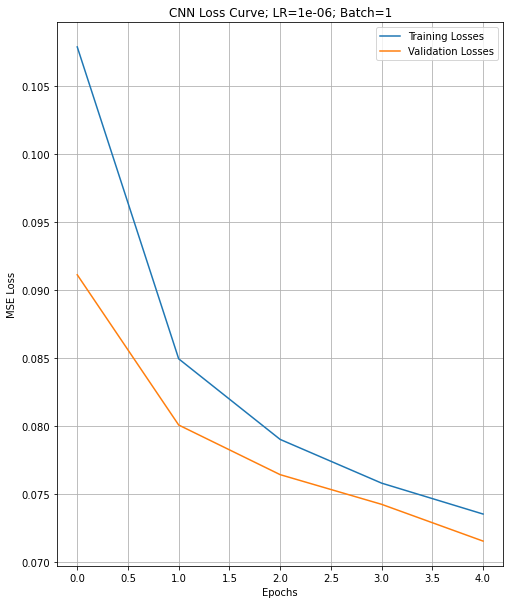

In [27]:
## SKIP FOR SIGOPT EXPERIMENT ##

def main():
    torch.cuda.empty_cache()
    # Resizing each image to 64 x 192.
    transform = transforms.Compose([
        # Citation:
        # https://pytorch.org/vision/stable/transforms.html#scriptable-transforms
        transforms.Resize((64, 192)),
    ])
    # Loading in images with resizing applied.
    training_set, validation_set, test_set = dataset.load_nvidia_dataset(batch_size=BATCH_SIZE, transform=transform)
    
    image_size = training_set.dataset[0][0].shape

    model = VanillaVisionTransformer.VisionTransformer(device,
                                                image_size,
                                               PATCH_SIZE, 
                                               HIDDEN_DIM,
                                               EMBED_DIM,
                                               NUM_CHANNELS,
                                               NUM_HEADS,
                                               NUM_LAYERS,
                                               DROPOUT).to(device)
    
    criterion = nn.MSELoss()
#     criterion = RMSELoss

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY_REGULARIZATION_TERM)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    best = float('inf')
    best_model = None
    best_epoch = None
    train_losses = []
    valid_losses = []
    scaler = torch.cuda.amp.GradScaler()


    for epoch in range(NUM_EPOCHS):
        
        # Training.
        train_loss = train(epoch, training_set, model, optimizer, criterion, scaler=scaler)
        temp = train_loss
        temp.cpu()
        temp = float(temp)
        train_losses.append(temp)
        print(f"Average training loss this epoch: {temp:.4f}")
                
        # Validation.
        valid_loss = validate(epoch, validation_set, model, criterion)
        temp = valid_loss
        temp.cpu()
        temp = float(temp)
        valid_losses.append(temp)
        
        scheduler.step(train_loss)
        
        if valid_loss < best:
            best = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch

            
    print('Best Loss @1: {:.4f}'.format(best))

    torch.save(best_model.state_dict(), './checkpoints/vanilla_vision_transformer.pth')
    
    losses_to_plot = train_losses, valid_losses
    plots(losses_to_plot, 
          lr=LEARNING_RATE, 
          reg=WEIGHT_DECAY_REGULARIZATION_TERM,
          batch=BATCH_SIZE, 
          # momentum=MOMENTUM  # not necessary for ADAM
         )
    
if __name__ == '__main__':
    main()

## Driver Code

In [4]:
def evaluate(assignments, args):
    
    # log source of hyperparameter suggestion
    sigopt.log_metadata('optimizer', "Adam")
    sigopt.log_model("Vanilla Vision Transformer")
    sigopt.log_dataset("Udacity self-driving dataset ")

    sigopt.params.setdefault("learning_rate", args['learning_rate'])
    sigopt.params.setdefault("reg", args['reg'])
    sigopt.params.setdefault("dropout", args['dropout'])
#     sigopt.params.setdefault("batch_size", int(args['batch_size']))
#     sigopt.params.setdefault("num_heads", int(args['num_heads']))
#     sigopt.params.setdefault("num_layers", int(args['num_layers']))
#     sigopt.params.setdefault("patch_size", int(args['patch_size']))
#     sigopt.params.setdefault("embed_dim", int(args['embed_dim']))
    
    
    # Resizing each image to 64 x 192.
    transform = transforms.Compose([
        # Citation:
        # https://pytorch.org/vision/stable/transforms.html#scriptable-transforms
        transforms.Resize((64, 192)),
    ])
    
    print("Params : ", sigopt.params)
    # Loading in images with resizing applied.
    training_set, validation_set, test_set = dataset.load_nvidia_dataset(batch_size=BATCH_SIZE, 
                                                                         transform=transform)

    image_size = training_set.dataset[0][0].shape

    model = VanillaVisionTransformer.VisionTransformer(device,
                                                image_size,
                                               PATCH_SIZE, 
                                               HIDDEN_DIM,
                                               EMBED_DIM,
                                               NUM_CHANNELS,
                                               NUM_HEADS,
                                               NUM_LAYERS,
                                               sigopt.params.dropout).to(device)
    
    criterion = nn.MSELoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=sigopt.params.learning_rate, 
                                 weight_decay =sigopt.params.reg)
#     scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    
    best = float('inf')
    best_model = None
    best_epoch = None
    train_losses = []
    valid_losses = []
    scaler = torch.cuda.amp.GradScaler()


    for epoch in range(NUM_EPOCHS):
        
        # Training.
        train_loss = train(epoch, training_set, model, optimizer, criterion, scaler=scaler)
        temp = train_loss
        temp.cpu()
        temp = float(temp)
        train_losses.append(temp)
        print(f"Average training loss this epoch: {temp:.4f}")
                
        # Validation.
        valid_loss = validate(epoch, validation_set, model, criterion)
        temp = valid_loss
        temp.cpu()
        temp = float(temp)
        valid_losses.append(temp)
        
#         scheduler.step(train_loss)
        
        if valid_loss < best:
            best = valid_loss
            best_model = copy.deepcopy(model)
            best_epoch = epoch
            
    print('Best Loss @1: {:.4f}'.format(best))
    
    losses_to_plot = train_losses, valid_losses
    plots(losses_to_plot, 
          lr=LEARNING_RATE, 
          reg=WEIGHT_DECAY_REGULARIZATION_TERM,
          batch=BATCH_SIZE, 
          # momentum=MOMENTUM  # not necessary for ADAM
         )

    torch.save(best_model.state_dict(), './checkpoints/vanilla_vision_transformer.pth')  
    sigopt.log_metric(name='MSE', value=best)
    return best.cpu().numpy()

In [5]:
# sigopt setup
import sigopt
import os
os.environ["SIGOPT_API_TOKEN"] = "XWBIVDWCVQXALUZQFDHNGOELLLKDJBMOJALEPCNQXQGBNIGC"
os.environ['SIGOPT_PROJECT'] = 'vanilla_vit'

args = {
    'learning_rate': 0.005,
    'reg': 0.0005,
    'dropout' : 0.2
#     'num_heads': 2,
#     'num_layers': 6,
}

C:\Users\Steven\anaconda3\envs\cs7643-a4-5\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:
sigopt.set_project('vanilla_vit')
conn = sigopt.Connection(client_token=os.environ.get("SIGOPT_API_TOKEN"))
experiment = conn.experiments().create(
    
    name="Vanilla ViT Optimization 5",
 
    parameters=[
        dict(name="reg", bounds=dict(min=0.00001, max=1.0), type="double", transformation="log"),
        dict(name="learning_rate", bounds=dict(min=0.00001 ,max=1.0), type="double", transformation="log"),
        dict(name="dropout", bounds=dict(min=0.1 ,max=0.9), type="double", transformation="log"),
#         dict(name="batch_size", categorical_values=["1","8","16", "32", "64"], type="categorical"),
#         dict(name="num_heads", bounds=dict(min=2, max=12), type="int"),
#         dict(name="num_layers", bounds=dict(min=2, max=12), type="int"),
#         dict(name="patch_size", categorical_values=["4","8","16"], type="categorical"),
#         dict(name="embed_dim", categorical_values=["256","512","768", "1024"], type="categorical")
        ],
 
    metrics=[
        dict(name="MSE", objective="minimize", strategy="optimize")
        ],
 
    observation_budget = 30,
)
 
print("Explore your experiment: https://app.sigopt.com/experiment/" + experiment.id + "/analysis")

Explore your experiment: https://app.sigopt.com/experiment/531250/analysis


In [7]:
#Optimization Loop
for _ in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    assignments = suggestion.assignments
    value = evaluate(assignments, args)
 
    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value
    )
    
    #update experiment object
    experiment = conn.experiments(experiment.id).fetch()
 
assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments  
 
print("BEST ASSIGNMENTS FOUND: \n", assignments)

Params :  {'learning_rate': 0.005, 'reg': 0.0005, 'dropout': 0.2}


C:\Users\Steven\anaconda3\envs\cs7643-a4-5\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: [0][0/3381]	Time 2.143 (2.143)	Loss 0.6384 (0.6384)	
Epoch: [0][10/3381]	Time 1.088 (1.170)	Loss 18.7463 (215.5252)	
Epoch: [0][20/3381]	Time 1.086 (1.127)	Loss 2.6276 (115.7242)	
Epoch: [0][30/3381]	Time 1.080 (1.112)	Loss 1.2603 (79.0734)	
Epoch: [0][40/3381]	Time 1.081 (1.103)	Loss 0.2339 (59.9848)	
Epoch: [0][50/3381]	Time 1.083 (1.099)	Loss 0.1292 (48.3055)	
Epoch: [0][60/3381]	Time 1.085 (1.096)	Loss 0.3087 (40.4091)	
Epoch: [0][70/3381]	Time 1.087 (1.094)	Loss 0.1378 (34.7433)	
Epoch: [0][80/3381]	Time 1.084 (1.092)	Loss 0.2478 (30.4876)	
Epoch: [0][90/3381]	Time 1.081 (1.092)	Loss 0.1048 (27.1576)	
Epoch: [0][100/3381]	Time 1.081 (1.093)	Loss 0.1952 (24.4855)	
Epoch: [0][110/3381]	Time 1.081 (1.091)	Loss 0.1344 (22.2962)	
Epoch: [0][120/3381]	Time 1.087 (1.091)	Loss 0.0671 (20.4732)	
Epoch: [0][130/3381]	Time 1.088 (1.090)	Loss 0.3817 (18.9217)	
Epoch: [0][140/3381]	Time 1.088 (1.090)	Loss 0.0643 (17.5909)	
Epoch: [0][150/3381]	Time 1.089 (1.089)	Loss 0.0558 (16.4338)	
E

Epoch: [0][1320/3381]	Time 1.084 (1.088)	Loss 0.0231 (1.9914)	
Epoch: [0][1330/3381]	Time 1.090 (1.088)	Loss 0.0529 (1.9778)	
Epoch: [0][1340/3381]	Time 1.091 (1.088)	Loss 0.2558 (1.9643)	
Epoch: [0][1350/3381]	Time 1.086 (1.088)	Loss 0.0518 (1.9506)	
Epoch: [0][1360/3381]	Time 1.090 (1.088)	Loss 0.1114 (1.9367)	
Epoch: [0][1370/3381]	Time 1.088 (1.088)	Loss 0.0791 (1.9232)	
Epoch: [0][1380/3381]	Time 1.088 (1.088)	Loss 0.1005 (1.9100)	
Epoch: [0][1390/3381]	Time 1.080 (1.088)	Loss 0.0878 (1.8971)	
Epoch: [0][1400/3381]	Time 1.081 (1.088)	Loss 0.0323 (1.8843)	
Epoch: [0][1410/3381]	Time 1.085 (1.088)	Loss 0.0920 (1.8718)	
Epoch: [0][1420/3381]	Time 1.084 (1.088)	Loss 0.0635 (1.8589)	
Epoch: [0][1430/3381]	Time 1.084 (1.088)	Loss 0.1687 (1.8467)	
Epoch: [0][1440/3381]	Time 1.084 (1.088)	Loss 0.0348 (1.8348)	
Epoch: [0][1450/3381]	Time 1.082 (1.088)	Loss 0.0568 (1.8227)	
Epoch: [0][1460/3381]	Time 1.083 (1.088)	Loss 0.1076 (1.8112)	
Epoch: [0][1470/3381]	Time 1.085 (1.088)	Loss 0.0228 (1

Epoch: [0][2630/3381]	Time 1.074 (1.083)	Loss 0.0489 (1.0486)	
Epoch: [0][2640/3381]	Time 1.072 (1.083)	Loss 0.0400 (1.0449)	
Epoch: [0][2650/3381]	Time 1.074 (1.083)	Loss 0.0612 (1.0411)	
Epoch: [0][2660/3381]	Time 1.074 (1.083)	Loss 0.0460 (1.0377)	
Epoch: [0][2670/3381]	Time 1.073 (1.083)	Loss 0.0604 (1.0340)	
Epoch: [0][2680/3381]	Time 1.077 (1.083)	Loss 0.0857 (1.0305)	
Epoch: [0][2690/3381]	Time 1.075 (1.083)	Loss 0.0812 (1.0268)	
Epoch: [0][2700/3381]	Time 1.075 (1.083)	Loss 0.0125 (1.0233)	
Epoch: [0][2710/3381]	Time 1.075 (1.082)	Loss 0.0409 (1.0198)	
Epoch: [0][2720/3381]	Time 1.071 (1.082)	Loss 0.0749 (1.0163)	
Epoch: [0][2730/3381]	Time 1.074 (1.082)	Loss 0.0100 (1.0129)	
Epoch: [0][2740/3381]	Time 1.074 (1.082)	Loss 0.0259 (1.0095)	
Epoch: [0][2750/3381]	Time 1.073 (1.082)	Loss 0.0359 (1.0060)	
Epoch: [0][2760/3381]	Time 1.073 (1.082)	Loss 0.0969 (1.0030)	
Epoch: [0][2770/3381]	Time 1.076 (1.082)	Loss 0.0293 (0.9995)	
Epoch: [0][2780/3381]	Time 1.077 (1.082)	Loss 0.0991 (0

C:\Users\Steven\anaconda3\envs\cs7643-a4-5\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: [0][3380/3381]	Time 0.812 (1.080)	Loss 0.0129 (0.8331)	
Average training loss this epoch: 0.8331
Epoch: [0][0/846]	Time 0.009 (0.009)	
Epoch: [0][10/846]	Time 0.367 (0.327)	
Epoch: [0][20/846]	Time 0.367 (0.345)	
Epoch: [0][30/846]	Time 0.365 (0.352)	
Epoch: [0][40/846]	Time 0.365 (0.355)	
Epoch: [0][50/846]	Time 0.365 (0.357)	
Epoch: [0][60/846]	Time 0.367 (0.358)	
Epoch: [0][70/846]	Time 0.364 (0.359)	
Epoch: [0][80/846]	Time 0.363 (0.360)	
Epoch: [0][90/846]	Time 0.363 (0.361)	
Epoch: [0][100/846]	Time 0.365 (0.361)	
Epoch: [0][110/846]	Time 0.365 (0.361)	
Epoch: [0][120/846]	Time 0.366 (0.362)	
Epoch: [0][130/846]	Time 0.365 (0.362)	
Epoch: [0][140/846]	Time 0.365 (0.362)	
Epoch: [0][150/846]	Time 0.364 (0.362)	
Epoch: [0][160/846]	Time 0.364 (0.363)	
Epoch: [0][170/846]	Time 0.365 (0.363)	
Epoch: [0][180/846]	Time 0.366 (0.363)	
Epoch: [0][190/846]	Time 0.366 (0.363)	
Epoch: [0][200/846]	Time 0.365 (0.363)	
Epoch: [0][210/846]	Time 0.367 (0.363)	
Epoch: [0][220/846]	Time 0.

C:\Users\Steven\anaconda3\envs\cs7643-a4-5\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


* Average Loss @1: 0.0756
Epoch: [1][0/3381]	Time 1.038 (1.038)	Loss 0.0640 (0.0640)	
Epoch: [1][10/3381]	Time 1.068 (1.065)	Loss 0.0237 (0.0731)	
Epoch: [1][20/3381]	Time 1.070 (1.066)	Loss 0.1765 (0.0917)	
Epoch: [1][30/3381]	Time 1.070 (1.066)	Loss 0.0337 (0.0748)	
Epoch: [1][40/3381]	Time 1.069 (1.067)	Loss 0.0607 (0.0683)	
Epoch: [1][50/3381]	Time 1.071 (1.067)	Loss 0.1569 (0.0724)	
Epoch: [1][60/3381]	Time 1.070 (1.067)	Loss 0.0385 (0.0740)	
Epoch: [1][70/3381]	Time 1.069 (1.067)	Loss 0.1229 (0.0736)	
Epoch: [1][80/3381]	Time 1.072 (1.067)	Loss 0.0459 (0.0707)	
Epoch: [1][90/3381]	Time 1.069 (1.067)	Loss 0.1196 (0.0750)	
Epoch: [1][100/3381]	Time 1.070 (1.067)	Loss 0.0203 (0.0744)	
Epoch: [1][110/3381]	Time 1.072 (1.067)	Loss 0.0037 (0.0732)	
Epoch: [1][120/3381]	Time 1.071 (1.067)	Loss 0.0094 (0.0749)	
Epoch: [1][130/3381]	Time 1.068 (1.067)	Loss 0.2093 (0.0734)	
Epoch: [1][140/3381]	Time 1.072 (1.067)	Loss 0.0277 (0.0752)	
Epoch: [1][150/3381]	Time 1.070 (1.067)	Loss 0.0083 (0.

Epoch: [1][1320/3381]	Time 1.068 (1.064)	Loss 0.0240 (0.0770)	
Epoch: [1][1330/3381]	Time 1.066 (1.064)	Loss 0.0546 (0.0769)	
Epoch: [1][1340/3381]	Time 1.065 (1.064)	Loss 0.0372 (0.0770)	
Epoch: [1][1350/3381]	Time 1.065 (1.064)	Loss 0.0158 (0.0769)	
Epoch: [1][1360/3381]	Time 1.065 (1.064)	Loss 0.0362 (0.0770)	
Epoch: [1][1370/3381]	Time 1.069 (1.064)	Loss 0.0153 (0.0771)	
Epoch: [1][1380/3381]	Time 1.064 (1.064)	Loss 0.0748 (0.0773)	
Epoch: [1][1390/3381]	Time 1.066 (1.064)	Loss 0.0295 (0.0777)	
Epoch: [1][1400/3381]	Time 1.063 (1.064)	Loss 0.0213 (0.0780)	
Epoch: [1][1410/3381]	Time 1.067 (1.064)	Loss 0.0853 (0.0781)	
Epoch: [1][1420/3381]	Time 1.064 (1.064)	Loss 0.1217 (0.0782)	
Epoch: [1][1430/3381]	Time 1.066 (1.064)	Loss 0.0052 (0.0780)	
Epoch: [1][1440/3381]	Time 1.063 (1.064)	Loss 0.0232 (0.0778)	
Epoch: [1][1450/3381]	Time 1.064 (1.064)	Loss 0.0223 (0.0778)	
Epoch: [1][1460/3381]	Time 1.064 (1.064)	Loss 0.0482 (0.0776)	
Epoch: [1][1470/3381]	Time 1.067 (1.064)	Loss 0.0648 (0

Epoch: [1][2630/3381]	Time 1.065 (1.063)	Loss 0.0363 (0.0749)	
Epoch: [1][2640/3381]	Time 1.065 (1.063)	Loss 0.0890 (0.0749)	
Epoch: [1][2650/3381]	Time 1.064 (1.063)	Loss 0.1779 (0.0749)	
Epoch: [1][2660/3381]	Time 1.067 (1.063)	Loss 0.0645 (0.0749)	
Epoch: [1][2670/3381]	Time 1.065 (1.063)	Loss 0.0336 (0.0748)	
Epoch: [1][2680/3381]	Time 1.064 (1.063)	Loss 0.0291 (0.0749)	
Epoch: [1][2690/3381]	Time 1.066 (1.063)	Loss 0.0868 (0.0748)	
Epoch: [1][2700/3381]	Time 1.065 (1.063)	Loss 0.0832 (0.0748)	
Epoch: [1][2710/3381]	Time 1.064 (1.063)	Loss 0.3907 (0.0749)	
Epoch: [1][2720/3381]	Time 1.070 (1.063)	Loss 0.0437 (0.0749)	
Epoch: [1][2730/3381]	Time 1.104 (1.064)	Loss 0.1192 (0.0749)	
Epoch: [1][2740/3381]	Time 1.090 (1.064)	Loss 0.0562 (0.0748)	
Epoch: [1][2750/3381]	Time 1.098 (1.064)	Loss 0.0172 (0.0746)	
Epoch: [1][2760/3381]	Time 1.119 (1.064)	Loss 0.0106 (0.0745)	
Epoch: [1][2770/3381]	Time 1.077 (1.064)	Loss 0.2730 (0.0745)	
Epoch: [1][2780/3381]	Time 1.099 (1.064)	Loss 0.0029 (0

KeyboardInterrupt: 

In [22]:
# %%experiment 
# {
#     'name': 'Vanilla ViT model Optimization test',
#     'metrics': [
#         {
#             'name': 'MSE',
#             'strategy': 'optimize',
#             'objective': 'minimize',
#         }
#     ],
#     'parameters': [
#         {
#             'name': 'reg',
#             'type': 'double',
#             'bounds': {'min': 0.0001, 'max': 0.5},
#             'transformation': 'log'
#         },
#         {
#             'name': 'learning_rate',
#             'type': 'double',
#             'bounds': {'min': 0.0001, 'max': 0.9},
#             'transformation': 'log'
#         },
#         {
#             'name': 'batch_size',
#             'type': 'categorical',
#             'categorical_values': ['32', '64']
#         }
#     ],
#     'budget': 30
# }

UsageError: Cell magic `%%experiment` not found.


In [23]:
# %%optimize vanilla_vit_optimization_run_test
# evaluate(args)

UsageError: Cell magic `%%optimize` not found.
